---
jupyter: fenicsx
---

# The FEniCS computing platform {#sec-fenicsx}

**FEniCS** is a popular open-source computing platform for solving partial differential equations (PDEs) with the finite element method (FEM). FEniCS enables users to quickly translate scientific models into efficient finite element code. With the high-level Python and C++ interfaces to FEniCS, it is easy to get started, but FEniCS offers also powerful capabilities for more experienced programmers. FEniCS runs on a multitude of platforms ranging from laptops to high-performance computers

[![](https://fenicsproject.org/assets/logo/fenics_logo.png){width="25%" fig-align="center"}](https://fenicsproject.org)

## Getting started {#sec-fenicsx-getting-started}

The latest stable release of FEniCSx is version 0.9, which was released in October 2024. The easiest way to start using `FEniCSx` on MacOS and other systems is to install it using `conda`:

``` bash
$ conda create -n fenicsx
$ conda activate fenicsx
$ conda install -c conda-forge fenics-dolfinx mpich pyvista 
$ conda install -c conda-forge petsc petsc4py
$ conda install ipykernel
$ python -m ipykernel install \
>       --user --name fenicsx --display-name "FEniCSx"
```

In [1]:
import dolfinx
print(f'DOLFINx version: {dolfinx.__version__}')

DOLFINx version: 0.9.0


## An Overview of the FEniCS Project {#sec-fenicsx-overview}

* The `FEniCS` Project is a research and software initiative focused on developing mathematical methods and software for solving partial differential equations (PDEs). Its goal is to provide intuitive, efficient, and flexible tools for scientific computing. Launched in 2003, the project is the result of collaboration among researchers from universities and research institutes worldwide. For the latest updates and more information, visit the [FEniCS Project](https://fenicsproject.org/)

* The latest version of the `FEniCS` project, `FEniCSx`, consists of several building blocks, namely `DOLFINx`, `UFL`, `FFCx`, and `Basix`. We will now go through the main objectives of each of these building blocks

  * `DOLFINx` is the high performance `C++` backend of `FEniCSx`, where structures such as meshes, function spaces and functions are implemented. Additionally, `DOLFINx` also contains compute intensive functions such as finite element assembly and mesh refinement algorithms. It also provides an interface to linear algebra solvers and data-structures, such as `PETSc`
  * `UFL` is a high-level form language for describing variational formulations with a high-level mathematical syntax
  * `FFCx` is the form compiler of `FEniCSx`; given variational formulations written with `UFL`, it generates efficient `C` code
  * `Basix` is the finite element backend of `FEniCSx`, responsible for generating finite element basis functions

## What you will learn

The goal of this tutorial is to demonstrate how to apply the finite element to solve PDEs using `FEniCS`. Through a series of examples, we will demonstrate how to:

* Solve linear PDEs (such as the Poisson equation)
* Solve time-dependent PDEs (such as the heat equation)
* Solve non-linear PDEs
* Solve systems of time-dependent non-linear PDEs

Important topics include: how to set boundary conditions of various types (Dirichlet, Neumann, Robin), how to create meshes, how to define variable coefficients, how to interact with linear and non-linear solvers, and how to post-process and visualize solutions

## Solving the Poisson equation {#sec-fenicsx-Poisson}

Authors: Hans Petter Langtangen, Anders Logg, Jørgen S. Dokken

The goal of this section is to solve one of the most basic PDEs, the Poisson equation, with a few lines of code in `FEniCSx`. We start by introducing some fundamental `FEniCSx` objects, such as `functionspace`,`Function`,  `TrialFunction` and `TestFunction`, and learn how to write a basic PDE solver. This will include:

* How to formulate a mathematical variational problem
* How to apply boundary conditions
* How to solve the discrete linear system
* How to visualize the solution

The Poisson equation is the following boundary-value problem:

$$\begin{aligned}
  -\nabla^2 u(\mathbf{x}) &= f(\mathbf{x})&&\mathbf{x} \in \Omega\\
  u(\mathbf{x}) &= u_D(\mathbf{x})&& \mathbf{x} \in \partial\Omega
\end{aligned}$$
 
Here, $u=u(\mathbf{x})$ is the unknown function, $f=f(\mathbf{x})$
is a prescribed function, 
$\nabla^2$ (often written as $\Delta$) is the Laplace operator, $\Omega$
is the spatial domain, and $\partial\Omega$ is its boundary. The Poisson problem  — consisting of the PDE $-\nabla^2 u = f$ together with the boundary condition $u=u_D$ on $\partial\Omega$ — is a boundary value problem that must be precisely defined before we can solve it numerically with `FEniCSx`

 * In the two-dimensional space with coordinates $x$ and $y$, we can expand the Poisson equation as

  $$-\frac{\partial^2 u}{\partial x^2} - \frac{\partial^2 u}{\partial y^2} = f(x,y)$$

  The unknown $u$ is now a function of two variables, $u=u(x,y)$, defined over the two-dimensional domain $\Omega$

  * The Poisson equation arises in numerous physical contexts, including heat conduction, electrostatics, diffusion of substances, twisting of elastic rods, inviscid fluid flow, and water waves. Moreover, the equation appears in numerical splitting strategies for more complicated systems of PDEs, in particular the Navier–Stokes equations

Solving a boundary value problem in `FEniCSx` consists of the following steps:

1. Identify the computational domain $\Omega$, the PDE, and its corresponding boundary conditions and source terms $f$
2. Reformulate the PDE as a finite element variational problem
3. Write a Python program defining the computational domain, the boundary conditions, the variational problem, and the source terms, using `FEniCSx`
4. Run the Python program to solve the boundary-value problem. Optionally, you can extend the program to derive quantities such as fluxes and averages,
   and visualize the results

As we have already covered step 1, we shall now cover steps 2-4

### Finite element variational formulation

`FEniCSx` is based on the finite element method, which is a general and
efficient mathematical technique for the numerical solution of
PDEs. The starting point for finite element methods is a PDE
expressed in _variational form_

The basic recipe for turning a PDE into a variational problem is:

- Multiply the PDE by a function $v$
- Integrate the resulting equation over the domain $\Omega$
- Perform integration by parts of those terms with second order derivatives

The function $v$ that multiplies the PDE is called a *test function*, while the unknown function $u$ to be approximated is referred to as a *trial function*.
The terms *trial function* and *test function* are also used in `FEniCSx`. Both test and trial functions belong to certain *specific function spaces* that define their properties

* In the present case, we multiply the Poisson equation by a test function $v$ and integrate over $\Omega$:

  $$\int_\Omega (-\nabla^2 u) v~\mathrm{d} x = \int_\Omega f v~\mathrm{d} x$$

  Here $\mathrm{d} x$ denotes the differential element for integration over the domain $\Omega$. We will later let $\mathrm{d} s$ denote the differential element for integration over $\partial\Omega$, the boundary of $\Omega$

* A rule of thumb when deriving variational formulations is that one tries to keep the order of derivatives of $u$ and $v$ as small as possible.
Here, we have a second-order differential of $u$, which can be transformed to a first derivative by employing the technique of
[integration by parts](https://en.wikipedia.org/wiki/Integration_by_parts).
The formula reads

  $$-\int_\Omega (\nabla^2 u)v~\mathrm{d}x
  = \int_\Omega\nabla u\cdot\nabla v~\mathrm{d}x - 
  \underbrace{\int_\Omega \nabla\cdot (v\nabla u) ~\mathrm{d}x}_{\displaystyle \scriptsize\int_{\partial\Omega}\frac{\partial u}{\partial n}v~\mathrm{d}s}$$

  where $\frac{\partial u}{\partial n}=\nabla u \cdot \mathbf{n}$ is the derivative of $u$ in the outward normal direction $\mathbf{n}$ on the boundary

* Another feature of variational formulations is that the test function $v$ must vanish on the parts of the boundary where the solution $u$ is prescribed.
  In the present problem, this means that $v = 0$ on the entire boundary $\partial\Omega$. Consequently, the second term in the integration by parts formula vanishes, and we obtain

  $$\int_\Omega \nabla u \cdot \nabla v~\mathrm{d} x = \int_\Omega f v~\mathrm{d} x$$
  
* If we require that this equation holds for all test functions $v$ in some suitable space $\hat{V}$, the so-called _test space_, we obtain a well-defined mathematical problem that uniquely determines the solution $u$, which lies in some function space $V$. Note that $V$ does not necessarily coincide with $\hat{V}$. We call the space $V$ the _trial space_. The equation above is referred to as the _weak form_(or *variational form*) of the original boundary-value problem. We can now  state our variational problem more precisely: $~$
Find $u\in V$ such that

  $$\int_\Omega \nabla u \cdot \nabla v~\mathrm{d} x = \int_\Omega f v~\mathrm{d} x\qquad \forall v \in \hat{V}$$

* For the present problem, the trial and test spaces, $V$ and $\hat{V}$, are defined as follows

  $$\color{red}{\begin{aligned}
     V&=\{v\in H^1(\Omega) \,\vert\, v=u_D \;\text{on } \partial \Omega \}\\
     \hat{V}&=\{v\in H^1(\Omega) \,\vert\, v=0 \;\text{on } \partial \Omega \}
  \end{aligned}}$$

  In short, $H^1(\Omega)$ is the Sobolev space consisting of functions $v$ for which both $v^2$ and $\lvert \nabla v \rvert^2$ have finite integrals over $\Omega$. The solution of the underlying PDE must belong to a function space in which derivatives are continuous. However, the Sobolev space $H^1(\Omega)$ also admits functions with discontinuous derivatives

  This weaker continuity requirement in the weak formulation (arising from the integration by parts) is crucial for constructing finite element function spaces. In particular, it permits the use of piecewise polynomial function spaces. Such spaces are built by stitching together polynomial functions over simple domains, such as intervals, triangles, quadrilaterals, tetrahedra, and hexahedra

* The variational problem is a _continuous problem_: it defines the solution $u$ in the infinite-dimensional function space $V$.
The finite element method for the Poisson equation approximates this solution by replacing the infinite-dimensional function spaces $V$ and $\hat{V}$, with _discrete_ (finite-dimensional) spaces $V_h\subset V$ and $\hat{V}_h \subset \hat{V}$. The resulting discrete
variational problem is then stated as: $~$ <font color="red">Find $u_h\in V_h$ such that</font>

  $$\color{red}{
  \begin{aligned}
     \int_\Omega \nabla u_h \cdot \nabla v~\mathrm{d} x &= \int_\Omega fv~\mathrm{d} x && \forall v \in \hat{V}_h
  \end{aligned}}
  $$

* This variational problem, together with appropriate definitions of $V_h$ and $\hat{V}_h,$ uniquely determines our approximate numerical solution to the Poisson equation.
Note that the boundary condition is incorporated into the trial and test spaces. While this may appear complicated at first,
it ensures that the finite element variational problem has the same form as the continuous variational problem

### Abstract finite element variational formulation

We will introduce the following notation for variational problems:
$\,$ Find $u\in V$ such that

$$\begin{aligned}
  a(u,v)&=L(v)&& \forall v \in \hat{V}
\end{aligned}$$

For the Poisson equation, we have:

$$\begin{aligned}
a(u,v) &= \int_{\Omega} \nabla u \cdot \nabla v~\mathrm{d} x\\
L(v) &= \int_{\Omega} fv~\mathrm{d} x
\end{aligned}$$

In the literature $a(u,v)$ is known as the _bilinear form_ and $L(v)$ as a _linear form_.
For every linear problem, we will identify all terms with the unknown $u$ and collect them in $a(u,v)$, and collect all terms with only known functions in $L(v)$.

To solve a linear PDE in `FEniCSx`, such as the Poisson equation, a user thus needs to perform two steps:

1. Choose the finite element spaces $V$ and $\hat{V}$ by specifying the domain (the mesh) and the type of function space (polynomial degree and type)
2. Express the PDE as a (discrete) variational problem: $\,$ Find $u\in V$ such that $a(u,v)=L(v)$ for all $v \in \hat{V}$

### Implementation

In this section, you will learn:

- How to use the *built-in meshes* in `DOLFINx`
- How to create *a spatially varying Dirichlet boundary conditions* on the whole domain boundary
- How to define a weak formulation of your PDE
- How *to solve the resulting system of linear equations*
- How *to visualize the solution using a variety of tools*
- How *to compute the $L^2(\Omega)$ error and the error at mesh vertices*

Up to this point, we’ve looked at the Poisson problem in very general terms: the domain $\Omega$, the boundary condition $u_D$, and the right-hand side $f$ were all left unspecified. To actually solve something, we now need to pick concrete choices for $\Omega$, $u_D$, and $f$

A good strategy is to set up the problem in a way that we already know the exact solution. That way, we can easily check whether our numerical solution is correct. Polynomials of low degree are usually the best choice here, because continuous Galerkin finite element spaces of degree $r$ can reproduce any polynomial of degree $r$ exactly

* To test our solver, we’ll construct a problem where we already know the exact solution. This approach is known as the method of manufactured solutions. The idea is simple:

	1.	Start by picking a function $u_e(x,y)$ that looks nice and simple
	2.	Plug $u_e$ into the PDE to figure out what the right-hand side $f(x,y)$ should be
	3.	Use $u_e$ as the boundary condition $u_D$
	4.	Finally, solve the problem numerically and compare the computed solution with $u_e$

**Step 1:** Choosing the exact solution

Let’s take a quadratic function in 2D:

$$ u_e(x,y) = 1 + x^2 + 2y^2 $$

**Step 2:** Computing the source term

If we insert $u_e$ into the Poisson equation, we obtain

$$f(x,y) = -6,
\;\;
u_D(x,y) = u_e(x,y) = 1 + x^2 + 2y^2$$

Notice that this holds regardless of the domain shape, as long as we prescribe $u_e$ on the boundary

**Step 3:** Choosing the domain

For simplicity, let’s use the unit square:

$$\Omega = [0,1] \times [0,1]$$

**Step 4:** Summary

This small example illustrates a very powerful strategy:

* Pick an exact solution
* Plug it into the PDE to generate the corresponding source term
* Solve the PDE with these inputs
* Verify that the numerical solution reproduces the exact solution

This workflow is at the heart of *the method of manufactured solutions*, and it provides a simple but rigorous way to validate our solver

**Generating simple meshes**

The next step is to define the discrete domain, called the mesh.
We do this using one of `FEniCSx`’s built-in mesh generators

Here, we create a unit square mesh spanning $[0,1]\times[0,1]$.
The cells of the mesh can be either triangles or quadrilaterals:

In [2]:
import numpy as np

from mpi4py import MPI
from dolfinx import mesh

N = 8
domain = mesh.create_unit_square(
  MPI.COMM_WORLD, 
  nx=N, 
  ny=N, 
  cell_type=mesh.CellType.quadrilateral
)

Notice that we need to provide an MPI communicator.
This determines how the program behaves in parallel:

* If we pass `MPI.COMM_WORLD`, a single mesh is created and distributed across the number of processors we specify.
For example, to run the program on two processors, we can use:

``` bash
$ mpirun -n 2 python tutorial_poisson.py
```

* If instead we use `MPI.COMM_SELF`, each processor will create its own independent copy of the mesh.
This can be useful when running many small problems in parallel, for example when sweeping over different parameters

**Defining the finite element function space**

Once the mesh is created, the next step is to define the finite element function space $V$.
`DOLFINx` supports a wide variety of finite element spaces of arbitrary order.
For a full overview, see the list of
[Supported elements in DOLFINx](https://defelement.org/lists/implementations/basix.ufl.html)

When creating a function space, we need to specify:

1.	The mesh on which the space is defined
2.	The element family (e.g., Lagrange, Raviart–Thomas, etc.)
3.	The polynomial degree of the element

In `DOLFINx`, this can be done by passing a tuple of the form `("family", degree)`, as shown below:

In [3]:
from dolfinx import fem

V = fem.functionspace(domain, ("Lagrange", 1))

See [Degree 1 Lagrange on a quadrilateral](https://defelement.org/elements/examples/quadrilateral-lagrange-equispaced-1.html)

The next step is to create a function that stores the Dirichlet boundary condition.
We then use interpolation to fill this function with the prescribed values

In [4]:
uD = fem.Function(V)
uD.interpolate(lambda x: 1 +x[0]**2 +2 *x[1]**2)

With the boundary data defined (which, in this case, coincides with the exact solution of our finite element problem), we now need to enforce it along the boundary of the mesh

The first step is to identify which parts of the mesh correspond to the outer boundary. In `DOLFINx`, the boundary is represented by facets (that is, the line segments making up the outer edges in 2D or surfaces in 3D).

We can extract the indices of all exterior facets using:

In [5]:
tdim = domain.topology.dim
fdim = tdim -1

domain.topology.create_connectivity(fdim, tdim)
boundary_facets = mesh.exterior_facet_indices(domain.topology)

This gives us the set of facets lying on the boundary of our discrete domain.
Once we know where the boundary is, we can proceed to apply the Dirichlet boundary conditions to all degrees of freedom (DoFs) located on these facets

For our current problem, we are using the "Lagrange" degree-1 function space.
In this case, the degrees of freedom (DoFs) are located at the vertices of each cell, so every boundary facet contains exactly two DoFs

To identify the local indices of these boundary DoFs, we use `dolfinx.fem.locate_dofs_topological`.
This function takes three arguments:

1.	the function space
2.	the dimension of the mesh entities we want to target, and
3.	the list of entities (in our case, the boundary facets)

Once we have the boundary DoFs, we can create the Dirichlet boundary condition as follows:

In [6]:
boundary_dofs = fem.locate_dofs_topological(V, fdim, boundary_facets)
bc = fem.dirichletbc(uD, boundary_dofs)

**Defining the trial and test function**

In mathematics, we usually distinguish between the trial space $V$ and the test space $\hat{V}$.
For the present problem, the only difference between the two would be the treatment of boundary conditions

In `FEniCSx`, however, boundary conditions are not built directly into the function space.
This means we can simply use the same space for both the trial and test functions

To express the variational formulation, we make use of the [Unified Form Language](https://github.com/FEniCS/ufl/) (UFL)

In [7]:
import ufl

u = ufl.TrialFunction(V)
v = ufl.TestFunction(V)

**Defining the source term**

Since the source term is constant throughout the domain, we can represent it using `dolfinx.fem.Constant`:

In [8]:
from dolfinx import default_scalar_type

f = fem.Constant(domain, default_scalar_type(-6))

While we could simply define the source term as `f = -6`, this has a limitation: if we later want to change its value, we would need to redefine the entire variational problem.
By using `dolfinx.fem.Constant`, we can easily update the value during the simulation, for example with `f.value = 5`

Another advantage is performance: declaring `f` as a constant allows the compiler to optimize the variational formulation, leading to faster assembly of the resulting linear system

**Defining the variational problem**

Now that we have defined all the components of our variational problem, we can write down the weak formulation:

In [9]:
a = ufl.dot(ufl.grad(u), ufl.grad(v)) *ufl.dx
L = f *v *ufl.dx

Notice how closely the Python syntax mirrors the mathematical expressions:

$$a(u,v) = \int_{\Omega} \nabla u \cdot \nabla v \,\mathrm{d}x,
\;\;
L(v) = \int_{\Omega} f v \,\mathrm{d}x$$

Here, `ufl.dx` represents integration over the domain $\Omega$, i.e. over all cells of the mesh.
This illustrates one of the major strengths of `FEniCSx`: $\,$ variational formulations can be written in Python in a way that almost directly matches their mathematical form, making it both natural and convenient to specify and solve complex PDE problems

**Expressing inner products**

The inner product

$$\int_\Omega \nabla u \cdot \nabla v \,\mathrm{d}x$$

can be expressed in different ways in `UFL`.
In our example, we wrote it as: `ufl.dot(ufl.grad(u), ufl.grad(v)) *ufl.dx`. In UFL, the dot operator performs a contraction: it sums over the last index of the first argument and the first index of the second argument.
Since both $\nabla u$ and $\nabla v$ are rank-1 tensors (vectors), this reduces to a simple dot product.

For higher-rank tensors, such as matrices (rank-2 tensors), the appropriate operator is `ufl.inner`, which computes the full Frobenius inner product.
For vectors, however, `ufl.dot` and `ufl.inner` are equivalent

**Forming and solving the linear system**

Having defined the finite element variational problem and boundary conditions, we can now create a `dolfinx.fem.petsc.LinearProblem`. This class provides a convenient interface for solving

  Find $u_h\in V$ such that $a(u_h, v)=L(v), \;\; \forall v \in \hat{V}$
  
In this example, we will use `PETSc` as the linear algebra backend, together with a direct solver (LU factorization)

For more details on Krylov subspace(KSP) solvers and preconditioners, see the [PETSc-documentation](https://petsc.org/main/docs/manual/ksp/?highlight=ksp#ksp-linear-system-solvers). Note that
`PETSc` is not a required dependency of `DOLFINx`, so we explicitly import the `DOLFINx` wrapper to interface with `PETSc`.
Finally, to ensure that the solver options passed to the `LinearProblem` apply only to this specific KSP solver, we assign a **unique** option prefix

In [10]:
from dolfinx.fem.petsc import LinearProblem

problem = LinearProblem(
    a, L, bcs=[bc],
    petsc_options={
        # Direct solver using LU factorization
        "ksp_type": "preonly",
        "pc_type": "lu"
    }
)

# Solve the system
uh = problem.solve()

# Optionally, view solver information
#ksp = problem.solver
#ksp.view()

The `ksp_type` option in `PETSc` KSP solver specifies which algorithm to use for solving the linear system, while `pc_type` specifies the type of preconditioner. For most FEM problems, Symmetric Positive Definite(SPD) systems typically use `cg` with `ilu` or `amg`, and if a direct LU solver is desired, one can use `ksp_type="preonly"` with `pc_type="lu"`

Using `problem.solve()`,
we solve the linear system of equations and return a `dolfinx.fem.Function` containing the solution

**Computing the error**

Finally, we want to compute the error to check the accuracy of the solution. We do this by comparing the finite element solution `uh` with the exact solution.
We do this by interpolating the exact solution into the the $P_2$-function space

In [11]:
V2 = fem.functionspace(domain, ("Lagrange", 2))
uex = fem.Function(V2)
uex.interpolate(lambda x: 1 +x[0]**2 +2 *x[1]**2)

We compute the error in two different ways. First, we compute the $L^2$ norm of the error, defined by 

$$E=\sqrt{\int_\Omega (u_D-u_h)^2 \,\mathrm{d} x}$$

We use `UFL` to express the $L^2$ error, and use `dolfinx.fem.assemble_scalar` to compute the scalar value.
In `DOLFINx`, `assemble_scalar` only assembles over the cells on the local process. This means that if we use 2 processes to solve our problem, we need to gather the solution to one.
We can do this with the `MPI.allreduce` function

In [12]:
L2_error = fem.form(ufl.inner(uh -uex, uh -uex) *ufl.dx)
error_local = fem.assemble_scalar(L2_error)
error_L2 = np.sqrt(domain.comm.allreduce(error_local, op=MPI.SUM))

Secondly, we compute the maximum error at any degree of freedom (dof).
The finite element solution `uh` can be expressed as a linear combination of the basis functions $\phi_j$ spanning the space $V$:

$$u = \sum_{j=1}^N U_j \phi_j$$

When we call `problem.solve()`, we obtain all coefficients $U_1$, $\dots$, $U_N$. These coefficients are the degrees of freedom (dofs).
We can access the dofs by retrieving the underlying vector from `uh`

However, note that a second-order function space contains more dofs than a first-order space, so the corresponding arrays cannot be compared directly.
Fortunately, since we have already interpolated the exact solution into the first-order space when defining the boundary condition, we can compare the maximum values at the dofs of the approximation space

In [13]:
error_max = np.max(np.abs(uD.x.array -uh.x.array))

# Only print the error on one process
if domain.comm.rank == 0:
    print(f"Error_L2 : {error_L2:.2e}")
    print(f"Error_max : {error_max:.2e}")

Error_L2 : 8.24e-03
Error_max : 5.33e-15


**Plotting the mesh using pyvista**

First, prepare a folder to store the output figures as follows:

In [14]:
from pathlib import Path

results_folder = Path("fenicsx/fundamentals")
results_folder.mkdir(exist_ok=True, parents=True)

We will visualize the mesh using [pyvista](https://docs.pyvista.org/), a Python interface to the VTK toolkit.
To begin, We convert the mesh into a format compatible with `pyvista` using the function `dolfinx.plot.vtk_mesh`. The first step is to create an unstructured grid that `pyvista` can work with

You can check the current plotting backend with:

In [15]:
import pyvista
from dolfinx import plot

topology, cell_types, geometry = plot.vtk_mesh(domain, tdim)
grid = pyvista.UnstructuredGrid(topology, cell_types, geometry)

`PyVista` supports several backends, each with its own advantages and limitations.
For more information and installation instructions, see the [pyvista documentation](https://docs.pyvista.org/user-guide/jupyter/index.html#state-of-3d-interactive-jupyterlab-plotting)

We can now use the `pyvista.Plotter` to visualize the mesh. We will display it both as a 2D and as a 3D warped representation. Provided that a proper X server connection is available, the default setting `pyvista.OFF_SCREEN=False` can be used to render the plots directly within the notebook

In [16]:
plotter = pyvista.Plotter(off_screen=True)
plotter.add_mesh(grid, show_edges=True)
plotter.add_axes()
plotter.view_xy()

# if not pyvista.OFF_SCREEN:
#   plotter.show()

# HTML 저장
plotter.export_html("fenicsx/fundamentals/unit_square_mesh.html")

```{=html}
<iframe src="fenicsx/fundamentals/unit_square_mesh.html"
        width="100%" height="400px"
        style="border:none;"
        allowfullscreen
        loading="lazy">
</iframe>
```

**Plotting a function using pyvista**

We want to plot the solution `uh`. Since the function space used to define `uh` is disconnected from the one used to define the mesh, we first create a mesh based on the DoF coordinates of the function space `V`. We then use `dolfinx.plot.vtk_mesh`, passing the function space as input, to generate a mesh whose geometry is based on these DoF coordinates

In [17]:
u_topology, u_cell_types, u_geometry = plot.vtk_mesh(V)

Next, we create the `pyvista.UnstructuredGrid` and add the DoF-values to the mesh

In [18]:
u_grid = pyvista.UnstructuredGrid(u_topology, u_cell_types, u_geometry)
u_grid.point_data["u"] = uh.x.array.real
u_grid.set_active_scalars("u")

u_plotter = pyvista.Plotter(off_screen=True)
u_plotter.add_mesh(
    u_grid, 
    show_edges=True,
    scalar_bar_args={
        "title": "u",
        "fmt": "%.1f",
        "color": "black",
        "label_font_size": 12,
        # "vertical": True,
        "n_labels": 7,
    },
)
u_plotter.add_axes()
u_plotter.view_xy()

# if not pyvista.OFF_SCREEN:
#     u_plotter.show()

# HTML 저장
u_plotter.export_html("fenicsx/fundamentals/poisson_solution_2D.html")

```{=html}
<iframe src="fenicsx/fundamentals/poisson_solution_2D.html"
        width="100%" height="400px"
        style="border:none;"
        allowfullscreen
        loading="lazy">
</iframe>
```

**External post-processing**

For post-processing outside Python, it is recommended to save the solution to a file using either `dolfinx.io.VTXWriter` or `dolfinx.io.XDMFFile`, and then visualize it in [ParaView](https://www.paraview.org/). This approach is especially useful for 3D visualization

In [19]:
from dolfinx import io

filename = results_folder/"poisson"

with io.VTXWriter(domain.comm, filename.with_suffix(".bp"), [uh]) as vtx:
    vtx.write(0.0)
    
with io.XDMFFile(domain.comm, filename.with_suffix(".xdmf"), "w") as xdmf:
    xdmf.write_mesh(domain)
    xdmf.write_function(uh)

## Weak imposition of Dirichlet conditions for the Poisson problem

Author: Jørgen S. Dokken

This section shows how to solve the previous Poisson problem using Nitsche’s method.
Weak imposition works by adding terms to the variational formulation to enforce the boundary condition, instead of altering the matrix system via strong imposition (lifting)

First, we import the necessary modules and set up the mesh and function space for the solution

In [20]:
import numpy as np
from mpi4py import MPI

from dolfinx import fem, mesh, plot, default_scalar_type
from dolfinx.fem.petsc import LinearProblem

from ufl import (
  Circumradius, 
  FacetNormal, 
  SpatialCoordinate, 
  TrialFunction, 
  TestFunction,
  dx, 
  ds, 
  div, 
  grad, 
  inner,
)

N = 8
domain = mesh.create_unit_square(MPI.COMM_WORLD, N, N)
V = fem.functionspace(domain, ("Lagrange", 1))

Next, we create a function for the exact solution (also used in the Dirichlet boundary condition) and the corresponding source function for the right-hand side.
The exact solution is defined using `ufl.SpatialCoordinate`, then interpolated into `uD` and used to generate the source function `f`

In [21]:
x = SpatialCoordinate(domain)
u_ex = 1 +x[0]**2 +2 *x[1]**2

uD = fem.Function(V)
uD.interpolate(fem.Expression(u_ex, V.element.interpolation_points()))
f = -div(grad(u_ex))

Unlike the first tutorial, we now need to revisit the variational form.
We begin by integrating the problem by parts to obtain

$$\begin{aligned}
    \int_{\Omega} \nabla u \cdot \nabla v~\mathrm{d}x - \int_{\partial\Omega}\nabla u \cdot \mathbf{n}\, v~\mathrm{d}s = \int_{\Omega} f v~\mathrm{d}x
\end{aligned}$$

As we are not enforcing the boundary condition strongly, the trace of the test function is not set to zero on the boundary.
We instead add the following two terms to the variational formulation:

$$\begin{aligned}
    -\int_{\partial\Omega} \nabla  v \cdot \mathbf{n}\, (u-u_D)~\mathrm{d}s + \frac{\alpha}{h} \int_{\partial\Omega} (u-u_D)v~\mathrm{d}s
\end{aligned}$$

The first term enforces symmetry in the bilinear form, and the second term ensures coercivity.
$u_D$ denotes the known Dirichlet condition, and $h$ is the diameter of the circumscribed sphere of the mesh element.
The bilinear and linear forms, $a$ and $L$, are then defined as

$$\begin{aligned}
    a(u, v) &= \int_{\Omega} \nabla u \cdot \nabla v ~\mathrm{d}x + \int_{\partial\Omega} -(\mathbf{n}\, \cdot\nabla u) v - (\mathbf{n}\, \cdot \nabla v) u + \frac{\alpha}{h} uv ~\mathrm{d}s \\
    L(v) &= \int_{\Omega} fv ~\mathrm{d}x + \int_{\partial\Omega} -(\mathbf{n}\, \cdot \nabla v) u_D + \frac{\alpha}{h} u_D v ~\mathrm{d}s
\end{aligned}$$

In [22]:
u = TrialFunction(V)
v = TestFunction(V)

n = FacetNormal(domain)
h = 2 *Circumradius(domain)
alpha = fem.Constant(domain, default_scalar_type(10))

a = inner(grad(u), grad(v)) *dx -inner(n, grad(u)) *v *ds
a += -inner(n, grad(v)) *u *ds +alpha /h *inner(u, v) *ds
L = inner(f, v) *dx 
L += -inner(n, grad(v)) *uD *ds +alpha /h *inner(uD, v) *ds

With the variational form in place, we can solve the linear problem

In [23]:
problem = LinearProblem(a, L)
uh = problem.solve()

We compute the error by comparing the numerical solution with the analytical solution

In [24]:
error_form = fem.form(inner(uh -uD, uh -uD) *dx)
error_local = fem.assemble_scalar(error_form)
error_L2 = np.sqrt(domain.comm.allreduce(error_local, op=MPI.SUM))
if domain.comm.rank == 0:
    print(f"Error_L2: {error_L2:.2e}")

Error_L2: 1.59e-03


The $L^2$-error has the same order of magnitude as in the first tutorial, and we also compute the maximum error over all degrees of freedom

In [25]:
error_max = domain.comm.allreduce(
  np.max(np.abs(uD.x.array -uh.x.array)), 
  op=MPI.MAX)
if domain.comm.rank == 0:
    print(f"Error_max : {error_max:.2e}")

Error_max : 5.41e-03


We observe that, due to the weak imposition of the boundary condition, the equation is not satisfied to machine precision at the mesh vertices. The solution is subsequently visualized using `pyvista`

In [26]:
import pyvista

u_grid = pyvista.UnstructuredGrid(*plot.vtk_mesh(V))
u_grid.point_data["u"] = uh.x.array.real
u_grid.set_active_scalars("u")

u_plotter = pyvista.Plotter(off_screen=True)
u_plotter.add_mesh(
  u_grid, 
  show_edges=True, 
  scalar_bar_args={
        "title": "u",
        "fmt": "%.1f",
        "color": "black",
        "label_font_size": 12,
        # "vertical": True,
        "n_labels": 7,
  },  
  show_scalar_bar=True
)

u_plotter.add_axes()
u_plotter.view_xy()

# if not pyvista.OFF_SCREEN:
#     u_plotter.show()

# HTML 저장
u_plotter.export_html(
  "fenicsx/fundamentals/poisson_nitsche_solution_2D.html"
)

```{=html}
<iframe src="fenicsx/fundamentals/poisson_nitsche_solution_2D.html"
        width="100%" height="400px"
        style="border:none;"
        allowfullscreen
        loading="lazy">        
</iframe>
```

## Deflection of a membrane

Authors: Hans Petter Langtangen, Anders Logg, Jørgen S. Dokken

In the first `FEniCSx` example, we addressed a simple, easily verifiable problem.
In this section, we consider a more physically relevant case that produces solutions with richer structure.
In particular, we compute the deflection $D(x,y)$ of a two-dimensional circular membrane of radius $R$, under a load distribution $p(x,y)$. The governing PDE is:

$$
\begin{aligned}
     -T \nabla^2D&=p \quad\text{in }\; \Omega=\{(x,y)\,\vert\, x^2+y^2\leq R^2 \}
\end{aligned}
$$

Here, $T$ denotes the constant membrane tension, and $p$ represents the external pressure load.
The boundary of the membrane is fixed, implying the boundary condition $D=0$.
We model a localized load using a Gaussian function:

$$
\begin{aligned}
     p(x,y)&=\frac{A}{2\pi\sigma}\exp\left(-\frac{1}{2}\left[\left(\frac{x-x_0}{\sigma}\right)^2 +\left(\frac{y-y_0}{\sigma}\right)^2\right] \right)
\end{aligned}
$$

where $A$ is the load amplitude, $(x_0, y_0)$ is the location of the load maximum, and $\sigma$ characterizes the *width* of $p$.
We place the load center at $(x_0, y_0) = (0, R_0)$, with $0 < R_0 < R$.
The resulting expression becomes

$$
\begin{aligned}
     p(x,y)&=\frac{A}{2\pi\sigma}\exp\left(-\frac{1}{2}\left[\left(\frac{x}{\sigma}\right)^2
     +\left(\frac{y-R_0}{\sigma}\right)^2\right]\right)
\end{aligned}
$$

### Scaling the equation

This problem involves several physical parameters, and it is useful to simplify the formulation by introducing dimensionless variables.
We define the scaled coordinates $\bar{x} = \tfrac{x}{R}$, $\bar{y} = \tfrac{y}{R}$, and the dimensionless deflection $w = \tfrac{D}{D_e}$, where $D_e$ is a characteristic deflection.
Introducing $\bar{R}_0 = \tfrac{R_0}{R}$, we obtain

$$
\begin{aligned}
    -\left(\frac{\partial^2 w}{\partial \bar{x}^2} +\frac{\partial^2 w}{\partial \bar{y}^2} \right)
    &=\frac{R^2A}{2\pi\sigma TD_e} \exp\left(-\frac{R^2}{2\sigma^2}\left[\bar{x}^2+(\bar{y}-\bar{R}_0)^2\right]\right)\\
    &=\alpha \exp\left(-\beta^2 \left[\bar{x}^2+(\bar{y}-\bar{R}_0)^2\right]\right)
\end{aligned}
$$

valid for $\bar{x}^2+\bar{y}^2<1$, where $\alpha = \frac{R^2A}{2\pi\sigma TD_e}$ and $\beta=\frac{R}{\sqrt{2}\sigma}$

With an appropriate scaling, both $w$ and its derivatives are of order unity. Consequently, the left-hand side of the scaled PDE is also of order unity, while the right-hand side is governed by the parameter $\alpha$. This motivates choosing $\alpha$ to be of order one; in this case, we set $\alpha = 4$.
(Alternatively, one can derive the analytical solution in scaled coordinates and verify that the maximum deflection equals $D_e$ when $\alpha = 4$, which provides the definition of $D_e$)

With $D_e = \tfrac{R^2 A}{8 \pi \sigma T}$ and omitting the overbars, the scaled problem becomes

$$-\nabla^2 w = 4 \exp\left(-\beta^2 \left[x^2 + (y-R_0)^2\right]\right)$$

to be solved over the unit disk, with $w=0$ on the boundary

In the nondimensional formulation, the problem depends only on two parameters: the dimensionless width of the pressure distribution $\beta$ and the location of the pressure maximum $R_0 \in [0,1]$.
In the limit $\beta \to 0$, the solution converges to the special case $w = 1 - x^2 - y^2$

Given a computed scaled solution $w$, the corresponding physical deflection is recovered as

$$
\begin{aligned}
    D=\frac{AR^2}{8\pi\sigma T}w
\end{aligned}
$$

### Implementation

Author: Jørgen S. Dokken

In this section, we will solve the membrane deflection problem.
By the end of this section, you should be able to:

* Construct a simple mesh using the `GMSH` Python API and import it into `DOLFINx`
* Specify constant boundary conditions via a geometrical identifier
* Employ `ufl.SpatialCoordinate` to define a spatially varying function
* Interpolate a `ufl.Expression` into a suitable function space
* Evaluate a `dolfinx.Function` at arbitrary points

**Creating the mesh**

To construct the computational geometry, we use the Python API of [GMSH](https://gmsh.info/).
We begin by importing the gmsh module and initializing it

In [27]:
# $ conda install -c conda-forge python-gmsh
import gmsh

if not gmsh.isInitialized():
    gmsh.initialize()

Next, we define the membrane geometry and begin the setup using the `GMSH` CAD kernel, which automatically generates the required data structures in the background.
When calling `addDisk`, the first three arguments specify the $x,$ $y,$ and $z$ coordinates of the circle’s center, while the final two define the radii in the $x$- and $y$-directions

In [28]:
# gmsh.model.occ.addDisk(xc, yc, zc, rx, ry)
#   xc, yc, zc : center coordinates
#   rx, ry     : radii in x- and y-directions
membrane = gmsh.model.occ.addDisk(0.0, 0.0, 0.0, 1, 1)

# Synchronize the CAD kernel with the gmsh model
gmsh.model.occ.synchronize()

Next, we define the membrane as a physical surface so that `GMSH` will recognize it during mesh generation.
Because a surface is a two-dimensional entity, we pass `2` as the first argument, the membrane’s entity tag as the second, and the physical tag as the last.
In a later example, we will explain in more detail when and why this physical tag becomes important

In [29]:
gdim = 2
physical_tag = 1

# Remove any existing physical groups with the same (dim, tag)
for dim, tag in gmsh.model.getPhysicalGroups():
    if dim == gdim and tag == physical_tag:
        gmsh.model.removePhysicalGroups([(dim, tag)])

# Now safely add the new physical group
pg = gmsh.model.addPhysicalGroup(gdim, [membrane], physical_tag)
gmsh.model.setPhysicalName(gdim, pg, "Circular Membrane")

Finally, we generate the two-dimensional mesh, setting a uniform element size by adjusting the `GMSH` options

In [30]:
gmsh.option.setNumber("Mesh.CharacteristicLengthMin", 0.05)
gmsh.option.setNumber("Mesh.CharacteristicLengthMax", 0.05)
gmsh.model.mesh.generate(gdim)

Info    : Meshing 1D...
Info    : Meshing curve 1 (Ellipse)
Info    : Done meshing 1D (Wall 0.000199625s, CPU 0.000227s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.050224s, CPU 0.083748s)
Info    : 1552 nodes 3103 elements


**Interfacing with GMSH in DOLFINx**

We import the `GMSH`-generated mesh directly into `DOLFINx` using the `dolfinx.io.gmshio` interface.
In this example, we did not specify which process created the `GMSH` model, so a copy of the model is created on each MPI process. However, our goal is to work with a single mesh distributed across all processes. To accomplish this, we take the model generated on rank `0` of `MPI.COMM_WORLD` and distribute it to all available ranks

The import also provides two sets of mesh tags: one for cells defined by physical groups and one for facets defined by physical groups. Since we did not add any physical groups of dimension `gdim -1`, the `facet_tags` object will be empty

In [31]:
from mpi4py import MPI
from dolfinx.io import gmshio
from dolfinx.fem.petsc import LinearProblem

domain, cell_tags, facet_tags = gmshio.model_to_mesh(
  gmsh.model, 
  MPI.COMM_WORLD, 
  rank=0, 
  gdim=gdim
)

gmsh.finalize()

We define the function space as in the previous tutorial

In [32]:
from dolfinx import fem, plot

V = fem.functionspace(domain, ("Lagrange", 1))

In [33]:
import pyvista

# Extract topology from mesh and create pyvista mesh
topology, cell_types, x = plot.vtk_mesh(V)
grid = pyvista.UnstructuredGrid(topology, cell_types, x)

plotter = pyvista.Plotter(off_screen=True)
plotter.add_mesh(grid, show_edges=True)
plotter.add_axes()
plotter.view_xy()

# if not pyvista.OFF_SCREEN:
#     plotter.show()

# HTML 저장
plotter.export_html("fenicsx/fundamentals/membrane_mesh.html")

```{=html}
<iframe src="fenicsx/fundamentals/membrane_mesh.html"
        width="100%" height="450px"
        style="border:none;"
        allowfullscreen
        loading="lazy">        
</iframe>
```

**Defining a spatially varying load**

The pressure function on the right-hand side is defined with `ufl.SpatialCoordinate` and two constants, $\beta$ and $R_0$

In [34]:
from dolfinx import default_scalar_type
import ufl

x = ufl.SpatialCoordinate(domain)

beta = fem.Constant(domain, default_scalar_type(12))
R0 = fem.Constant(domain, default_scalar_type(0.3))

p = 4 *ufl.exp(-beta**2 *(x[0]**2 +(x[1] -R0)**2))

**Interpolation of a `ufl` expression**

Since the load `p` is defined as a spatially varying function, we interpolate it into an appropriate function space for visualization. To do this, we use `dolfinx.Expression`, which accepts any `UFL` expression together with a set of points on the reference element. In practice, we provide the interpolation points of the target space. Because `p` exhibits rapid spatial variation, we select a high-order function space to represent it

In [35]:
Q = fem.functionspace(domain, ("Lagrange", 5))
expr = fem.Expression(p, Q.element.interpolation_points())

pressure = fem.Function(Q)
pressure.interpolate(expr)

We next plot the load on the domain

In [36]:
p_grid = pyvista.UnstructuredGrid(*plot.vtk_mesh(Q))
p_grid.point_data["p"] = pressure.x.array.real

warped_p = p_grid.warp_by_scalar("p", factor=0.5)
warped_p.set_active_scalars("p")

load_plotter = pyvista.Plotter(off_screen=True)
load_plotter.add_mesh(
  warped_p,
  show_edges=True, 
  show_scalar_bar=True,
  cmap="jet"
)
load_plotter.add_axes() 

# if not pyvista.OFF_SCREEN:
#     load_plotter.show()

# HTML 저장
load_plotter.export_html("fenicsx/fundamentals/membrane_load.html")

```{=html}
<iframe src="fenicsx/fundamentals/membrane_load.html"
        width="100%" height="500px"
        style="border:none;"
        allowfullscreen
        loading="lazy">        
</iframe>
```

**Create a Dirichlet boundary condition using geometrical conditions**

The next step is to define the homogeneous boundary condition. Unlike in the first tutorial,  we use `dolfinx.fem.locate_dofs_geometrical` to identify the degrees of freedom on the boundary. Since our domain is the unit circle, these degrees of freedom correspond to coordinates $(x, y)$ such that $\sqrt{x^2 + y^2} = 1$

In [37]:
import numpy as np

def on_boundary(x):
    return np.isclose(np.sqrt(x[0]**2 +x[1]**2), 1)

boundary_dofs = fem.locate_dofs_geometrical(V, on_boundary)

Since our Dirichlet condition is homogeneous (`u=0` on the entire boundary), we can define it using `dolfinx.fem.dirichletbc` by specifying a constant value, the boundary degrees of freedom and the function space on which it should be applied

In [38]:
bc = fem.dirichletbc(default_scalar_type(0), boundary_dofs, V)

**Defining and solving the variational problem**

The variational problem is identical to our first Poisson problem, with `p` replacing `f`

In [39]:
u = ufl.TrialFunction(V)
v = ufl.TestFunction(V)

a = ufl.dot(ufl.grad(u), ufl.grad(v)) *ufl.dx
L = p *v *ufl.dx

problem = LinearProblem(
  a, 
  L, 
  bcs=[bc], 
  petsc_options={"ksp_type": "preonly", "pc_type": "lu"}
)
uh = problem.solve()

We plot the deflection `uh` over the domain $\Omega$

In [40]:
# Set deflection values and add it to plotter
grid.point_data["u"] = uh.x.array
warped = grid.warp_by_scalar("u", factor=25)

u_plotter = pyvista.Plotter(off_screen=True)
u_plotter.add_mesh(
  warped, 
  show_edges=True, 
  show_scalar_bar=True, 
  scalars="u",
  cmap='jet'
)
u_plotter.add_axes() 

# if not pyvista.OFF_SCREEN:
#     u_plotter.show()

# HTML 저장
u_plotter.export_html("fenicsx/fundamentals/membrane_u.html")

```{=html}
<iframe src="fenicsx/fundamentals/membrane_u.html"
        width="100%" height="350px"
        style="border:none;"
        allowfullscreen
        loading="lazy">        
</iframe>
```

**Plotting along a line in the domain**

A convenient way to compare the load and deflection is by plotting them along $x=0$, using a set of points along the $y$-axis to evaluate the finite element functions $u$ and $p$

In [41]:
tol = 0.001  # Avoid hitting the outside of the domain
y = np.linspace(-1 +tol, 1 -tol, 101)

points = np.zeros((3, 101))
points[1] = y
u_values = []
p_values = []

A finite element function can be expressed as a linear combination of all its degrees of freedom:

$$u_h(x) = \sum_{i=1}^N c_i \, \phi_i(x)$$

where $c_i$ are the coefficients of $u_h$ and $\phi_i$ are the basis functions. In principle, this allows us to evaluate the solution at any point in $\Omega$

However, since a mesh typically contains a large number of degrees of freedom (i.e., $N$ is large), evaluating every basis function at each point would be inefficient.
Instead, we first identify which mesh cell contains the point $x$. This can be done efficiently using a *bounding box tree*, which enables a fast recursive search through the mesh cells

In [42]:
from dolfinx import geometry

bb_tree = geometry.bb_tree(domain, domain.topology.dim)

We can now determine which cells each point intersects by using `dolfinx.geometry.compute_collisions_points`. This function returns, for every input point, a list of cells whose bounding boxes overlap with that point. Since different points may correspond to a varying number of cells, the results are stored in a `dolfinx.cpp.graph.AdjacencyList_int32`. The cells associated with the $i$-th point can be accessed with `links(i)`

Because a cell’s bounding box generally extends beyond the cell itself in $\mathbb{R}^n$, we must verify whether the point actually inside the cell. This is done with `dolfinx.geometry.compute_colliding_cells`, which computes the exact distance between the point and the cell (approximating higher-order cells as convex hulls). Like the previous function, it also  returns an adjacency list, since a point may lie on a facet, edge, or vertex shared by multiple cells

Finally, to ensure that the code runs correctly in parallel when the mesh is distributed across multiple processors, we create a subset, `points_on_proc`, that includes only the points located on the current processor

In [43]:
cells = []
points_on_proc = []

# Find cells whose bounding-box collide with the the points
cell_candidates = geometry.compute_collisions_points(
  bb_tree, 
  points.T
)

# Choose one of the cells that contains the point
colliding_cells = geometry.compute_colliding_cells(
  domain, 
  cell_candidates, 
  points.T
)

for i, point in enumerate(points.T):
    if len(colliding_cells.links(i)) > 0:
        points_on_proc.append(point)
        cells.append(colliding_cells.links(i)[0])

We now have a list of points associated with the processor and the cell each point belongs to. This allows us to use `uh.eval` and `pressure.eval` to compute the function values at these points

In [44]:
points_on_proc = np.array(points_on_proc, dtype=np.float64)

u_values = uh.eval(points_on_proc, cells)
p_values = pressure.eval(points_on_proc, cells)

With the coordinates and the corresponding function values, we can now plot the results using `matplotlib`

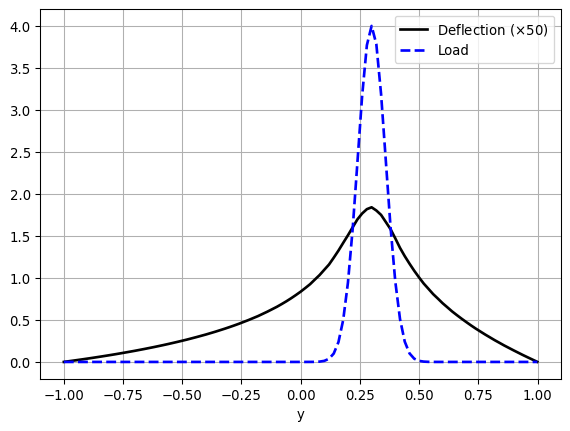

In [45]:
import matplotlib.pyplot as plt

fig = plt.figure()

plt.plot(points_on_proc[:, 1], 50 *u_values, 
  "k", lw=2, label="Deflection ($\\times 50$)")
plt.plot(points_on_proc[:, 1], p_values, 
  "b--", lw=2, label="Load")

plt.grid(True)
plt.legend()
plt.xlabel("y")
plt.show()

**Saving functions to file**

To visualize the solution in [`ParaView`](https://www.paraview.org/), we can save it to a file as follows:

In [46]:
from pathlib import Path
import dolfinx.io

results_folder = Path("fenicsx/fundamentals")
results_folder.mkdir(exist_ok=True, parents=True)

filename = results_folder/"membrane"

pressure.name = "Load"
uh.name = "Deflection"

with dolfinx.io.VTXWriter(
  MPI.COMM_WORLD, results_folder/"membrane_pressure.bp", 
  [pressure], engine="BP4") as vtx:
    vtx.write(0.0)

with dolfinx.io.VTXWriter(
  MPI.COMM_WORLD, results_folder/"membrane_deflection.bp", 
  [uh], engine="BP4") as vtx:
    vtx.write(0.0)

## A Gallery of finite element solvers

The aim of this chapter is to demonstrate how a variety of important PDEs from science and engineering can be solved using just a few lines of `DOLFINx` code. We start with the heat equation, then proceed to the nonlinear Poisson equation, the equations of linear elasticity, and the Navier–Stokes equations. These examples illustrate how to handle time-dependent problems, nonlinear problems, vector-valued problems, and systems of PDEs. For each case, we derive the variational formulation and implement the problem in `Python` in a way that closely mirrors the underlying mathematics

### The heat equation

Authors: Hans Petter Langtangen, Anders Logg, Jørgen S. Dokken

As a first extension of the Poisson problem introduced in the previous chapter, we now turn to the time-dependent heat equation (also known as the time-dependent diffusion equation). This equation can be viewed as the natural generalization of the Poisson equation, which describes the stationary distribution of heat in a body, to the case where the distribution evolves over time. By discretizing time into small intervals and applying standard time-stepping methods, we can solve the heat equation as a sequence of variational problems, in much the same way as we solved the Poisson equation

**The PDE problem**

The model problem for the time-dependent PDE is given by

$$
\begin{aligned}
\frac{\partial u}{\partial t}&=\nabla^2 u + f && \text{in } \Omega \times (0, T] \\
u &= u_D && \text{on } \partial\Omega \times (0,T] \\
u &= u_0 && \text{at } t=0
\end{aligned}$$

Here, $u$ depends on both space and time; for example, $u = u(x,y,t)$ if the spatial domain $\Omega$ is two-dimensional. The source term $f$ and the boundary condition $u_D$ may also vary with space and time, while the initial condition $u_0$ is a function of space alone

**The variational formulation**

A simple approach to solving time-dependent PDEs with the finite element method is to first discretize the time derivative using a finite difference approximation. This reduces the problem to a sequence of stationary equations, each of which can then be written in variational form. We use the superscript $n$ to denote a quantity at time $t_n$, where $n$ indexes the discrete time levels. For example, $u^n$ represents the value of $u$ at time level $n$. The first step in a finite difference discretization of time is to evaluate the PDE at a chosen time level, such as $t_{n+1}$

$$
\begin{aligned}
    \left(\frac{\partial u }{\partial t}\right)^{n+1}= \nabla^2 u^{n+1}+ f^{n+1}
\end{aligned}$$

The time derivative can be approximated by a difference quotient. For reasons of both simplicity and stability, we adopt the backward difference scheme:

$$\begin{aligned}
\left(\frac{\partial u }{\partial t}\right)^{n+1}\approx \frac{u^{n+1}-u^n}{\Delta t}
\end{aligned}$$

where $\Delta t$ denotes the time-step size. Substituting this expression into the equation at time level $n +1$ gives

$$\begin{aligned}
\frac{u^{n+1}-u^n}{\Delta t}= \nabla^2 u^{n+1}+ f^{n+1}
\end{aligned}$$

This is the time-discrete form of the heat equation, known as the backward Euler or implicit Euler scheme

We rearrange the equation so that the left-hand side contains only the unknown $u^{n+1}$, while the right-hand side contains terms that are already known. This yields a sequence of stationary problems for $u^{n+1}$, given that $u^{n}$ is available from the previous time step:

$$\begin{aligned}
u^0 &= u_0\\
u^{n+1} - \Delta t \nabla^2 u^{n+1} &= u^{n} + \Delta t f^{n+1}, \quad n = 0,1,2,\dots
\end{aligned}$$

Starting from the initial condition $u_0$, we can then compute $u^0$, $u^1$, $u^2$, and so forth

Next, we apply the finite element method. To do this, we first derive the weak formulation of the equation: we multiply by a test function $v \in \hat{V}$ and integrate the second-order derivatives by parts. For simplicity, we now denote $u^{n+1}$ by $u$. The resulting weak formulation can be written as

$$\begin{aligned}
a(u,v) &= L_{n+1}(v)
\end{aligned}$$

where

$$\begin{aligned}
a(u,v) &= \int_{\Omega} \big( u v + \Delta t \nabla u \cdot \nabla v \big)\,\mathrm{d}x \\
L_{n+1}(v) &= \int_{\Omega} \big(u^n + \Delta t f^{n+1}\big)\, v \,\mathrm{d}x
\end{aligned}$$

**Projection or interpolation of the initial condition**

In addition to the variational problem solved at each time step, we also need to approximate the initial condition. This can likewise be expressed as a variational problem:

$$\begin{aligned}
a_0(u,v) &= L_0(v)
\end{aligned}$$

with

$$\begin{aligned}
a_0(u,v) &= \int_{\Omega} u v \,\mathrm{d}x\\
L_0(v) &= \int_{\Omega} u_0 v \,\mathrm{d}x
\end{aligned}$$

Solving this variational problem gives $u^0$, which is the $L^2$ projection of the prescribed initial condition $u_0$ onto the finite element space

An alternative way to construct $u^0$ is by directly interpolating the initial value $u_0$. We discussed the use of interpolation in `DOLFINx` in the membrane deflection

In `DOLFINx`, the initial condition can be obtained either by projection or by interpolation. The most common approach is projection, which provides an approximation of $u_0$. However, in applications where we want to verify the implementation against exact solutions, interpolation must be used. In this chapter, we will consider such a case

#### Diffusion of a Gaussian function

Author: Jørgen S. Dokken

Let us now consider a more interesting problem: the diffusion of a Gaussian hill. We take the initial condition to be

$$\begin{aligned}
u_0(x,y) &= e^{-a (x^2 +y^2)}
\end{aligned}$$

with $a = 5$ on the domain $[-2,2]\times[-2,2]$. For this problem, we impose homogeneous Dirichlet boundary conditions ($u_D = 0$)

The first difference from the previous problem is that the domain is no longer the unit square. We create the rectangular domain using `dolfinx.mesh.create_rectangle`

In [47]:
import numpy as np
import matplotlib as mpl

from mpi4py import MPI
from petsc4py import PETSc
import pyvista

from dolfinx import fem, mesh, io, plot
from dolfinx.fem.petsc import (
  assemble_vector, assemble_matrix,
  create_vector, apply_lifting, set_bc
)
import ufl

# Define temporal parameters
t = 0.0            # Start time
T = 1.0            # Final time
num_steps = 50
dt = T /num_steps  # time step size

# Define mesh
nx, ny = 50, 50
domain = mesh.create_rectangle(
  MPI.COMM_WORLD, 
  [np.array([-2, -2]), np.array([2, 2])],
  [nx, ny], 
  mesh.CellType.triangle
)

V = fem.functionspace(domain, ("Lagrange", 1))

In [48]:
results_folder = Path("fenicsx/heat")
results_folder.mkdir(exist_ok=True, parents=True)

tdim = domain.topology.dim
grid = pyvista.UnstructuredGrid(*plot.vtk_mesh(domain, tdim))

plotter = pyvista.Plotter(off_screen=True)
plotter.add_mesh(grid, show_edges=True)
plotter.add_axes()
plotter.view_xy()

# if not pyvista.OFF_SCREEN:
#     plotter.show()

# HTML 저장
plotter.export_html(results_folder/"heat_mesh.html")

```{=html}
<iframe src="fenicsx/heat/heat_mesh.html"
        width="100%" height="350px"
        style="border:none;"
        allowfullscreen
        loading="lazy">        
</iframe>
```

Note that we have used a much higher resolution than before to better capture the features of the solution.
We can also easily update the initial and boundary conditions. Instead of defining the initial condition using a class, we simply use a function

In [49]:
# Create initial condition
def initial_condition(x, a=5):
    return np.exp(-a *(x[0]**2 +x[1]**2))

u_n = fem.Function(V)
u_n.name = "u_n"
u_n.interpolate(initial_condition)

# Create boundary condition
fdim = tdim -1

# Select all boundary facets
boundary_facets = mesh.locate_entities_boundary(
  domain, 
  fdim, 
  lambda x: np.full(x.shape[1], True, dtype=bool)
)

# Extract boundary DOFs
boundary_dofs = fem.locate_dofs_topological(
  V, 
  fdim, 
  boundary_facets
)

# Define boundary condition (u = 0 on the entire boundary)
# For scalar constants, 
#   also pass V to specify the function space
bc = fem.dirichletbc(
  PETSc.ScalarType(0), 
  boundary_dofs, 
  V
)

**Variational formulation**

As in the previous example, we set up the necessary objects for the time-dependent problem so that we do not need to recreate the data structures

In [50]:
u = ufl.TrialFunction(V)
v = ufl.TestFunction(V)

f = fem.Constant(domain, PETSc.ScalarType(0))

a = (u *v +dt *ufl.dot(ufl.grad(u), ufl.grad(v))) *ufl.dx
L = (u_n +dt *f) *v *ufl.dx

**Preparing linear algebra structures for time dependent problems**

Even though `u_n` depends on time, we use the same function for both `f` and `u_n` at each time step. We then call `dolfinx.fem.form` to create the assembly kernels for the matrix and vector

In [51]:
bilinear_form = fem.form(a)
linear_form = fem.form(L)

The left-hand side of the system, the matrix `A`, does not change between time steps, so it only needs to be assembled once. The right-hand side, however, depends on the previous solution `u_n` and must be assembled at every time step. For this reason, we create the vector `b` from `L` and reuse it at each step

In [52]:
A = assemble_matrix(bilinear_form, bcs=[bc])
A.assemble()
b = create_vector(linear_form)

**Using `petsc4py` to create a linear solver**

Since we have already assembled `a` into the matrix `A`, we cannot use the `dolfinx.fem.petsc.LinearProblem` class. Instead, we create a  `PETSc` linear solver, assign the matrix `A` to it, and select a solution strategy

In [53]:
solver = PETSc.KSP().create(domain.comm)
solver.setOperators(A)
solver.setType(PETSc.KSP.Type.PREONLY)
solver.getPC().setType(PETSc.PC.Type.LU)

**Saving time-dependent solutions with XDMFFile**

To visualize the solution in an external program such as `Paraview`, we create an `XDMFFile`, which can store multiple solutions. The main advantage of using an XDMFFile is that the mesh only needs to be stored once, and multiple solutions can be appended to the same grid, thereby reducing the storage requirements

The first argument to `XDMFFile` specifies the communicator used to store the data. Since we want a single output file regardless of the number of processors, we use the `COMM_WORLD`. The second argument is the name of the output file, and the third argument specifies the file mode, which can be read (`"r"`), write (`"w"`) or append (`"a"`)

In [54]:
xdmf = io.XDMFFile(
  domain.comm, 
  results_folder/"heat.xdmf", 
  "w"
)
xdmf.write_mesh(domain)

# Define solution variable, 
#  and interpolate initial solution for visualization
uh = fem.Function(V)
uh.name = "uh"
uh.interpolate(initial_condition)

xdmf.write_function(uh, t)

**Visualizing time-dependent solutions with PyVista**

We use the `DOLFINx` plotting tools, based on `PyVista`, to plot the solution at every time step. We also display a colorbar showing the initial maximum values of `u`. For this, we use the convenience function `renderer`:

In [55]:
from functools import partial

viridis = mpl.colormaps.get_cmap("viridis").resampled(25)
sargs = dict(
  title_font_size=25, 
  label_font_size=20, 
  fmt="%.2f", 
  color="black",
  position_x=0.1, 
  position_y=0.8, 
  width=0.8, 
  height=0.1
)

plotter = pyvista.Plotter()
# conda install -c conda-forge imageio
plotter.open_gif(results_folder/"heat_animation.gif", fps=10) 

renderer = partial(
  plotter.add_mesh,
  show_edges=True, 
  lighting=False,
  cmap=viridis, 
  scalar_bar_args=sargs,
  clim=[0, max(uh.x.array)]
)

In [56]:
grid.point_data["uh"] = uh.x.array
warped = grid.warp_by_scalar("uh", factor=3)

renderer(warped);

**Updating the right hand side and solution per time step**

To solve the variational problem at each time step, we must assemble the right-hand side and apply the boundary conditions before calling `solver.solve(b, uh.x.petsc_vec)`. We begin by resetting the values in `b`, since the vector is reused at every step. Next, we assemble the vector with `dolfinx.fem.petsc.assemble_vector(b, L)`, which inserts the linear form `L(v)` into `b`

Note that boundary conditions are not supplied during this assembly, unlike for the left-hand side. Instead, we apply them later using lifting, which preserves the symmetry of the matrix in the bilinear form without Dirichlet conditions. After applying the boundary conditions, we solve the linear system and update any values that may be shared across processors. Finally, before advancing to the next step, we update the previous solution with the current one

In [57]:
for i in range(num_steps):
    t += dt

    # Update the right hand side reusing the initial vector
    with b.localForm() as loc_b:
        loc_b.set(0)
    assemble_vector(b, linear_form)

    # Apply Dirichlet boundary condition to the vector
    apply_lifting(b, [bilinear_form], [[bc]])
    b.ghostUpdate(
      addv=PETSc.InsertMode.ADD_VALUES, 
      mode=PETSc.ScatterMode.REVERSE
    )
    set_bc(b, [bc])

    # Solve linear problem
    solver.solve(b, uh.x.petsc_vec)
    uh.x.scatter_forward()

    # Update solution at previous time step (u_n)
    u_n.x.array[:] = uh.x.array

    # Write solution to file
    xdmf.write_function(uh, t)

    # Update plot
    new_warped = grid.warp_by_scalar("uh", factor=3)
    warped.points[:, :] = new_warped.points
    warped.point_data["uh"][:] = uh.x.array
    
    renderer(warped)
    plotter.write_frame()

plotter.close()
xdmf.close()

![](fenicsx/heat/heat_animation.gif)

#### Method of Manufactured Solutions

Author: Jørgen S. Dokken

Just as in the Poisson problem, we construct a test case that makes it straightforward to verify the correctness of the computations

Since our first-order time-stepping scheme is exact for linear functions in time, we design a problem with linear temporal variation combined with  quadratic spatial variation. Accordingly, we choose the analytical solution 

$$\begin{aligned}
u = 1 + x^2+\alpha y^2 + \beta t
\end{aligned}$$

which ensures that the computed values at the degrees of freedom are exact, regardless of the mesh size or time step $\Delta t$, provided that the mesh is uniformly partitioned

Substituting this expression into the original PDE yields the right hand side $f = \beta -2 -2\alpha$. The corresponding boundary condition is $u_D(x,y,t)= 1 +x^2 +\alpha y^2 +\beta t$ and the initial condition is $u_0(x,y)=1+x^2+\alpha y^2$

We start by defining the temporal discretization parameters, along with the parameters for $\alpha$ and $\beta$

In [58]:
import numpy as np
from mpi4py import MPI
from petsc4py import PETSc

from dolfinx import mesh, fem
from dolfinx.fem.petsc import (
  assemble_matrix, assemble_vector, 
  apply_lifting, create_vector, set_bc
)

import ufl

t = 0  # Start time
T = 2  # End time

num_steps = 20          # Number of time steps
dt = (T -t) /num_steps  # Time step size

alpha = 3
beta = 1.2

As in the previous problem, we define the mesh and the appropriate function spaces

In [59]:
nx, ny = 5, 5
domain = mesh.create_unit_square(
  MPI.COMM_WORLD, 
  nx, ny, 
  mesh.CellType.triangle
)

V = fem.functionspace(domain, ("Lagrange", 1))

**Defining the exact solution**

We implement a Python class to represent the exact solution

In [60]:
class exact_solution():
    def __init__(self, alpha, beta, t):
        self.alpha = alpha
        self.beta = beta
        self.t = t

    def __call__(self, x):
        return 1 +x[0]**2 +self.alpha *x[1]**2 +self.beta *self.t

u_exact = exact_solution(alpha, beta, t)

**Defining the boundary condition**

As in the previous sections, we define a Dirichlet boundary condition over the whole boundary

In [61]:
u_D = fem.Function(V)
u_D.interpolate(u_exact)

tdim = domain.topology.dim
fdim = tdim -1

domain.topology.create_connectivity(fdim, tdim)
boundary_facets = mesh.exterior_facet_indices(domain.topology)

bc = fem.dirichletbc(
  u_D, 
  fem.locate_dofs_topological(V, fdim, boundary_facets)
)

![FEniCSx mesh connectivity](figures/fenicsx_mesh_conectivity.png){width=70%}

**Defining the variational formualation**

Since we set $t=0$ in `u_exact`, we can reuse this variable to obtain $u_n$ for the first time step

In [62]:
u_n = fem.Function(V)
u_n.interpolate(u_exact)

Because $f$ is time-independent, we can treat it as a constant

In [63]:
f = fem.Constant(domain, beta -2 -2 *alpha)

We can now create our variational formulation, with the bilinear form `a` and  linear form `L`

In [64]:
u = ufl.TrialFunction(V)
v = ufl.TestFunction(V)

F = u *v *ufl.dx +dt *ufl.dot(ufl.grad(u), ufl.grad(v)) *ufl.dx -(u_n +dt *f) *v *ufl.dx

a = fem.form(ufl.lhs(F))
L = fem.form(ufl.rhs(F))

**Create the matrix and vector for the linear problem**

To ensure that the variational problem is solved efficiently, we construct  several structures that allow data reuse, such as matrix sparisty patterns. In particular, since the bilinear form `a` is independent of time, the matrix only needs to be assembled once

In [65]:
A = assemble_matrix(a, bcs=[bc])
A.assemble()
b = create_vector(L)

uh = fem.Function(V)

**Define a linear variational solver**

The resulting linear algebra problem is solved with [PETSc](https://www.mcs.anl.gov/petsc/), using the Python API `petsc4py` to define a linear solver

In [66]:
solver = PETSc.KSP().create(domain.comm)
solver.setOperators(A)
solver.setType(PETSc.KSP.Type.PREONLY)
solver.getPC().setType(PETSc.PC.Type.LU)

**Solving the time-dependent problem**

With these structures in place, we construct our time-stepping loop.
Within this loop, we first update the Dirichlet boundary condition by interpolating the updated expression `u_exact` into `V`.
Next, we reassemble the vector `b` using the current solution `u_n`.
The boundary condition is then applied to this vector via a lifting operation, which preserves the symmetry of the matrix.
Finally, we solve the problem using `PETSc` and update `u_n` with the values from `uh`

In [67]:
for n in range(num_steps):

    # Update Diriclet boundary condition
    u_exact.t += dt
    u_D.interpolate(u_exact)

    # Update the right hand side reusing the initial vector
    with b.localForm() as loc_b:
        loc_b.set(0)
    assemble_vector(b, L)

    # Apply Dirichlet boundary condition to the vector
    apply_lifting(b, [a], [[bc]])
    b.ghostUpdate(
      addv=PETSc.InsertMode.ADD_VALUES, 
      mode=PETSc.ScatterMode.REVERSE
    )
    set_bc(b, [bc])

    # Solve linear problem
    solver.solve(b, uh.x.petsc_vec)
    uh.x.scatter_forward()

    # Update solution at previous time step (u_n)
    u_n.x.array[:] = uh.x.array

**Verifying the numerical solution**

We compute the $L^2$-error and the maximum error at the mesh vertices for the final time step. This allows us to verify the correctness of our implementation

In [68]:
# Compute L2 error and error at nodes
V_ex = fem.functionspace(domain, ("Lagrange", 2))
u_ex = fem.Function(V_ex)
u_ex.interpolate(u_exact)

error_L2 = np.sqrt(
  domain.comm.allreduce(
    fem.assemble_scalar(fem.form((uh -u_ex)**2 *ufl.dx)), 
      op=MPI.SUM)
)
if domain.comm.rank == 0:
    print(f"Error_L2: {error_L2:.2e}")

# Compute values at mesh vertices
error_max = domain.comm.allreduce(
  np.max(np.abs(uh.x.array -u_D.x.array)), op=MPI.MAX
)
if domain.comm.rank == 0:
    print(f"Error_max: {error_max:.2e}")

Error_L2: 2.83e-02
Error_max: 1.78e-15


### Singular Poisson problem

Author: Jørgen S. Dokken

In this example, we solve the singular Poisson problem by incorporating information about the nullspace of the discretized system into the matrix formulation

The problem is defined as

$$\begin{aligned}
   -\Delta u &= f &&\text{in } \Omega\\
   -\nabla u \cdot \mathbf{n} &= g &&\text{on } \partial\Omega
\end{aligned}$$

This problem possesses a nullspace: if $\tilde u$ is a solution, then for any constant $c$, $u_c = \tilde u + c$ is also a solution

To investigate this problem, we consider a manufactured solution on the unit square, given by

$$\begin{aligned}
 u(x, y) &= \sin(2\pi x)\\
 f(x, y) &= -4\pi^2\sin(2\pi x)\\
 g(x, y) &=
 \begin{cases}
   -2\pi  & \text{if } x=0,\\
   \phantom{-}2\pi & \text{if } x=1,\\
   \phantom{-}0 & \text{otherwise}
 \end{cases}
\end{aligned}$$

Here we define a simple wrapper function to set up the variational problem for a given manufactured solution

In [69]:
import typing
import numpy as np

from mpi4py import MPI

from dolfinx import fem, mesh
import dolfinx.fem.petsc
import ufl

def u_ex(mod, x):
  return mod.sin(2 *mod.pi *x[0])

def setup_problem(N: int) \
  -> typing.Tuple[fem.FunctionSpace, fem.Form, fem.Form]:
  """
  Set up bilinear and linear form of 
    the singular Poisson problem
  Args: 
    N, number of elements in each direction of the mesh   
  Returns:
    The function space, the bilinear form 
      and the linear form of the problem
  """

  domain = dolfinx.mesh.create_unit_square(
    MPI.COMM_WORLD, 
    N, N, 
    cell_type=mesh.CellType.quadrilateral
  )
  V = fem.functionspace(domain, ("Lagrange", 1))
    
  u = ufl.TrialFunction(V)
  v = ufl.TestFunction(V)

  x = ufl.SpatialCoordinate(domain)

  u_exact = u_ex(ufl, x)
    
  f = -ufl.div(ufl.grad(u_exact))
  n = ufl.FacetNormal(domain)
  g = -ufl.dot(ufl.grad(u_exact), n)

  F = ufl.dot(ufl.grad(u), ufl.grad(v)) *ufl.dx
  F += ufl.inner(g, v) *ufl.ds
  F -= f *v *ufl.dx

  return V, *fem.form(ufl.system(F))

Using the convenience function defined above, we can now handle the nullspace. To do this, we employ `PETSc`, attaching additional information to the assembled matrices. Here, we make use of `PETSc`’s built-in function for creating constant nullspaces

In [70]:
from petsc4py import PETSc

nullspace = PETSc.NullSpace().create(
  constant=True, 
  comm=MPI.COMM_WORLD
)

**Direct solver**

We begin by solving the singular problem using a direct solver (`MUMPS`). `MUMPS` provides additional options to handle singular matrices, which we utilize here

In [71]:
petsc_options = {
  "ksp_error_if_not_converged": True,
  "ksp_type": "preonly",
  "pc_type": "lu",
  "pc_factor_mat_solver_type": "mumps",
  "ksp_monitor": None,
}

Next, we configure the KSP solver

In [72]:
ksp = PETSc.KSP().create(MPI.COMM_WORLD)
ksp.setOptionsPrefix("singular_direct")
opts = PETSc.Options()
opts.prefixPush(ksp.getOptionsPrefix())

for key, value in petsc_options.items():
  opts[key] = value
ksp.setFromOptions()

for key, value in petsc_options.items():
  del opts[key]
opts.prefixPop()

We then assemble the bilinear and linear forms and construct the matrix `A` and the right-hand side vector `b`

In [73]:
V, a, L = setup_problem(40)

A = fem.petsc.assemble_matrix(a)
A.assemble()
b = fem.petsc.assemble_vector(L)
b.ghostUpdate(
  addv=PETSc.InsertMode.ADD_VALUES, 
  mode=PETSc.ScatterMode.REVERSE
)
ksp.setOperators(A)

We begin by verifying that this is indeed the nullspace of `A`, after which we attach it to the matrix

In [74]:
assert nullspace.test(A)
A.setNullSpace(nullspace)

We can then solve the linear system of equations

In [75]:
uh = fem.Function(V)
ksp.solve(b, uh.x.petsc_vec)
uh.x.scatter_forward()

ksp.destroy()

  Residual norms for singular_direct solve.
  0 KSP Residual norm 1.553142231547e+00
  1 KSP Residual norm 1.562648850412e-14


The $L^2$-error can now be evaluated against the analytical solution

In [76]:
def compute_L2_error(uh: fem.Function) -> float:
  mesh = uh.function_space.mesh
  u_exact = u_ex(ufl, ufl.SpatialCoordinate(mesh))
    
  error_L2 = fem.form(
    ufl.inner(uh -u_exact, uh -u_exact) *ufl.dx
  )
  error_local = fem.assemble_scalar(error_L2)
  return np.sqrt(
    mesh.comm.allreduce(error_local, op=MPI.SUM)
  )

print("Direct solver L2 error: "
     f"{compute_L2_error(uh):.5e}")    

Direct solver L2 error: 1.59184e-03


We additionally confirm that the solution’s mean value coincides with that of the manufactured solution

In [77]:
u_exact = u_ex(ufl, ufl.SpatialCoordinate(V.mesh))
ex_mean = V.mesh.comm.allreduce(
  fem.assemble_scalar(fem.form(u_exact *ufl.dx)), 
  op=MPI.SUM
)
approx_mean = V.mesh.comm.allreduce(
  fem.assemble_scalar(fem.form(uh *ufl.dx)), 
  op=MPI.SUM
)

print("Mean value of manufactured solution: "
     f"{ex_mean:.5e}")
print("Mean value of computed solution (direct solver): "
     f"{approx_mean:.5e}")

assert np.isclose(ex_mean, approx_mean), "Mean values do not match!"

Mean value of manufactured solution: -1.17019e-15
Mean value of computed solution (direct solver): -3.75381e-15


**Iterative solver**

We can also solve the problem using an iterative solver, such as `GMRES` with `AMG` preconditioning. To do this, we select a new set of `PETSc` options and create a new `KSP` solver

In [78]:
ksp_iterative = PETSc.KSP().create(MPI.COMM_WORLD)
ksp_iterative.setOptionsPrefix("singular_iterative")

petsc_options_iterative = {
  "ksp_error_if_not_converged": True,
  "ksp_monitor": None,
  "ksp_type": "gmres",
  "pc_type": "hypre",
  "pc_hypre_type": "boomeramg",
  "pc_hypre_boomeramg_max_iter": 1,
  "pc_hypre_boomeramg_cycle_type": "v",
  "ksp_rtol": 1.0e-13,
}

opts.prefixPush(ksp_iterative.getOptionsPrefix())
for key, value in petsc_options_iterative.items():
  opts[key] = value
ksp_iterative.setFromOptions()

for key, value in petsc_options_iterative.items():
  del opts[key]
opts.prefixPop()

Rather than defining the nullspace explicitly, we provide it as a near-nullspace to the multigrid preconditioner

In [79]:
A_iterative = fem.petsc.assemble_matrix(a)
A_iterative.assemble()
A_iterative.setNearNullSpace(nullspace)

ksp_iterative.setOperators(A_iterative)

In [80]:
uh_iterative = fem.Function(V)

In [81]:
ksp_iterative.solve(b, uh_iterative.x.petsc_vec)
uh_iterative.x.scatter_forward()

  Residual norms for singular_iterative solve.
  0 KSP Residual norm 2.661001756726e+01
  1 KSP Residual norm 6.492588815947e-01
  2 KSP Residual norm 1.847006602521e-02
  3 KSP Residual norm 4.134969756499e-04
  4 KSP Residual norm 9.983094877085e-06
  5 KSP Residual norm 1.583296725038e-07
  6 KSP Residual norm 4.552318917228e-09
  7 KSP Residual norm 9.468343662156e-11
  8 KSP Residual norm 2.090974426858e-12


 When using the iterative solver, we correct the solution by subtracting its mean value and adding the mean value of the manufactured solution before evaluating the error

In [82]:
approx_mean = V.mesh.comm.allreduce(
  fem.assemble_scalar(fem.form(uh_iterative *ufl.dx)), 
  op=MPI.SUM
)
print(
  "Mean value of computed solution (iterative solver):", 
  approx_mean
)

uh_iterative.x.array[:] += ex_mean -approx_mean

approx_mean = V.mesh.comm.allreduce(
  fem.assemble_scalar(fem.form(uh_iterative *ufl.dx)), 
  op=MPI.SUM
)
print(
  "Mean value of computed solution (iterative solver) post normalization:",
  approx_mean
)
print("Iterative solver L2 error: "
     f"{compute_L2_error(uh_iterative):.5e}")

np.testing.assert_allclose(
  uh.x.array, 
  uh_iterative.x.array, 
  rtol=1e-10, atol=1e-12
)

Mean value of computed solution (iterative solver): -0.1310056163277967
Mean value of computed solution (iterative solver) post normalization: -8.316194887131138e-16
Iterative solver L2 error: 1.59184e-03


### A nonlinear Poisson equation

Authors: Anders Logg and Hans Petter Langtangen

We next address the solution of nonlinear PDEs. In contrast to linear problems, nonlinear equations lead to subtle but important differences in the definition of the variational form

**PDE problem**

To illustrate, we consider the nonlinear Poisson equation

$$\begin{aligned}
 -\nabla \cdot (q(u) \nabla u) &=f &&\text{in } \Omega \\
  u&=u_D  &&\text{on } \partial \Omega
  \end{aligned}$$

The nonlinearity arises from the coefficient $q(u)$, which depends on the solution $u$ itself (the problem reduces to the linear case when $q(u)$ is constant)

**Variational  formulation**

As usual, we multiply the PDE by a test function $v \in \hat{V}$, integrate over the domain, and apply integration by parts to reduce the order of derivatives. The boundary terms vanish under the Dirichlet conditions. The variational formulation of our model problem then takes the form

Find $u\in V$ such that

$$\begin{aligned}
    F(u; v)&=0 && \forall v \in \hat{V}
\end{aligned}$$
where
$$\begin{aligned}
    F(u; v)&=\int_{\Omega}(q(u)\nabla u \cdot \nabla v - fv)\,\mathrm{d}x
\end{aligned}$$
and 
$$\begin{aligned}
    V&=\left\{v\in H^1(\Omega)\,\vert\, v=u_D \text{ on } \partial \Omega \right\}\\
    \hat{V}&=\left\{v\in H^1(\Omega)\,\vert\, v=0 \text{ on } \partial \Omega \right\}
\end{aligned}$$

As usual, the discrete problem is obtained by restricting $V$ and $\hat{V}$ to corresponding finite-dimensional spaces. The resulting discrete nonlinear problem can then be written as:

Find $u_h \in V_h$ such that

$$F(u_h; v) = 0 \quad \forall v \in \hat{V}_h$$
with
$$u_h = \sum_{j=1}^N U_j \phi_j$$

Since $F$ is nonlinear in $u_h$, this variational formulation leads to a system of nonlinear algebraic equations for the unknown coefficients $U_1, \dots, U_N$

**Test problem**

To set up a test problem, it is necessary to prescribe the right-hand side $f$, the coefficient $q(u)$, and the boundary condition $u_D$. In earlier cases, we employed manufactured solutions that can be exactly reproduced, thereby avoiding approximation errors. For nonlinear problems this construction is more difficult, as the algebra becomes significantly more tedious. To address this, we employ the differentiation capabilities of `UFL` to derive a manufactured solution

Specifically, we select $q(u) = 1 + u^2$ and define a two-dimensional manufactured solution that is linear in both $x$ and $y$

In [83]:
import numpy as np

from mpi4py import MPI
from petsc4py import PETSc

from dolfinx import mesh, fem, io, nls, log
from dolfinx.fem.petsc import NonlinearProblem
from dolfinx.nls.petsc import NewtonSolver
import ufl

log.set_log_level(log.LogLevel.WARNING)

def q(u):
  return 1 +u**2

domain = mesh.create_unit_square(MPI.COMM_WORLD, 10, 10)

x = ufl.SpatialCoordinate(domain)

# manufactured solution and the source term
u_ufl = 1 +x[0] +2 *x[1]
f = - ufl.div(q(u_ufl) *ufl.grad(u_ufl))

Note that since `x` is a 2D vector, the first component (index 0) represents the $x$-coordinate, while the second component (index 1) represents the $y$-coordinate. The resulting function `f` can be directly used in variational formulations in `DOLFINx`

Having defined both the source term and an exact solution, we can now construct the corresponding function space and boundary conditions. Since the exact solution is already specified, we only need to convert it into a Python function that can be evaluated for interpolation. This is accomplished using Python’s `eval` function

In [84]:
V = fem.functionspace(domain, ("Lagrange", 1))
def u_exact(x): return eval(str(u_ufl))

In [85]:
u_D = fem.Function(V)
u_D.interpolate(u_exact)

fdim = domain.topology.dim -1
boundary_facets = mesh.locate_entities_boundary(
  domain, 
  fdim, 
  lambda x: np.full(x.shape[1], True, dtype=bool)
)
bc = fem.dirichletbc(
  u_D, 
  fem.locate_dofs_topological(V, fdim, boundary_facets)
)

We are now ready to define the variational formulation. Since the problem is nonlinear, we replace the `TrialFunction` with a `Function`, which acts as the unknown of the problem

In [86]:
uh = fem.Function(V)
v = ufl.TestFunction(V)
F = q(uh) *ufl.dot(ufl.grad(uh), ufl.grad(v)) *ufl.dx -f *v *ufl.dx

**Newton's method**

The next step is to define the nonlinear problem. Since the problem is nonlinear, we will use Newton’s method. Newton’s method requires routines for evaluating the residual `F` (including the enforcement of boundary conditions), as well as for computing the Jacobian matrix. `DOLFINx` provides the `NonlinearProblem` class, which implements these routines. In addition to the boundary conditions, you can specify the variational form of the Jacobian (automatically computed if not provided), along with form and JIT parameters

In [87]:
problem = NonlinearProblem(F, uh, bcs=[bc])

Next, we use the `DOLFINx` Newton solver. The convergence criteria can be adjusted by setting the absolute tolerance (`atol`), the relative tolerance (`rtol`), or the convergence criterion type (`residual` or `incremental`)

In [88]:
solver = NewtonSolver(MPI.COMM_WORLD, problem)
solver.convergence_criterion = "incremental"
solver.rtol = 1e-6
solver.report = True

We can adjust the linear solver used in each Newton iteration by accessing the underlying `PETSc` object

In [89]:
ksp = solver.krylov_solver

opts = PETSc.Options()
option_prefix = ksp.getOptionsPrefix()

opts[f"{option_prefix}ksp_type"] = "gmres"
opts[f"{option_prefix}ksp_rtol"] = 1.0e-8
opts[f"{option_prefix}pc_type"] = "hypre"
opts[f"{option_prefix}pc_hypre_type"] = "boomeramg"
opts[f"{option_prefix}pc_hypre_boomeramg_max_iter"] = 1
opts[f"{option_prefix}pc_hypre_boomeramg_cycle_type"] = "v"

ksp.setFromOptions()

We are now ready to solve the nonlinear problem. After solving, we verify that the solver has converged and print the number of iterations

In [90]:
log.set_log_level(log.LogLevel.INFO)

n, converged = solver.solve(uh)
assert (converged)
print(f"Number of interations: {n:d}")

Number of interations: 8[2025-11-07 04:05:44.745] [info] PETSc Krylov solver starting to solve system.

[2025-11-07 04:05:44.746] [info] PETSc Krylov solver starting to solve system.
[2025-11-07 04:05:44.746] [info] Newton iteration 2: r (abs) = 20.37916572634954 (tol = 1e-10), r (rel) = 0.9225323398510277 (tol = 1e-06)
[2025-11-07 04:05:44.746] [info] PETSc Krylov solver starting to solve system.
[2025-11-07 04:05:44.746] [info] Newton iteration 3: r (abs) = 6.952713011092111 (tol = 1e-10), r (rel) = 0.31473823259321565 (tol = 1e-06)
[2025-11-07 04:05:44.746] [info] PETSc Krylov solver starting to solve system.
[2025-11-07 04:05:44.747] [info] Newton iteration 4: r (abs) = 2.935703719836487 (tol = 1e-10), r (rel) = 0.13289462670537136 (tol = 1e-06)
[2025-11-07 04:05:44.747] [info] PETSc Krylov solver starting to solve system.
[2025-11-07 04:05:44.747] [info] Newton iteration 5: r (abs) = 0.7005897377755923 (tol = 1e-10), r (rel) = 0.031714580407483046 (tol = 1e-06)
[2025-11-07 04:05:4

We observe that the solver converges after $8$ iterations.
If we view the problem in terms of finite differences on a uniform mesh, $\mathcal{P}_1$ elements mimic standard second-order finite differences, which compute derivatives of linear or quadratic functions exactly. In this case, $\nabla u$ is a constant vector, multiplied by $1+u^2$, resulting in a second-order polynomial in $x$ and $y$. Such terms would also be computed exactly by the finite difference operator. Therefore, even with $\mathcal{P}_1$ elements, we can expect the manufactured solution to be reproduced by the numerical method. However, if we had chosen a different nonlinearity, such as $1+u^4$, this would no longer hold, and we would need to verify convergence rates

In [91]:
log.set_log_level(log.LogLevel.WARNING)

# Compute L2 error and error at nodes
V_ex = fem.functionspace(domain, ("Lagrange", 2))
u_ex = fem.Function(V_ex)
u_ex.interpolate(u_exact)

error_local = fem.assemble_scalar(
  fem.form((uh -u_ex)**2 *ufl.dx)
)
error_L2 = np.sqrt(
  domain.comm.allreduce(error_local, op=MPI.SUM)
)
if domain.comm.rank == 0:
    print(f"L2-error: {error_L2:.2e}")

# Compute values at mesh vertices
error_max = domain.comm.allreduce(
  np.max(np.abs(uh.x.array -u_D.x.array)), 
  op=MPI.MAX
)
if domain.comm.rank == 0:
    print(f"Error_max: {error_max:.2e}")

L2-error: 4.65e-16
Error_max: 8.88e-16


### The equations of linear elasticity

Authors: Anders Logg and Hans Petter Langtangen

Analysis of structures is one of the central tasks in modern engineering, which likely makes the PDE governing the deformation of elastic bodies the most widely used PDE in practice. With `DOLFINx`, the equations of 2D or 3D elasticity can be solved in just a single page of code, as demonstrated in this section

**The PDE problem**

The equations governing small elastic deformations of a body $\Omega$ can be written as

$$\begin{aligned}
    -\nabla \cdot \sigma (u) &= f && \text{in } \Omega\\
    \sigma(u)&= \lambda \mathrm{tr}(\epsilon(u))I + 2 \mu \epsilon(u)\\
    \epsilon(u) &= \frac{1}{2}\left(\nabla u + (\nabla u )^T\right)
\end{aligned}$$

where $\sigma$ is the stress tensor, $f$ is the body force per unit volume, $\lambda$ and $\mu$ are Lamé’s elasticity parameters for the material in $\Omega$, $I$ is the identity tensor, $\mathrm{tr}$ denotes the trace operator on a tensor, $\epsilon$ is the symmetric strain tensor (the symmetric gradient of $u$), and $u$ is the displacement vector field. Here, we assume isotropic elastic conditions

Substituting $\epsilon(u)$ into the expression for $\sigma$, we obtain

$$\begin{aligned}
\sigma(u) &= \lambda(\nabla \cdot u)I + \mu\big(\nabla u + (\nabla u)^T\big)
\end{aligned}$$

Note that the PDE above could alternatively be written as a single vector equation for $u$, known as Navier’s equation, which governs the displacement field. However, it is often more convenient to keep the present representation when deriving the variational formulation

**The variational formulation**

The variational formulation is obtained by taking the inner product of the elasticity PDE with a *vector-valued* test function $v\in\hat{V}$, where $\hat{V}$ denotes the corresponding test function space, and integrating over the domain $\Omega$:

$$ -\int_{\Omega}(\nabla \cdot \sigma)\cdot v ~\mathrm{d} x = \int_{\Omega} f\cdot v \,\mathrm{d}x $$

Since $\nabla \cdot \sigma$ contains second-order derivatives of the unknown $u$, we integrate this term by parts:

$$-\int_{\Omega} (\nabla \cdot \sigma)\cdot v \,\mathrm{d}x
= \int_{\Omega} \sigma : \nabla v \,\mathrm{d}x
	-	\int_{\partial \Omega} (\sigma \cdot n)\cdot v \,\mathrm{d}s$$

where the colon operator denotes the inner product between tensors (the sum of pairwise products of all components), and $n$ is the outward unit normal to the boundary. The quantity $\sigma \cdot n$ is known as the traction or stress vector at the boundary, and it is often prescribed as a boundary condition. Here, we assume that the traction is prescribed on a portion $\partial \Omega_T$ of the boundary as $\sigma \cdot n = T$. On the remaining part of the boundary, we impose Dirichlet conditions on the displacement, which eliminates the corresponding boundary integral. Thus we obtain

$$\int_{\Omega} \sigma : \nabla v \,\mathrm{d}x
= \int_{\Omega} f \cdot v \,\mathrm{d}x
	+	\int_{\partial \Omega_T} T \cdot v \,\mathrm{d}s$$

If we now substitute the expression for $\sigma$ in terms of the unknown $u$, the variational formulation can be stated as:

Find $u \in V$ such that

$$a(u, v) = L(v) \qquad \forall v \in \hat{V}$$

where

$$\begin{aligned}
a(u, v) &= \int_{\Omega} \sigma(u) : \nabla v \,\mathrm{d}x \\
\sigma(u) &= \lambda (\nabla \cdot u) I + \mu \big(\nabla u + (\nabla u)^T\big)\\
L(v) &= \int_{\Omega} f \cdot v \,\mathrm{d}x
	+	\int_{\partial \Omega_T} T \cdot v \,\mathrm{d}s
\end{aligned}$$

It can be shown that the inner product of a symmetric tensor $A$ and an antisymmetric tensor $B$ vanishes. Decomposing $\nabla v$ into its symmetric and antisymmetric parts therefore implies that only the symmetric part contributes to the product $\sigma : \nabla v$, since $\sigma$ is symmetric. Replacing $\nabla v$ by the symmetric gradient $\epsilon(v)$ leads to a slightly different, but equivalent, variational formulation:

$$a(u, v) = \int_{\Omega} \sigma(u) : \epsilon(v) \,\mathrm{d}x$$

where the symmetric gradient of $v$ is defined as

$$\epsilon(v) = \tfrac{1}{2}\big(\nabla v + (\nabla v)^T\big)$$

This formulation naturally arises from the minimization of elastic potential energy and is more commonly used than the earlier form based on $\sigma : \nabla v$

**Scaling**

It is often advantageous to scale a problem, as this reduces the need to specify physical parameters and produces dimensionless numbers that capture the relative influence of different parameters and physical effects. We first develop the code for the original dimensional model and then run the scaled problem by appropriately adjusting the parameters. For the present application, scaling reduces the number of active parameters from six to two

In Navier’s equation for $u$, obtained by substituting $\sigma(u)$ into elasticity PDE, we have:

$$ -(\lambda + \mu)\nabla (\nabla \cdot u) - \mu \nabla^2 u = f $$

We introduce dimensionless coordinates by scaling with $L$, and define $\bar{u} = \frac{u}{U}$. This leads to the dimensionless governing equations:

$$-\beta\,\bar{\nabla}(\bar{\nabla}\cdot \bar{u}) -\bar{\nabla}^2 \bar{u} = \bar{f}, \quad \bar{f} = (0,0,\gamma)$$

where $\beta = 1 +\frac{\lambda}{\mu}$ is a dimensionless elasticity parameter and

$$ \gamma = \frac{\rho g L^2}{\mu U} $$

is a dimensionless number representing the ratio of the applied load $\rho g$ to the shear stress term $\mu \nabla^2 u \sim \mu \frac{U}{L^2}$ in the PDE

One option for scaling is to choose $U$ such that $\gamma$ is of order one, i.e., $U = \frac{\rho g L^2}{\mu}$. However, in elasticity, this choice leads to displacements comparable to the size of the geometry. A more practical approach is to set $U$ equal to the maximum deflection of a clamped beam, for which a formula exists:

$$U = \frac{3}{2} \, \rho g L^2 \frac{\delta^2}{E}$$

where $\delta = \frac{L}{W}$ reflects the beam’s slenderness, and $E$ is the modulus of elasticity. The dimensionless parameter $\delta$ is therefore very important in this problem (as expected, $\delta \gg 1$ is what justifies beam theory). Taking $E$ to be of the same order as $\mu$, which is typical for many materials, we find that $\gamma \sim \delta^{-2}$ is an appropriate choice. By experimenting with the code to obtain displacements that “look right” in plots of the deformed geometry, we select $\gamma = 0.4 \, \delta^{-2}$ as our final value

The simulation code handles the dimensional problem with parameters $\lambda,$ $\mu,$ $\rho,$ $g,$ $L,$ $W$. For the scaled problem, we simply set $\mu = \rho = L = 1,$ $W = \delta^{-1},$ $g = \gamma,$ and $\lambda = \beta$

#### Implementation

Author: Jørgen S. Dokken

In this section, you will learn how to:

- Work with vector function spaces
- Define constant boundary conditions on vector spaces
- Visualize cell wise constant functions
- Compute Von Mises stresses

**Test problem**

As a test case, we consider a clamped beam in 3D that deforms under its own weight.
This is modeled by prescribing the body force per unit volume as
$f = (0, 0, -\rho g)$,
where $\rho$ is the density of the beam and $g$ is the gravitational acceleration

The beam has a box shape with length $L$ and a square cross-section of width $W$.
At the clamped end ($x = 0$), we impose the displacement condition $u = u_D = (0,0,0)$.
The remaining boundaries are traction-free, i.e., we set $T = 0$

We begin by defining the physical variables that will be used in the program

In [92]:
import numpy as np
from mpi4py import MPI
import pyvista

from dolfinx import mesh, fem, plot, io, default_scalar_type
from dolfinx.fem.petsc import LinearProblem

import ufl

# Scaled variable
L = 1
W = 0.2

rho = 1

delta = W /L
gamma = 0.4 *delta**2
g = gamma

mu = 1

beta = 1.25
lambda_ = beta

We next create the mesh, which will be composed of hexahedral elements, together with the assoicated function space.
Since we require a vector element with three components, we add `(3, )` or (or more generally `(domain.geometry.dim, )`) to the element tuple to obtain a triplet

In [93]:
domain = mesh.create_box(
  MPI.COMM_WORLD, 
  [np.array([0, 0, 0]), np.array([L, W, W])],
  [20, 6, 6], 
  cell_type=mesh.CellType.hexahedron
)
V = fem.functionspace(domain, ("Lagrange", 1, (domain.geometry.dim, )))

Alternatively, we can take advantage of `basix.ufl` to construct the vector element directly:

In [94]:
#| eval: false
import basix

element = basix.ufl.element(
  "Lagrange", 
  domain.topology.cell_name(), 
  1,
  shape=(domain.geometry.dim,)
)
V = fem.functionspace(domain, element)

**Boundary conditions**

Since we want to clamp the boundary at $x = 0$, we achieve this by using a marker function, which identifies the facets where $x$ is (within machine precision) close to zero

In [95]:
def clamped_boundary(x):
  return np.isclose(x[0], 0)

fdim = domain.topology.dim -1
boundary_facets = mesh.locate_entities_boundary(
  domain, 
  fdim, 
  clamped_boundary
)

u_D = np.array([0, 0, 0], dtype=default_scalar_type)
bc = fem.dirichletbc(
  u_D, 
  fem.locate_dofs_topological(V, fdim, boundary_facets), 
  V
)

Since the traction $T$ should vanish on the remaining boundary, we introduce a `dolfinx.Constant`

In [96]:
T = fem.Constant(domain, default_scalar_type((0, 0, 0)))

We specify the integration measure $\mathrm{d}s$, corresponding to integration over the domain boundary, using `ufl`’s built-in measures

In [97]:
ds = ufl.Measure("ds", domain=domain)

**Variational formulation**

We are now ready to formulate the variational problem in a syntax that closely resembles the mathematical notation, as in the previous examples

In [98]:
def epsilon(u):
  # Equivalent to 0.5 *(ufl.nabla_grad(u) +ufl.nabla_grad(u).T)  
  return ufl.sym(ufl.grad(u))  

def sigma(u):
  return (lambda_ *ufl.nabla_div(u) *ufl.Identity(len(u)) 
    +2 *mu *epsilon(u))

u = ufl.TrialFunction(V)
v = ufl.TestFunction(V)

f = fem.Constant(domain, default_scalar_type((0, 0, -rho * g)))
a = ufl.inner(sigma(u), epsilon(v)) *ufl.dx
L = ufl.dot(f, v) *ufl.dx +ufl.dot(T, v) *ds

::: callout-note
In `DOLFINx`, `grad(u)` uses the $\partial u_i / \partial x_j$ convention, but since continuum mechanics often prefers the opposite, `ufl` offers `nabla_grad` to support that usage
:::

**Solve the linear variational problem**

As in the previous examples, we assemble the system matrix and right-hand side vector, and solve the variational problem using `PETSc`

In [99]:
problem = LinearProblem(
  a, 
  L, 
  bcs=[bc], 
  petsc_options={"ksp_type": "preonly", "pc_type": "lu"}
)
uh = problem.solve()

**Visualization**

As in earlier demos, visualization can be done with `PyVista` or `ParaView`. We first use `PyVista`, adding vectors to the grid rather than scalars

In [100]:
results_folder = Path("fenicsx/linear_elasticity")
results_folder.mkdir(exist_ok=True, parents=True)

# Create plotter and pyvista grid
p = pyvista.Plotter(off_screen=True)
topology, cell_types, geometry = plot.vtk_mesh(V)
grid = pyvista.UnstructuredGrid(topology, cell_types, geometry)

# Attach vector values to grid and warp grid by vector
grid["u"] = uh.x.array.reshape((geometry.shape[0], 3))
actor_0 = p.add_mesh(grid, style="wireframe", color="k")

warped = grid.warp_by_vector("u", factor=1.5)
actor_1 = p.add_mesh(warped, show_edges=True)

p.show_axes()

# if not pyvista.OFF_SCREEN:
#   p.show()
# else:
#   p.screenshot(results_folder/"deflection.png")

# HTML 저장
p.export_html(results_folder/"deflection.html")

```{=html}
<iframe src="fenicsx/linear_elasticity/deflection.html"
        width="100%" height="400px"
        style="border:none;"
        allowfullscreen
        loading="lazy">        
</iframe>
```

We can also use `ParaView` for visualization.
As explained in previous sections, the solution is saved using `XDMFFile`

In [101]:
with io.XDMFFile(
  domain.comm, 
  results_folder/"deformation.xdmf", 
  "w"
) as xdmf:
  xdmf.write_mesh(domain)
  uh.name = "Deformation"
  xdmf.write_function(uh)

**Stress computation**

Once the displacement has been computed, we can evaluate various stress measures. In particular, we compute the von Mises stress, defined as

$$\sigma_m = \sqrt{\tfrac{3}{2}\, s : s}$$

where $s$ is the deviatoric stress tensor, given by

$$s(u) = \sigma(u) - \tfrac{1}{3}\,\mathrm{tr}(\sigma(u))\, I$$

In [102]:
s = sigma(uh) -1. /3 *ufl.tr(sigma(uh)) *ufl.Identity(len(uh))
von_Mises = ufl.sqrt(3. /2 *ufl.inner(s, s))

`von_Mises` is an expression that needs to be projected onto a suitable function space for visualization. Because `uh` consists of first-order piecewise continuous functions, the resulting von Mises stress is cell-wise constant

In [103]:
# This is suitable for representing 
#  cell-wise constant quantities like the von Mises stress
# DG = Discontinuous Galerkin, 0 = cell-wise constant
V_von_mises = fem.functionspace(domain, ("DG", 0))
stress_expr = fem.Expression(
  von_Mises, 
  V_von_mises.element.interpolation_points()
)

stresses = fem.Function(V_von_mises)
stresses.interpolate(stress_expr)

Previously, we visualized only first-order Lagrange functions. Since the von Mises stress is piecewise constant per cell, we slightly adjust the plotting routine, setting values for each cell, which corresponds directly to the degrees of freedom in the function space

In [104]:
warped.cell_data["VonMises"] = stresses.x.petsc_vec.array
warped.set_active_scalars("VonMises")

p = pyvista.Plotter(off_screen=True)
p.add_mesh(warped)
p.show_axes()

# if not pyvista.OFF_SCREEN:
#   p.show()
# else:
#   p.screenshot(results_folder/"stresses.png")

# HTML 저장
p.export_html(results_folder/"stresses.html")

```{=html}
<iframe src="fenicsx/linear_elasticity/stresses.html"
        width="100%" height="400px"
        style="border:none;"
        allowfullscreen
        loading="lazy">        
</iframe>
```

### The Navier-Stokes equations

In this section, we address the incompressible Navier–Stokes equations, which combine time dependence, nonlinearity, and vector-valued variables—challenges seen in earlier problems

**The PDE problem**

The incompressible Navier–Stokes equations form a system of equations governing the velocity $u$ and pressure $p$ of an incompressible fluid:

$$\begin{aligned}
\rho \left( \frac{\partial u }{\partial t} + u \cdot \nabla u \right) &= \nabla \cdot \sigma (u, p) + f\\
\nabla \cdot u &= 0
\end{aligned}\tag{NS}\label{eq:NS}$$ 

The right-hand side $f$ represents a given force per unit volume. As in the equations of linear elasticity, $\sigma(u,p)$ denotes the stress tensor, which for a Newtonian fluid is given by:

$$\sigma(u, p) = 2 \mu \epsilon(u) - p I$$

where $\epsilon(u)$ is the strain-rate tensor:

$$\epsilon(u) = \frac{1}{2}\left(\nabla u + (\nabla u)^T\right)$$

The parameter $\mu$ is the dynamic viscosity. Note that the momentum equation  is very similar to the elasticity equation . The difference lies in the two additional terms, $\rho\left(\frac{\partial u}{\partial t} + u \cdot \nabla u\right)$, and in the different form of the stress tensor. These extra terms represent the acceleration of the fluid, balanced by the force $F = \nabla \cdot \sigma + f$ per unit volume according to Newton’s second law of motion

**Variational formulation**

The Navier–Stokes equations are more challenging than the time-dependent heat equation because they form a system of equations, rather than a single equation, and the system has a special structure

If we use the same approach as for the heat equation—replacing the time derivative with a simple difference quotient—we end up with a nonlinear system. Nonlinearity itself is not a problem, as we have already seen in the nonlinear Poisson equation

The main difficulty comes from the saddle point structure of the system. Intuitively, a saddle point system has competing constraints: in this case, the velocity and pressure fields are linked through the incompressibility condition $\nabla \cdot u = 0$. This coupling makes standard solvers inefficient or unstable. To handle this efficiently, we need specialized iterative methods and preconditioners that respect the saddle point structure

Instead, we will apply a simpler and often highly efficient approach known as a *splitting method*. The idea is to treat the two equations in \eqref{eq:NS} separately. There are many splitting strategies for the incompressible Navier-Stokes equations. One of the earliest is Chorin’s method. Here, we will use a modified version of Chorin’s method, the so-called incremental pressure correction scheme (IPCS), which provides improved accuracy compared to the original scheme at little additional cost

The IPCS scheme involves three steps. First, we compute a tentative velocity $u^*$ by advancing the momentum equation using a midpoint finite difference scheme in time, but with the pressure $p^n$ from the previous time step. The nonlinear convective term is linearized by using the known velocity $u^n$ from the previous step: $u^n \cdot \nabla u^n$. Note that several alternative methods exist to linearize this term, such as the Adams-Bashforth method. The variational problem for the first step reads: for the $(n+1)$-th step, find $u^*$ such that

$$\begin{aligned}
\left\langle \rho \frac{u^*-u^n}{\Delta t}, v\right\rangle
    &+ \left\langle \rho u^n\cdot \nabla u^n, v \right\rangle
    +\left\langle \sigma(u^{n+\frac{1}{2}}, p^n), \epsilon(v)\right\rangle\\
    &+ \left\langle p^n n, v \right\rangle_{\partial\Omega}
    -\left\langle \mu \nabla u^{n+\frac{1}{2}}\cdot n, v \right \rangle_{\partial\Omega}=
    \left\langle f^{n+1}, v \right\rangle
\end{aligned}\tag{V1}\label{eq:NS-v1}$$ 

This notation, which is particularly useful for problems involving many terms in the variational formulation, requires some explanation. First, we introduce the shorthand notation

$$\begin{aligned}
\langle v, w \rangle = \int_{\Omega} v w \, \mathrm{d}x, \quad
\langle v, w \rangle_{\partial\Omega} = \int_{\partial\Omega} v w \, \mathrm{d}s
\end{aligned}$$

This allows us to express the variational problem in a more compact form. Second, we introduce the notation $u^{n+\frac{1}{2}}$, which refers to the value of $u$ at the midpoint of the time interval. This is usually approximated by the arithmetic mean:

$$u^{n+\frac{1}{2}} \approx \frac{u^{n} + u^{n+1}}{2}$$

Third, we note that the variational problem \eqref{eq:NS-v1} arises from the integration by parts of the term
$\langle -\nabla \cdot \sigma, v\rangle$. As in the linear elasticity problem, this yields

$$\langle -\nabla \cdot \sigma, v\rangle =
    \langle \sigma, \epsilon(v) \rangle 
    - \langle T, v\rangle_{\partial \Omega}$$

where $T = \sigma \cdot n$ denotes the boundary traction. If we solve a problem with a free boundary, we may set $T=0$ on the boundary. However, in the case of flow through a channel or pipe, where we wish to model the continuation of the flow into an “imaginary channel” at the outflow, this term requires more careful treatment

In such situations, a common assumption is that the derivative of the velocity in the streamwise direction vanishes at the outflow. This corresponds to the flow being fully developed, meaning it does not change significantly downstream. Under this assumption, the remaining boundary term at the outflow becomes

$$pn - \mu \nabla u \cdot n$$

which is precisely the term appearing in the variational problem \eqref{eq:NS-v1} 

It is important to note that both this argument and its implementation depend on the exact definition of $\nabla u$: whether it is taken as the matrix with components $\frac{\partial u_i}{\partial x_j}$ or with components $\frac{\partial u_j}{\partial x_i}$. In this work, we adopt the latter convention, $\frac{\partial u_j}{\partial x_i}$, which corresponds to using the `UFL` operator `nabla_grad`. If, instead, we use the operator `grad` (with the definition $\frac{\partial u_i}{\partial x_j}$), then the boundary term must be written as

$$pn - \mu (\nabla u)^T \cdot n$$

::: callout-note
As noted in Linear elasticity implementation, the use of `nabla_grad` and `grad` must be interpreted with care. For the Navier–Stokes equations, it is particularly important to consider the convective term $u \cdot \nabla u$, which should be understood as the vector $w$ with components

$$w_i = \sum_{j} \left(u_j \frac{\partial}{\partial x_j}\right) u_i = \sum_j u_j \frac{\partial u_i}{\partial x_j}$$

In `FEniCSx`, this term can be implemented either as
`grad(u) *u`, which corresponds to $\sum_j \frac{\partial u_i}{\partial x_j} u_j$,
or as `dot(u, nabla_grad(u))`, which corresponds to $\sum_i u_i \frac{\partial u_j}{\partial x_i}$

In what follows, we adopt the notation `dot(u, nabla_grad(u))`, since it most closely matches the standard mathematical form $u \cdot \nabla u$
:::

We now proceed to the second step of our splitting scheme for the incompressible Navier–Stokes equations. In the first step, we computed the tentative velocity $u^*$ using the pressure from the previous time step. We now use this tentative velocity to compute the updated pressure $p^{n+1}$:

$$\langle \nabla p^{n+1}, \nabla q \rangle
    = \langle \nabla p^n, \nabla q \rangle
    - \frac{\rho}{\Delta t} \langle \nabla \cdot u^*, q \rangle
    \tag{V2}\label{eq:NS-v2}$$

Here, $q$ denotes a scalar-valued test function from the pressure space, whereas the test function $v$ in \eqref{eq:NS-v1} is vector-valued and belongs to the velocity space

One way to interpret this step is as follows: subtract the Navier–Stokes momentum equation \eqref{eq:NS} expressed in terms of the tentative velocity $u^*$ and the pressure $p^n$ from the same equation expressed in terms of the updated velocity $u^{n+1}$ and pressure $p^{n+1}$. This yields

$$\frac{\rho (u^{n+1}-u^*)}{\Delta t} + \nabla p^{n+1} - \nabla p^n = 0
\tag{VT}\label{eq:NS-vT}
$$

Taking the divergence and imposing the incompressibility condition $\nabla \cdot u^{n+1} = 0$ from the Navier–Stokes continuity equation, we obtain

$$
 - \frac{\rho \nabla \cdot u^*}{\Delta t} + \nabla^2 p^{n+1} - \nabla^2 p^n = 0
 $$

which is a Poisson problem for the pressure $p^{n+1}$ and leads directly to the variational formulation \eqref{eq:NS-v2}

Finally, the corrected velocity $u^{n+1}$ is computed from \eqref{eq:NS-vT}. Multiplying this equation by a test function $v$, we obtain

$$\rho \langle (u^{n+1} - u^*), v \rangle
    = - \Delta t \langle \nabla(p^{n+1} - p^n), v \rangle
     \tag{V3}\label{eq:NS-v3}$$

In summary, the incompressible Navier–Stokes equations can be solved efficiently by computing, at each time step, a sequence of three linear variational problems

#### Channel flow (Poiseuille flow)

In this section, you will learn how to:

* Solve the Navier–Stokes problem using a splitting scheme
* Visualize functions from higher-order Lagrangian spaces

We will consider the flow between two infinite parallel plates, known as channel flow or Poiseuille flow. As we shall see, this problem admits an analytical solution. Let $H$ denote the distance between the plates and $L$ the length of the channel. We assume that no body forces are present

We first scale the problem to eliminate seemingly independent physical parameters. Since the physics of this flow is governed solely by viscous effects in the direction perpendicular to the flow, the natural time scale is based on diffusion across the channel: $t_v = H^2 / \nu$. We choose $U$ (a characteristic inflow velocity) as the velocity scale and $H$ as the spatial scale. For the pressure scale, we take the characteristic shear stress, $\mu U / H$, since this problem is a canonical example of shear-driven flow

Introducing the nondimensional variables

$$\begin{aligned}
  \bar{t} &= \frac{t}{t_v} = \frac{\nu t}{H^2} \\
  \bar{x} &= \frac{x}{H}, \;
  \bar{y} = \frac{y}{H}, \;
  \bar{z} = \frac{z}{H} \\
  \bar{u} &= \frac{u}{U}, \;
  \bar{p} = \frac{H p}{\mu U}
\end{aligned}$$

and substituting into the governing equations, we obtain the nondimensional Navier–Stokes equations (where we drop the bars for simplicity):

$$\begin{aligned}
\frac{\partial u}{\partial t} + \mathrm{Re}\, u \cdot \nabla u
&= -\nabla p + \nabla^2 u\\
\nabla \cdot u &= 0
\end{aligned}$$

Here, $\mathrm{Re} = \rho U H / \mu$ is the Reynolds number. Because the time and pressure scales differ from those in convection-dominated flows, the Reynolds number appears in association with the convective term rather than the viscous term

The exact solution can be derived by assuming $u = (u_x(x,y,z), 0, 0)$, with the $x$-axis aligned with the channel. Since $\nabla \cdot u = 0$, the velocity cannot depend on $x$ ($u=(u_x(y, z), 0, 0)$)

The physics of channel flow is two-dimensional, so we may omit the $z$-coordinate (more precisely, we set $\partial/\partial z = 0$). Substituting $u = (u_x, 0, 0)$ into the scaled governing equations gives

$$\frac{\partial^2 u_x}{\partial y^2 } = \frac{\partial p}{\partial x}$$

Differentiating this equation with respect to $x$ yields

$$\frac{\partial^2 p}{\partial x^2} = 0$$

so $\partial p / \partial x$ is constant. We denote this constant by $-\beta$, which represents the driving force of the flow and can be specified as a parameter in the problem

Integrating $\partial^2 u_x(y) / \partial y^2 = -\beta$ across the channel width $[0,1]$ and imposing the no-slip condition $u = (0,0,0)$ at the channel walls gives

$$u_x(y) = \tfrac{1}{2} \beta y(1-y)$$

The characteristic velocity $U$ can be defined as the maximum inflow at $y = 0.5$, which implies $\beta = 8$. The channel length, $L/H$ in the scaled model, does not affect the solution, so for simplicity we restrict the computation to the unit square

From a mathematical perspective, the pressure must be prescribed at a point for uniqueness. However, since $p$ is independent of $y$, we can set it to a known value (e.g., zero) along the outlet boundary $x = 1$. The resulting solution is

$$p(x) = 8(1-x), \quad u_x(y) = 4y(1-y)$$

The boundary conditions can be prescribed as $p = 8$ at $x = 0$, $p = 0$ at $x = 1$, and $u = (0,0,0)$ on the walls $y = 0,1$. This setup defines the pressure drop and yields a unit maximum velocity at both the inlet and outlet, along with a parabolic velocity profile, without requiring any further specifications

It is worth noting that the Navier–Stokes equations are only meaningful to solve in two- or three-dimensional geometries, even though in this case the underlying mathematical problem reduces to two one-dimensional problems: one for $u_x(y)$ and one for $p(x)$

The scaled model is not straightforward to simulate using a standard dimensional Navier–Stokes solver. However, since the convection term vanishes, the Reynolds number coefficient in front of this term in the scaled PDEs is irrelevant and can be set to unity. In that case, setting $\rho=\mu=1$ in the original Navier–Stokes equations reproduces the scaled model

For a specific engineering problem, one typically wants to simulate a particular fluid with its corresponding physical parameters. A general-purpose solver is therefore most naturally implemented in dimensional form, using the original physical parameters. However, nondimensionalization can greatly simplify numerical simulations. First, it reveals that all fluids behave in the same way: it does not matter whether oil, gas, or water flows between two plates, nor does the absolute flow speed matter—at least up to a critical Reynolds number beyond which the flow becomes unstable and transitions to turbulence of an entirely different nature. This means that a single simulation can effectively represent all types of channel flow. In other applications, nondimensionalization shows that it may be sufficient to prescribe only certain parameter ratios (dimensionless numbers) rather than the parameters themselves. This approach simplifies exploration of the input parameter space, which is often the main purpose of simulation. In practice, the nondimensional problem is frequently solved by fixing some dimensional input parameters to convenient values (often unity)

**Implementation**

As in the previous example, we load the `DOLFINx` module together with the `mpi4py` module, create the unit square mesh, and specify the simulation time and temporal discretization

In [105]:
import numpy as np
import pyvista

from mpi4py import MPI
from petsc4py import PETSc

from dolfinx.fem import (Constant, Function, functionspace,
  assemble_scalar, dirichletbc, form, locate_dofs_geometrical)
from dolfinx.fem.petsc import (assemble_matrix, assemble_vector, 
  apply_lifting, create_vector, set_bc)
from dolfinx.io import VTXWriter
from dolfinx.mesh import create_unit_square
from dolfinx.plot import vtk_mesh
from basix.ufl import element
from ufl import (FacetNormal, Identity, TestFunction, TrialFunction,
  div, dot, ds, dx, inner, lhs, nabla_grad, rhs, sym)

mesh = create_unit_square(MPI.COMM_WORLD, 10, 10)

t = 0
T = 10
num_steps = 500
dt = T /num_steps

Unlike in the previous demos, we will define our two function spaces using `ufl` element definitions as input

In [106]:
v_cg2 = element(
  "Lagrange", 
  mesh.topology.cell_name(), 
  2, 
  shape=(mesh.geometry.dim, )
)
s_cg1 = element(
  "Lagrange", 
  mesh.topology.cell_name(), 
  1
)

V = functionspace(mesh, v_cg2)
Q = functionspace(mesh, s_cg1)

The first space, `V`, is a vector-valued function space for the velocity, while `Q` is a scalar-valued function space for the pressure. We use piecewise quadratic elements for the velocity and piecewise linear elements for the pressure. When creating the vector finite element, the dimension of the vector is set to the geometric dimension of the mesh

::: callout-note
It is well known that certain finite element spaces are unstable for the Navier–Stokes equations, and even for the simpler Stokes equation. A prime example of an unstable pair is the use of continuous piecewise linear polynomials (first-order) for both velocity and pressure. Such an unstable choice typically produces solutions with spurious, non-physical oscillations in the pressure field. A simple remedy is to use continuous piecewise quadratic elements for the velocity and continuous piecewise linear elements for the pressure. This combination is known as the Taylor–Hood element. Note that spurious oscillations may also arise when using splitting methods with an unstable element pair
:::

Since we are working with two different function spaces, we need to define two corresponding sets of trial and test functions:

In [107]:
u = TrialFunction(V)
v = TestFunction(V)
p = TrialFunction(Q)
q = TestFunction(Q)

As we saw in the Linear Elasticity Problem, we can use Python functions to define the different Dirichlet boundary conditions. For this problem, we impose three Dirichlet conditions. First, we set $u=0$ at the channel walls, i.e., at $y=0$ and $y=1$. In this case, we use `dolfinx.fem.locate_dofs_geometrical`

In [108]:
def walls(x):
  return np.logical_or(
    np.isclose(x[1], 0), 
    np.isclose(x[1], 1)
  )

In [109]:
wall_dofs = locate_dofs_geometrical(V, walls)
u_noslip = np.array((0,) *mesh.geometry.dim, dtype=PETSc.ScalarType)
bc_noslip = dirichletbc(u_noslip, wall_dofs, V)

Second, we will impose $p=8$ at the inflow boundary ($x=0$)

In [110]:
def inflow(x):
  return np.isclose(x[0], 0)

In [111]:
inflow_dofs = locate_dofs_geometrical(Q, inflow)
bc_inflow = dirichletbc(PETSc.ScalarType(8), inflow_dofs, Q)

Finally, we set $p=0$ at the outflow ($x=1$). This creates a pressure gradient that accelerates the flow from the initial state of zero velocity. We then collect the velocity and pressure boundary conditions in Python lists, so they can be easily accessed in the subsequent computations

In [112]:
def outflow(x):
  return np.isclose(x[0], 1)

In [113]:
outflow_dofs = locate_dofs_geometrical(Q, outflow)
bc_outflow = dirichletbc(PETSc.ScalarType(0), outflow_dofs, Q)
bcu = [bc_noslip]
bcp = [bc_inflow, bc_outflow]

We now turn to the definition of the three variational forms, one for each step in the IPCS scheme. Let us first consider the formulation of the initial variational problem and the associated parameters

In [114]:
u_n = Function(V)
u_n.name = "u_n"
U = 0.5 *(u_n +u)

k = Constant(mesh, PETSc.ScalarType(dt))

rho = Constant(mesh, PETSc.ScalarType(1))
mu = Constant(mesh, PETSc.ScalarType(1))

n = FacetNormal(mesh)
f = Constant(mesh, PETSc.ScalarType((0, 0)))

::: callout-note
Note that we have wrapped several parameters as constants. This reduces the compilation time of the variational formulations. By wrapping them as constants, we can later modify their values without requiring recompilation
:::

The next step is to set up the variational form for the first stage.
Since the variational problem contains a mix of known and unknown quantities, we adopt the following naming convention:

* `u` (mathematically $u^{n+1}$) denotes the trial function in the variational form
* `u_` represents the most recently computed approximation ($u^{n+1}$ available as a Function object)
* `u_n` corresponds to $u^n$
* The same convention applies to `p`, `p_` ($p^{n+1}$), and `p_n` ($p^n$)

In [115]:
# Define strain-rate tensor
def epsilon(u):
  return sym(nabla_grad(u))

# Define stress tensor
def sigma(u, p):
  return 2 *mu *epsilon(u) -p *Identity(len(u))

# Define the variational problem for the first step
p_n = Function(Q)
p_n.name = "p_n"

F1 = rho *dot((u -u_n) /k, v) *dx
F1 += rho *dot(dot(u_n, nabla_grad(u_n)), v) *dx
F1 += inner(sigma(U, p_n), epsilon(v)) *dx
F1 += dot(p_n *n, v) *ds -dot(mu *nabla_grad(U) *n, v) *ds
F1 -= dot(f, v) *dx

a1 = form(lhs(F1))
L1 = form(rhs(F1))

Note that we have used the `ufl` functions `lhs` and `rhs` to extract the bilinear form $a(u,v)$ and the linear form $L(v)$. This is particularly convenient for longer and more complex variational formulations. With our chosen discretization, $a(u,v)$ (`a1`) is not time-dependent and therefore needs to be assembled only once, whereas the right-hand side depends on the solution from the previous time step (`u_n`). Consequently, as in the heat equation example, we create the matrix outside the time loop

In [116]:
A1 = assemble_matrix(a1, bcs=bcu)
A1.assemble()
b1 = create_vector(L1)

Next, we set up the variational formulations and data structures for the second and third steps of the IPCS scheme, following the same approach as in the first step

In [117]:
# Define variational problem for step 2
u_ = Function(V)
a2 = form(dot(nabla_grad(p), nabla_grad(q)) *dx)
L2 = form(dot(nabla_grad(p_n), nabla_grad(q)) *dx -(rho /k) *div(u_) *q *dx)

A2 = assemble_matrix(a2, bcs=bcp)
A2.assemble()
b2 = create_vector(L2)

# Define variational problem for step 3
p_ = Function(Q)
a3 = form(rho *dot(u, v) *dx)
L3 = form(rho *dot(u_, v) *dx -k *dot(nabla_grad(p_ -p_n), v) *dx)

A3 = assemble_matrix(a3)
A3.assemble()
b3 = create_vector(L3)

Now that the linear systems are ready, we can attach solvers to them using `PETSc`. Each step can have its own solution strategy. For the tentative velocity and pressure correction steps, we’ll go with the `BiCGStab` method and algebraic multigrid as a preconditioner. For the velocity update step, we’ll switch to the `CG `method with `SOR` (Gauss–Seidel) preconditioning

In [118]:
# Solver for step 1
solver1 = PETSc.KSP().create(mesh.comm)
solver1.setOperators(A1)
solver1.setType(PETSc.KSP.Type.BCGS)
pc1 = solver1.getPC()
pc1.setType(PETSc.PC.Type.HYPRE)
pc1.setHYPREType("boomeramg")

# Solver for step 2
solver2 = PETSc.KSP().create(mesh.comm)
solver2.setOperators(A2)
solver2.setType(PETSc.KSP.Type.BCGS)
pc2 = solver2.getPC()
pc2.setType(PETSc.PC.Type.HYPRE)
pc2.setHYPREType("boomeramg")

# Solver for step 3
solver3 = PETSc.KSP().create(mesh.comm)
solver3.setOperators(A3)
solver3.setType(PETSc.KSP.Type.CG)
pc3 = solver3.getPC()
pc3.setType(PETSc.PC.Type.SOR)

We prepare output files for the velocity and pressure and write the mesh along with the initial conditions to file

In [119]:
from pathlib import Path

folder = Path("fenicsx/ns")
folder.mkdir(exist_ok=True, parents=True)

vtx_u = VTXWriter(mesh.comm, folder/"poiseuille_u.bp", u_n, engine="BP4")
vtx_p = VTXWriter(mesh.comm, folder/"poiseuille_p.bp", p_n, engine="BP4")
vtx_u.write(t)
vtx_p.write(t)

We also interpolate the analytical solution into our function space and set up a variational formulation to compute the $L^2$ error

In [120]:
def u_exact(x):
  values = np.zeros((2, x.shape[1]), dtype=PETSc.ScalarType)
  values[0] = 4 *x[1] *(1.0 -x[1])
  return values

u_ex = Function(V)
u_ex.interpolate(u_exact)

L2_error = form(dot(u_ -u_ex, u_ -u_ex) *dx)

The next step is to set up the time-stepping loop. For all three steps, we only need to assemble the right-hand side and apply the boundary conditions using lifting, so that the solvers can use them at each time step

In [121]:
for i in range(num_steps):
  # Update current time step
  t += dt

  # Step 1: Tentative veolcity step
  with b1.localForm() as loc_1:
    loc_1.set(0)
  assemble_vector(b1, L1)
  apply_lifting(b1, [a1], [bcu])
  b1.ghostUpdate(
    addv=PETSc.InsertMode.ADD_VALUES, 
    mode=PETSc.ScatterMode.REVERSE
  )
  set_bc(b1, bcu)
    
  solver1.solve(b1, u_.x.petsc_vec)
  u_.x.scatter_forward()

  # Step 2: Pressure corrrection step
  with b2.localForm() as loc_2:
    loc_2.set(0)
  assemble_vector(b2, L2)
  apply_lifting(b2, [a2], [bcp])
  b2.ghostUpdate(
    addv=PETSc.InsertMode.ADD_VALUES, 
    mode=PETSc.ScatterMode.REVERSE
  )
  set_bc(b2, bcp)

  solver2.solve(b2, p_.x.petsc_vec)
  p_.x.scatter_forward()

  # Step 3: Velocity correction step
  with b3.localForm() as loc_3:
    loc_3.set(0)
  assemble_vector(b3, L3)
  b3.ghostUpdate(
    addv=PETSc.InsertMode.ADD_VALUES, 
    mode=PETSc.ScatterMode.REVERSE
  )

  solver3.solve(b3, u_.x.petsc_vec)
  u_.x.scatter_forward()
    
  # Update variable with solution form this time step
  u_n.x.array[:] = u_.x.array[:]
  p_n.x.array[:] = p_.x.array[:]

  # Write solutions to file
  vtx_u.write(t)
  vtx_p.write(t)

  # Compute error at current time-step
  error_L2 = np.sqrt(
    mesh.comm.allreduce(assemble_scalar(L2_error), 
    op=MPI.SUM)
  )
  error_max = mesh.comm.allreduce(
    np.max(u_.x.petsc_vec.array -u_ex.x.petsc_vec.array), 
    op=MPI.MAX
  )
  
  # Print error only every 20th step and at the last step
  if (i % 20 == 0) or (i == num_steps -1):
    print(f"Time {t:.2f}, L2-error {error_L2:.2e}, Max error {error_max:.2e}")

# Close xmdf file
vtx_u.close()
vtx_p.close()

b1.destroy()
b2.destroy()
b3.destroy()

solver1.destroy()
solver2.destroy()
solver3.destroy()

Time 0.02, L2-error 5.88e-01, Max error 1.60e-01
Time 0.42, L2-error 1.09e-02, Max error 1.28e-04
Time 0.82, L2-error 2.11e-04, Max error 2.65e-04
Time 1.22, L2-error 1.98e-05, Max error 1.56e-04
Time 1.62, L2-error 9.53e-06, Max error 8.46e-05
Time 2.02, L2-error 5.89e-06, Max error 5.24e-05
Time 2.42, L2-error 4.55e-06, Max error 3.62e-05
Time 2.82, L2-error 3.99e-06, Max error 2.70e-05
Time 3.22, L2-error 3.71e-06, Max error 2.13e-05
Time 3.62, L2-error 3.55e-06, Max error 1.75e-05
Time 4.02, L2-error 3.46e-06, Max error 1.49e-05
Time 4.42, L2-error 3.41e-06, Max error 1.30e-05
Time 4.82, L2-error 3.37e-06, Max error 1.16e-05
Time 5.22, L2-error 3.35e-06, Max error 1.06e-05
Time 5.62, L2-error 3.34e-06, Max error 9.75e-06


Time 6.02, L2-error 3.33e-06, Max error 9.11e-06
Time 6.42, L2-error 3.32e-06, Max error 8.92e-06
Time 6.82, L2-error 3.32e-06, Max error 8.92e-06
Time 7.22, L2-error 3.32e-06, Max error 9.05e-06
Time 7.62, L2-error 3.31e-06, Max error 9.26e-06
Time 8.02, L2-error 3.31e-06, Max error 9.44e-06
Time 8.42, L2-error 3.31e-06, Max error 9.58e-06
Time 8.82, L2-error 3.31e-06, Max error 9.69e-06
Time 9.22, L2-error 3.31e-06, Max error 9.79e-06
Time 9.62, L2-error 3.31e-06, Max error 9.86e-06


Time 10.00, L2-error 3.31e-06, Max error 1.05e-05


**Verification**

As in the previous problems, we compute the error at each degree of freedom as well as the $L^2(\Omega)$ error. We start from the initial condition $u=(0,0)$. Although we have not explicitly specified the initial condition, `FEniCSx` initializes all Functions—including `u_n` and `u_`—to zero. Since the exact solution is quadratic, we expect the error to reach machine precision in a finite time. In our implementation, we observe that the error quickly approaches zero and is around $10^{-6}$ at $T=10$, which means the solution is basically exact by this time

**Visualization of vectors**

We have already seen how to plot higher-order functions and vector functions. In this section, we’ll focus on visualizing vector functions using glyphs, rather than by warping the mesh

In [122]:
topology, cell_types, geometry = vtk_mesh(V)
values = np.zeros((geometry.shape[0], 3), dtype=np.float64)
values[:, :len(u_n)] = u_n.x.array.real.reshape((geometry.shape[0], len(u_n)))

# Create a point cloud of glyphs
function_grid = pyvista.UnstructuredGrid(topology, cell_types, geometry)
function_grid["u"] = values
glyphs = function_grid.glyph(orient="u", factor=0.2)

# Create a pyvista-grid for the mesh
mesh.topology.create_connectivity(mesh.topology.dim, mesh.topology.dim)
grid = pyvista.UnstructuredGrid(*vtk_mesh(mesh, mesh.topology.dim))

# Create plotter
plotter = pyvista.Plotter(off_screen=True)
plotter.add_mesh(grid, style="wireframe", color="k")
plotter.add_mesh(glyphs, scalar_bar_args={"title": "u_x"})
plotter.view_xy()

# if not pyvista.OFF_SCREEN:
#   plotter.show()
# else:
#   plotter.screenshot(folder/"glyphs.png")

# HTML 저장
plotter.export_html(folder/"glyphs.html")

```{=html}
<iframe src="fenicsx/ns/glyphs.html"
        width="100%" height="400px"
        style="border:none;"
        allowfullscreen
        loading="lazy">        
</iframe>
```

<!-- #### Flow past a cylinder (@sec-fenicsx-flow-past-a-cylinder) -->

---
jupyter: fenicsx
---

#### Flow past a cylinder {#sec-fenicsx-flow-past-a-cylinder}

Author: Jørgen S. Dokken — Modifications by Kee-Youn Yoo

In this section, we consider a slightly more challenging problem: flow past a cylinder. The geometry and parameters are taken from the [DFG 2D-3 benchmark](https://wwwold.mathematik.tu-dortmund.de/~featflow/en/benchmarks/cfdbenchmarking/flow/dfg_benchmark3_re100.html) in FeatFlow

To solve this problem efficiently and ensure numerical stability, we replace the first-order backward difference scheme with a Crank–Nicolson time discretization, combined with a semi-implicit Adams–Bashforth approximation of the nonlinear term

::: callout-note
This demo is computationally demanding, with a run time of up to 15 minutes, as it uses parameters from the DFG 2D-3 benchmark, which consists of 12,800 time steps.
It is advised to download this demo rather than running it in a browser.
The run time can be reduced by using 2 or 3 MPI processes
:::

The computational geometry chosen for this example is 
![Fluid channel with a circular obstacle](figures/turek.png)

The kinematic viscosity is given by $\nu = 0.001 = \frac{\mu}{\rho}$, and the inflow velocity profile is specified as

$$
u(x,y,t) = \left( \frac{4U(t)y(0.41-y)}{0.41^2}, 0 \right)
$$

where
$$
U(t) = 1.5 \sin\left(\tfrac{\pi t}{8}\right)
$$

This profile attains a maximum value of $1.5$ at $y = 0.41/2$. No scaling is applied in this problem, since all parameters are given explicitly

**Mesh generation**

As in the Deflection of a Membrane example, we use `GMSH` to generate the mesh. We first create the rectangle and the obstacle

In [123]:
import sys

import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from mpi4py import MPI
from petsc4py import PETSc
import gmsh

from dolfinx.cpp.mesh import to_type, cell_entity_type
from dolfinx.fem import (Constant, Function, functionspace,
  assemble_scalar, dirichletbc, form, locate_dofs_topological, set_bc)
from dolfinx.fem.petsc import (apply_lifting, assemble_matrix, 
  assemble_vector, create_vector, create_matrix, set_bc)
from dolfinx.mesh import create_mesh, meshtags_from_entities
from dolfinx.graph import adjacencylist
from dolfinx.geometry import (bb_tree, compute_collisions_points, 
  compute_colliding_cells)
from dolfinx.io import VTXWriter, distribute_entity_data, gmshio

from basix.ufl import element
from ufl import (FacetNormal, Identity, Measure, 
  TestFunction, TrialFunction, as_vector, 
  div, dot, ds, dx, inner, lhs, grad, nabla_grad, rhs, sym, system)

mesh_comm = MPI.COMM_WORLD
model_rank = 0

if not gmsh.isInitialized():
    gmsh.initialize()

gdim = 2
L = 2.2
H = 0.41
c_x = c_y = 0.2
r = 0.05

# Ensure that mesh generation is performed only on
#  the specified process (model_rank) in parallel runs,
#  since Gmsh is not parallel-safe
if mesh_comm.rank == model_rank:

  for dim, tag in gmsh.model.occ.getEntities(gdim):
    gmsh.model.occ.remove([(dim, tag)])

  rectangle = gmsh.model.occ.addRectangle(0, 0, 0, L, H, tag=1)
  obstacle = gmsh.model.occ.addDisk(c_x, c_y, 0, r, r)

The next step is to subtract the obstacle from the channel, so that the interior of the circle is not meshed

In [124]:
if mesh_comm.rank == model_rank:
  fluid = gmsh.model.occ.cut([(gdim, rectangle)], [(gdim, obstacle)])
  gmsh.model.occ.synchronize()

To make `Gmsh` mesh the fluid domain, we add a physical volume marker

In [125]:
# ID for the fluid domain
fluid_marker = 1

# Remove any existing physical groups with the same (dim, tag)
for dim, tag in gmsh.model.getPhysicalGroups():
    if dim == gdim and tag == fluid_marker:
        gmsh.model.removePhysicalGroups([(dim, tag)])

if mesh_comm.rank == model_rank:
  # get all volume entities (2D: surfaces, 3D: volumes)
  volumes = gmsh.model.getEntities(dim=gdim)

  # ensure there is exactly one fluid region
  assert (len(volumes) == 1)

  # Register the volume as a physical group with marker = fluid_marker
  gmsh.model.addPhysicalGroup(
    volumes[0][0], 
    [volumes[0][1]], 
    fluid_marker
  )

  # Assign a human-readable name ("Fluid") to this physical group
  gmsh.model.setPhysicalName(
    volumes[0][0], 
    fluid_marker, 
    "Fluid"
  )

To label the different surfaces of the mesh, we proceed as follows:
	
1.	Assign marker 2 to the inflow (left-hand side)
2.	Assign marker 3 to the outflow (right-hand side)
3.	Assign marker 4 to the fluid walls
4.	Assign marker 5 to the obstacle

We determine the correct marker for each surface by computing the center of mass of each geometric entity. This way, we can automatically identify and label each boundary in the mesh

In [126]:
# Define boundary markers (unique IDs)
inlet_marker, outlet_marker, wall_marker, obstacle_marker = 2, 3, 4, 5
inflow, outflow, walls, obstacle = [], [], [], []

if mesh_comm.rank == model_rank:
  # Extract all 1D boundary entities of the fluid volume
  boundaries = gmsh.model.getBoundary(volumes, oriented=False)
  
  # Identify each boundary by its center of mass
  for boundary in boundaries:
    center_of_mass = gmsh.model.occ.getCenterOfMass(
      boundary[0], 
      boundary[1]
    )
    
    # Left boundary → Inlet
    if np.allclose(center_of_mass, [0, H /2, 0]):
      inflow.append(boundary[1])
    # Right boundary → Outlet
    elif np.allclose(center_of_mass, [L, H /2, 0]):
      outflow.append(boundary[1])
    # Top/bottom → Walls
    elif np.allclose(center_of_mass, [L /2, H, 0]) or \
         np.allclose(center_of_mass, [L /2, 0, 0]):
      walls.append(boundary[1])
    # Remaining boundary → Obstacle
    else:
      obstacle.append(boundary[1])
  
  # Register boundaries as physical groups with human-readable names
  gmsh.model.addPhysicalGroup(1, walls, wall_marker)
  gmsh.model.setPhysicalName(1, wall_marker, "Walls")
  
  gmsh.model.addPhysicalGroup(1, inflow, inlet_marker)
  gmsh.model.setPhysicalName(1, inlet_marker, "Inlet")
  
  gmsh.model.addPhysicalGroup(1, outflow, outlet_marker)
  gmsh.model.setPhysicalName(1, outlet_marker, "Outlet")
    
  gmsh.model.addPhysicalGroup(1, obstacle, obstacle_marker)
  gmsh.model.setPhysicalName(1, obstacle_marker, "Obstacle")

In previous meshes, uniform element sizes were employed. In this example, variable mesh sizes are used to better capture the flow in the region of interest, particularly around the circular obstacle. This is accomplished using `Gmsh` fields

In [127]:
# Define minimum element size near obstacle (1/3 of radius)
res_min = r /3

if mesh_comm.rank == model_rank:
  # Distance field: measure distance from obstacle edges
  distance_field = gmsh.model.mesh.field.add("Distance")
  gmsh.model.mesh.field.setNumbers(distance_field, "EdgesList", obstacle)
  
  # Threshold field: refine mesh based on distance
  threshold_field = gmsh.model.mesh.field.add("Threshold")
  gmsh.model.mesh.field.setNumber(threshold_field, "IField", distance_field)
  # fine near obstacle
  gmsh.model.mesh.field.setNumber(threshold_field, "LcMin", res_min)
  # coarse far away
  gmsh.model.mesh.field.setNumber(threshold_field, "LcMax", 0.25 *H)
  # within radius → LcMin
  gmsh.model.mesh.field.setNumber(threshold_field, "DistMin", r)
  # beyond 2H → LcMax
  gmsh.model.mesh.field.setNumber(threshold_field, "DistMax", 2 *H)
  
  # Min field: apply the smallest size rule if multiple fields exist
  min_field = gmsh.model.mesh.field.add("Min")
  gmsh.model.mesh.field.setNumbers(min_field, "FieldsList", [threshold_field])

  # Set background mesh: controls final mesh refinement
  gmsh.model.mesh.field.setAsBackgroundMesh(min_field)

**Generating mesh**

We are now ready to generate the mesh. At this stage, we need to decide whether the mesh should consist of triangles or quadrilaterals. In this demo, to match the DFG 2D-3 benchmark, we use second-order quadrilateral elements

In [128]:
if mesh_comm.rank == model_rank:
  # Set mesh algorithm for quadrilaterals (Delquad/Delaunay)
  gmsh.option.setNumber("Mesh.Algorithm", 8)

  # Choose recombination algorithm (Blossom)
  gmsh.option.setNumber("Mesh.RecombinationAlgorithm", 2)

  # Apply recombination to all elements (triangles → quads)
  gmsh.option.setNumber("Mesh.RecombineAll", 1)
  
  # Set subdivision algorithm for recombined quads
  gmsh.option.setNumber("Mesh.SubdivisionAlgorithm", 1)

  # Generate the mesh for the given dimension
  gmsh.model.mesh.generate(gdim)

  # Upgrade mesh to second-order (quadratic) elements
  gmsh.model.mesh.setOrder(2)

  # Optimize mesh quality using Netgen optimizer
  gmsh.model.mesh.optimize("Netgen")

Info    : Meshing 1D...
Info    : [  0%] Meshing curve 5 (Ellipse)
Info    : [ 30%] Meshing curve 6 (Line)
Info    : [ 50%] Meshing curve 7 (Line)
Info    : [ 70%] Meshing curve 8 (Line)
Info    : [ 90%] Meshing curve 9 (Line)
Info    : Done meshing 1D (Wall 0.00389713s, CPU 0.007113s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay for Quads)
Info    : Simple recombination completed (Wall 0.00131721s, CPU 0.002213s): 101 quads, 24 triangles, 0 invalid quads, 0 quads with Q < 0.1, avg Q = 0.813901, min Q = 0.470126
Info    : Simple recombination completed (Wall 0.00226046s, CPU 0.003871s): 476 quads, 0 triangles, 0 invalid quads, 0 quads with Q < 0.1, avg Q = 0.848887, min Q = 0.511467
Info    : Done meshing 2D (Wall 0.00683063s, CPU 0.011533s)
Info    : Refining mesh...
Info    : Meshing order 2 (curvilinear on)...
Info    : [  0%] Meshing curve 5 order 2
Info    : [ 20%] Meshing curve 6 order 2
Info    : [ 40%] Meshing curve 7 order 2
Info    : [ 60%] Mes

**Loading mesh and boundary markers**

Having generated the mesh, we now need to load it together with the corresponding facet markers into `DOLFINx`.
We follow the same structure as in Deflection of a membrane, with the difference that facet markers are also loaded.
For more details about the function used below, see [A GMSH tutorial for DOLFINx](https://jsdokken.com/src/tutorial_gmsh.html)

In [129]:
# Convert GMSH model to DOLFINx mesh and facet markers
mesh, _, ft = gmshio.model_to_mesh(
  gmsh.model, 
  mesh_comm, 
  model_rank, 
  gdim=gdim
)

# Assign a human-readable name to the facet markers
ft.name = "Facet markers"

gmsh.finalize()

In [130]:
# For notebook only
if "ipykernel" in sys.modules:

  import pyvista
  from dolfinx import plot

  V = functionspace(mesh, ("Lagrange", 2))

  # Extract topology from mesh and create pyvista mesh
  topology, cell_types, x = plot.vtk_mesh(V)
  grid = pyvista.UnstructuredGrid(topology, cell_types, x)

  plotter = pyvista.Plotter(off_screen=True)
  plotter.add_mesh(grid, show_edges=True)
  plotter.add_axes()
  plotter.view_xy()

  # if not pyvista.OFF_SCREEN:
  #   plotter.show()

  # HTML 저장
  plotter.export_html("fenicsx/ns/flow_past_a_cylinder_mesh.html")

```{=html}
<iframe src="fenicsx/ns/flow_past_a_cylinder_mesh.html"
        width="100%" height="350px"
        style="border:none;">
</iframe>
```

**Physical and discretization parameters**

In accordance with the DGF-2 benchmark, the problem-specific parameters are defined

In [131]:
t = 0
T = 8                        # Final time
dt = 1 /1600                 # Time step size
num_steps = int(T /dt)

k = Constant(mesh, PETSc.ScalarType(dt))
mu = Constant(mesh, PETSc.ScalarType(0.001))  # Dynamic viscosity
rho = Constant(mesh, PETSc.ScalarType(1))     # Density

::: callout-note
Converting the notebook to a Python script and running it with `mpirun` considerably decreases the runtime
:::

**Boundary conditions**

After creating the mesh and the corresponding mesh tags, we can define the function spaces `V` and `Q` together with the boundary conditions. Since `ft` contains the facet markers, we use it to identify the facets corresponding to the inlet and the walls

In [132]:
v_cg2 = element(
  "Lagrange", 
  mesh.topology.cell_name(), 
  2, 
  shape=(mesh.geometry.dim, )
)
s_cg1 = element(
  "Lagrange", 
  mesh.topology.cell_name(), 
  1
)
V = functionspace(mesh, v_cg2)
Q = functionspace(mesh, s_cg1)

fdim = mesh.topology.dim -1

# Define boundary conditions
class InletVelocity():
  def __init__(self, t):
    self.t = t

  def __call__(self, x):
    values = np.zeros((gdim, x.shape[1]), dtype=PETSc.ScalarType)
    values[0] = 4 *1.5 *np.sin(self.t *np.pi /8) *x[1] *(0.41 -x[1]) /(0.41**2)
    return values

# Inlet
u_inlet = Function(V)
inlet_velocity = InletVelocity(t)
u_inlet.interpolate(inlet_velocity)
bcu_inflow = dirichletbc(
  u_inlet, 
  locate_dofs_topological(V, fdim, ft.find(inlet_marker))
)

# Walls
u_nonslip = np.array((0,) *mesh.geometry.dim, dtype=PETSc.ScalarType)
bcu_walls = dirichletbc(
  u_nonslip, 
  locate_dofs_topological(V, fdim, ft.find(wall_marker)), 
  V
)

# Obstacle
bcu_obstacle = dirichletbc(
  u_nonslip, 
  locate_dofs_topological(V, fdim, ft.find(obstacle_marker)), 
  V
)

bcu = [bcu_inflow, bcu_obstacle, bcu_walls]

# Outlet
bcp_outlet = dirichletbc(
  PETSc.ScalarType(0), 
  locate_dofs_topological(Q, fdim, ft.find(outlet_marker)), 
  Q
)
bcp = [bcp_outlet]

**Variational form**

In contrast to Poiseuille flow, we employ a Crank–Nicolson discretization together with a semi-implicit Adams–Bashforth approximation

The first step can be written as

$$
\rho\left(\frac{u^* -u^n}{\delta t} +\left(\frac{3}{2}u^{n} -\frac{1}{2} u^{n-1}\right)\cdot \frac{1}{2}\nabla (u^* +u^n) \right) - \frac{1}{2}\mu \Delta( u^* + u^n )+ \nabla p^{n-\tfrac{1}{2}} = f^{n+\tfrac{1}{2}} \;\, \text{ in } \Omega
$$

$$
u^{*}=g(\cdot, t^{n+1}) \;\, \text{ on } \partial \Omega_{D}
$$

$$
\tfrac{1}{2}\nu \nabla (u^*+u^n) \cdot n = p^{n-\tfrac{1}{2}} \;\, \text{ on } \partial \Omega_{N}
$$

where the temporal derivative of the velocity uses the two previous time steps, and the pressure is computed in a staggered manner, at the midpoint between the previous and the current solution

The second step is

$$
\nabla^2 \phi = \frac{\rho}{\delta t} \nabla \cdot u^* \;\,\text{in } \Omega
$$

$$
\nabla \phi \cdot n = 0 \;\, \text{on } \partial \Omega_D
$$

$$
\phi = 0 \;\,\text{on } \partial\Omega_N
$$

where $p^{n+\tfrac{1}{2}}=p^{n-\tfrac{1}{2}} + \phi$

Finally, the third step is

$$
\rho (u^{n+1}-u^{*}) = -\delta t \nabla\phi
$$

We begin by defining all the variables required in the variational formulations

In [133]:
u = TrialFunction(V)
v = TestFunction(V)

u_ = Function(V)
u_.name = "u"

u_s = Function(V)
u_n = Function(V)
u_n1 = Function(V)

p = TrialFunction(Q)
q = TestFunction(Q)

p_ = Function(Q)
p_.name = "p"

phi = Function(Q)

Next, we define the variational formulation for the first step, where the diffusion and pressure terms are integrated by parts

In [134]:
f = Constant(mesh, PETSc.ScalarType((0, 0)))

F1 = rho /k *dot(u -u_n, v) *dx
F1 += inner(dot(1.5 *u_n -0.5 *u_n1, 0.5 *nabla_grad(u +u_n)), v) *dx
F1 += 0.5 *mu *inner(grad(u +u_n), grad(v)) *dx -dot(p_, div(v)) *dx
F1 += dot(f, v) *dx

a1 = form(lhs(F1))
L1 = form(rhs(F1))

A1 = create_matrix(a1)
b1 = create_vector(L1)

Next, we set up the second step

In [135]:
a2 = form(dot(grad(p), grad(q)) *dx)
L2 = form(-rho /k *dot(div(u_s), q) *dx)

A2 = assemble_matrix(a2, bcs=bcp)
A2.assemble()
b2 = create_vector(L2)

We finally complete the last step

In [136]:
a3 = form(rho *dot(u, v) *dx)
L3 = form(rho *dot(u_s, v) *dx -k *dot(nabla_grad(phi), v) *dx)

A3 = assemble_matrix(a3)
A3.assemble()
b3 = create_vector(L3)

As in the previous tutorials, we use PETSc as the linear algebra backend

In [137]:
# Solver for step 1
solver1 = PETSc.KSP().create(mesh.comm)
solver1.setOperators(A1)
solver1.setType(PETSc.KSP.Type.BCGS)
pc1 = solver1.getPC()
pc1.setType(PETSc.PC.Type.JACOBI)

# Solver for step 2
solver2 = PETSc.KSP().create(mesh.comm)
solver2.setOperators(A2)
solver2.setType(PETSc.KSP.Type.MINRES)
pc2 = solver2.getPC()
pc2.setType(PETSc.PC.Type.HYPRE)
pc2.setHYPREType("boomeramg")

# Solver for step 3
solver3 = PETSc.KSP().create(mesh.comm)
solver3.setOperators(A3)
solver3.setType(PETSc.KSP.Type.CG)
pc3 = solver3.getPC()
pc3.setType(PETSc.PC.Type.SOR)

**Verification of the implementation by computing known physical quantities**

As a further verification of our implementation, we compute the drag and lift coefficients over the obstacle, defined as

$$
C_{\text{D}}(u,p,t,\partial\Omega_S) = \frac{2}{\rho L U_{\text{mean}}^2}\int_{\partial\Omega_S}\rho \nu \left(n \cdot \nabla u_{t_S}(t)\right)n_y - p(t)n_x\,\mathrm{d} s
$$

$$
C_{\text{L}}(u,p,t,\partial\Omega_S) = -\frac{2}{\rho L U_{\text{mean}}^2}\int_{\partial\Omega_S}\rho \nu \left(n \cdot \nabla u_{t_S}(t)\right)n_x + p(t)n_y\,\mathrm{d} s
$$

where $u_{t_S}$ is the tangential velocity component at the obstacle interface $\partial\Omega_S$, defined as $u_{t_S}=u\cdot (n_y,-n_x)$, $U_{\text{mean}}=1$ is the average inflow velocity, and $L$ is the channel length. We use `UFL` to define the relevant integrals and assemble them at each time step

In [138]:
n = -FacetNormal(mesh)  # Normal pointing out of obstacle
dObs = Measure(
  "ds", 
  domain=mesh, 
  subdomain_data=ft, 
  subdomain_id=obstacle_marker
)

u_t = inner(as_vector((n[1], -n[0])), u_)

drag = form(2 /0.1 *(mu /rho *inner(grad(u_t), n) *n[1] -p_ *n[0]) *dObs)
lift = form(-2 /0.1 *(mu /rho *inner(grad(u_t), n) *n[0] +p_ *n[1]) *dObs)

if mesh.comm.rank == 0:
  C_D = np.zeros(num_steps, dtype=PETSc.ScalarType)
  C_L = np.zeros(num_steps, dtype=PETSc.ScalarType)
  t_u = np.zeros(num_steps, dtype=np.float64)
  t_p = np.zeros(num_steps, dtype=np.float64)

We will also evaluate the pressure at two points: one in front of the obstacle, $(0.15, 0.2)$, and one behind it, $(0.25, 0.2)$. To do this, we first need to determine which cell contains each point, so that we can construct a linear combination of the local basis functions and their coefficients

In [139]:
tree = bb_tree(mesh, mesh.geometry.dim)
points = np.array([[0.15, 0.2, 0], [0.25, 0.2, 0]])

cell_candidates = compute_collisions_points(tree, points)
colliding_cells = compute_colliding_cells(mesh, cell_candidates, points)

front_cells = colliding_cells.links(0)
back_cells = colliding_cells.links(1)

if mesh.comm.rank == 0:
  p_diff = np.zeros(num_steps, dtype=PETSc.ScalarType)

**Solving the time-dependent problem**

As in the previous example, we create output files for the velocity and pressure and solve the time-dependent problem. Since the problem involves many time steps, we use the tqdm package to visualize the progress

In [140]:
from pathlib import Path

folder = Path("fenicsx/ns")
folder.mkdir(exist_ok=True, parents=True)

vtx_u = VTXWriter(mesh.comm, folder/"dfg2D-3-u.bp", [u_], engine="BP4")
vtx_p = VTXWriter(mesh.comm, folder/"dfg2D-3-p.bp", [p_], engine="BP4")
vtx_u.write(t)
vtx_p.write(t)

for i in tqdm(range(num_steps), desc="Time Stepping", unit='step'):

  # Update current time step
  t += dt
  
  # Update inlet velocity
  inlet_velocity.t = t
  u_inlet.interpolate(inlet_velocity)

  # Step 1: Tentative velocity step
  A1.zeroEntries()
  assemble_matrix(A1, a1, bcs=bcu)
  A1.assemble()
  
  with b1.localForm() as loc:
    loc.set(0)
  assemble_vector(b1, L1)
  apply_lifting(b1, [a1], [bcu])
  
  b1.ghostUpdate(
    addv=PETSc.InsertMode.ADD_VALUES, 
    mode=PETSc.ScatterMode.REVERSE
  )
  
  set_bc(b1, bcu)
  
  solver1.solve(b1, u_s.x.petsc_vec)
  u_s.x.scatter_forward()

  # Step 2: Pressure corrrection step
  with b2.localForm() as loc:
    loc.set(0)
  assemble_vector(b2, L2)
  apply_lifting(b2, [a2], [bcp])

  b2.ghostUpdate(
    addv=PETSc.InsertMode.ADD_VALUES, 
    mode=PETSc.ScatterMode.REVERSE
  )

  set_bc(b2, bcp)

  solver2.solve(b2, phi.x.petsc_vec)
  phi.x.scatter_forward()

  p_.x.petsc_vec.axpy(1, phi.x.petsc_vec)
  p_.x.scatter_forward()

  # Step 3: Velocity correction step
  with b3.localForm() as loc:
    loc.set(0)
  assemble_vector(b3, L3)

  b3.ghostUpdate(
    addv=PETSc.InsertMode.ADD_VALUES, 
    mode=PETSc.ScatterMode.REVERSE
  )
  
  solver3.solve(b3, u_.x.petsc_vec)
  u_.x.scatter_forward()

  # Write solutions to file
  vtx_u.write(t)
  vtx_p.write(t)

  # Update variable with solution form this time step
  with (
    u_.x.petsc_vec.localForm() as loc_, 
    u_n.x.petsc_vec.localForm() as loc_n, 
    u_n1.x.petsc_vec.localForm() as loc_n1
  ):
    loc_n.copy(loc_n1)
    loc_.copy(loc_n)

  # Compute physical quantities
  # For this to work in paralell, we gather contributions from all processors
  # to processor zero and sum the contributions
  drag_coeff = mesh.comm.gather(assemble_scalar(drag), root=0)
  lift_coeff = mesh.comm.gather(assemble_scalar(lift), root=0)
  
  p_front = None
  if len(front_cells) > 0:
    p_front = p_.eval(points[0], front_cells[:1])
  p_front = mesh.comm.gather(p_front, root=0)
  
  p_back = None
  if len(back_cells) > 0:
    p_back = p_.eval(points[1], back_cells[:1])
  p_back = mesh.comm.gather(p_back, root=0)
  
  if mesh.comm.rank == 0:
    t_u[i] = t
    t_p[i] = t -dt /2
    C_D[i] = sum(drag_coeff)
    C_L[i] = sum(lift_coeff)
    
    # Choose first pressure that is found from the different processors
    for pressure in p_front:
      if pressure is not None:
        p_diff[i] = pressure[0]
        break
    for pressure in p_back:
      if pressure is not None:
        p_diff[i] -= pressure[0]
        break

vtx_u.close()
vtx_p.close()

Time Stepping:   0%|          | 0/12800 [00:00<?, ?step/s]

::: {.video}
![](fenicsx/ns/dfg2D-3-u.mp4)
:::

::: {.video}
![](fenicsx/ns/dfg2D-3-p.mp4)
:::

**Verification using data from `FEATFLOW`**

We use `matplotlib` to compare our numerical results with the reference data provided by `FEATFLOW` for different discretization levels

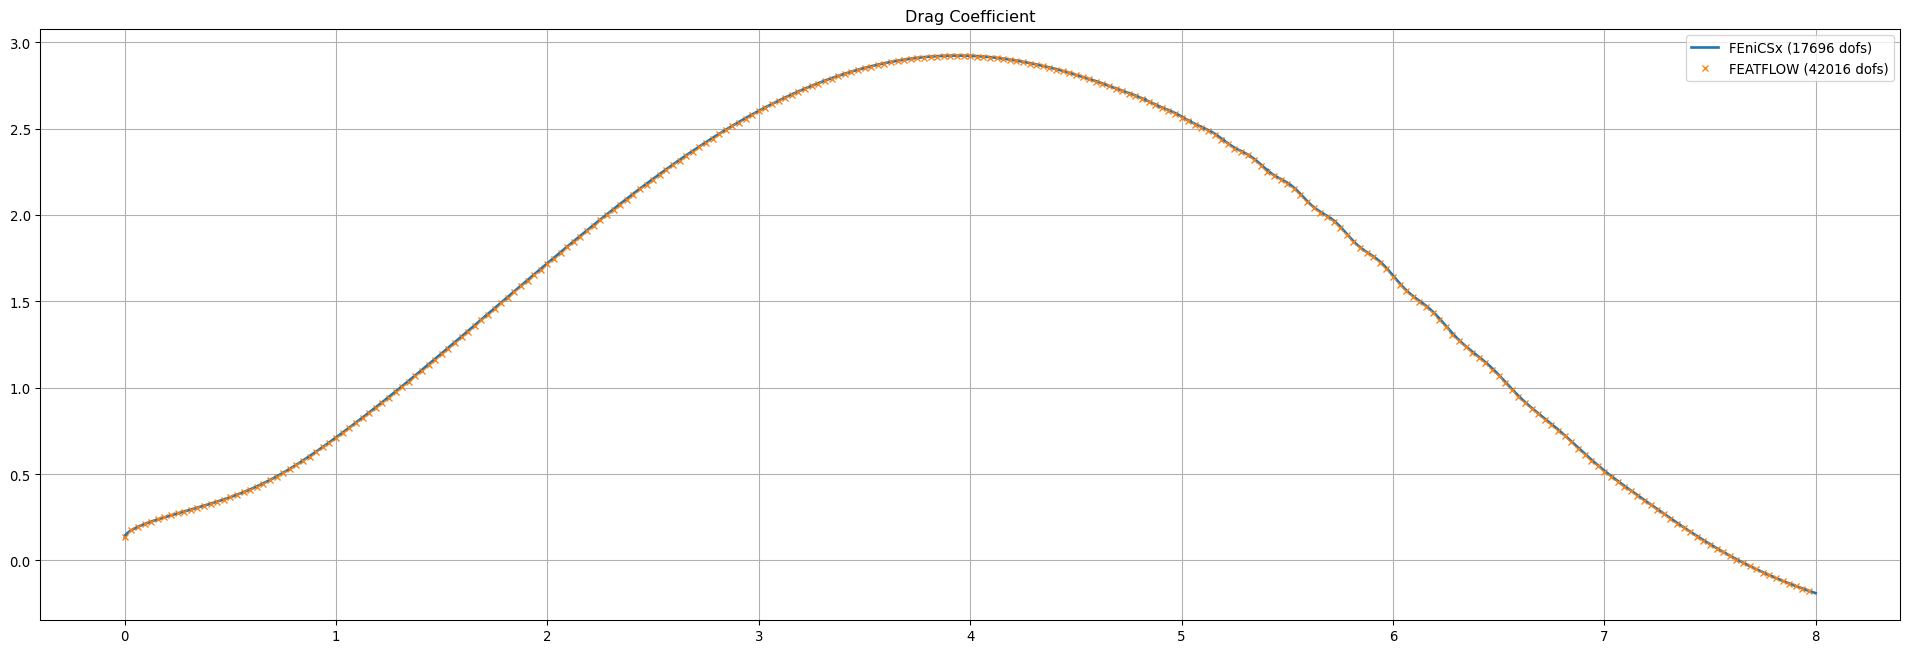

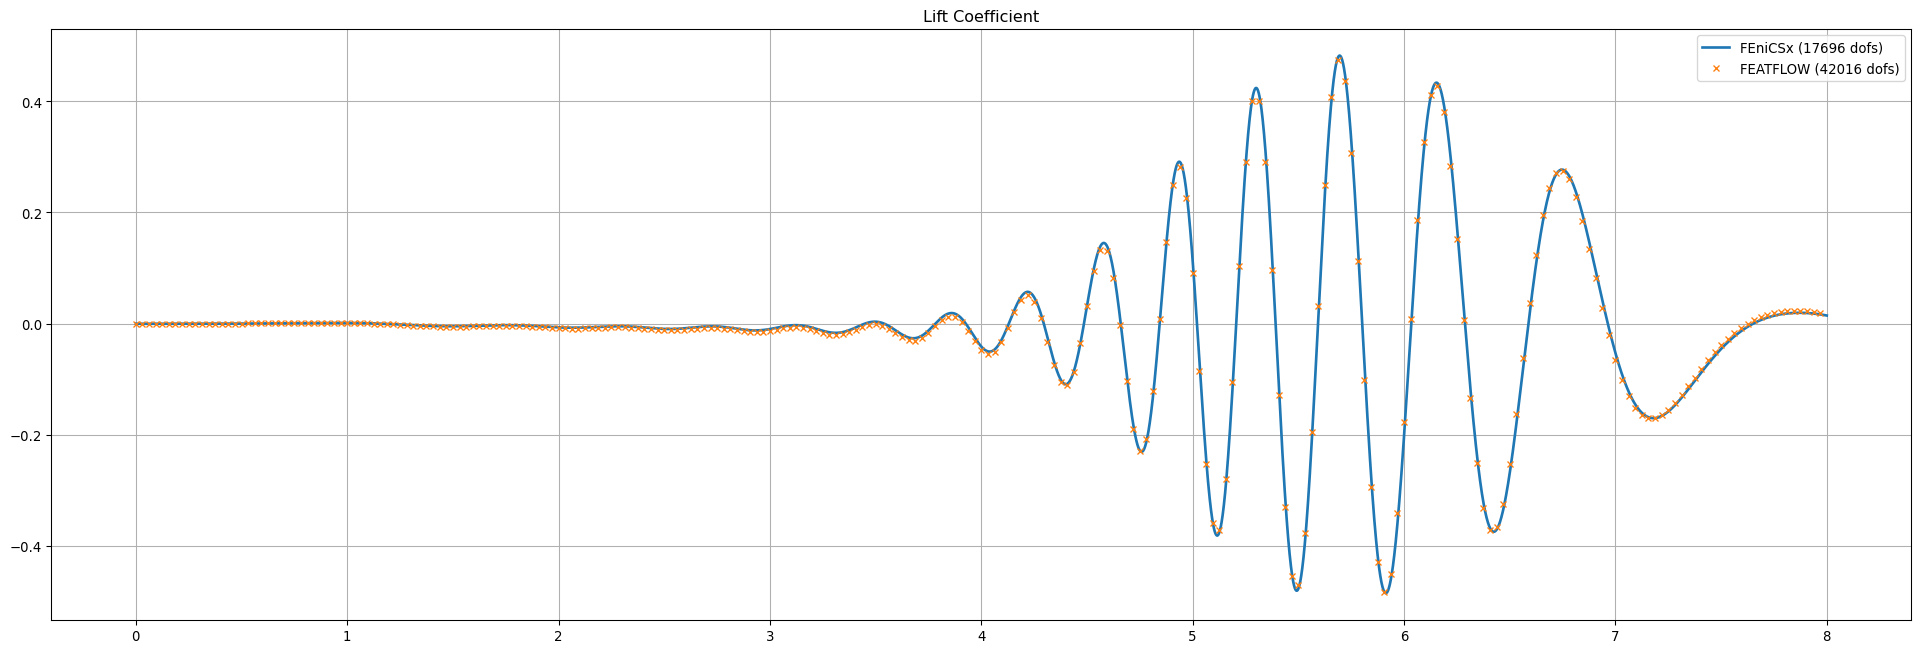

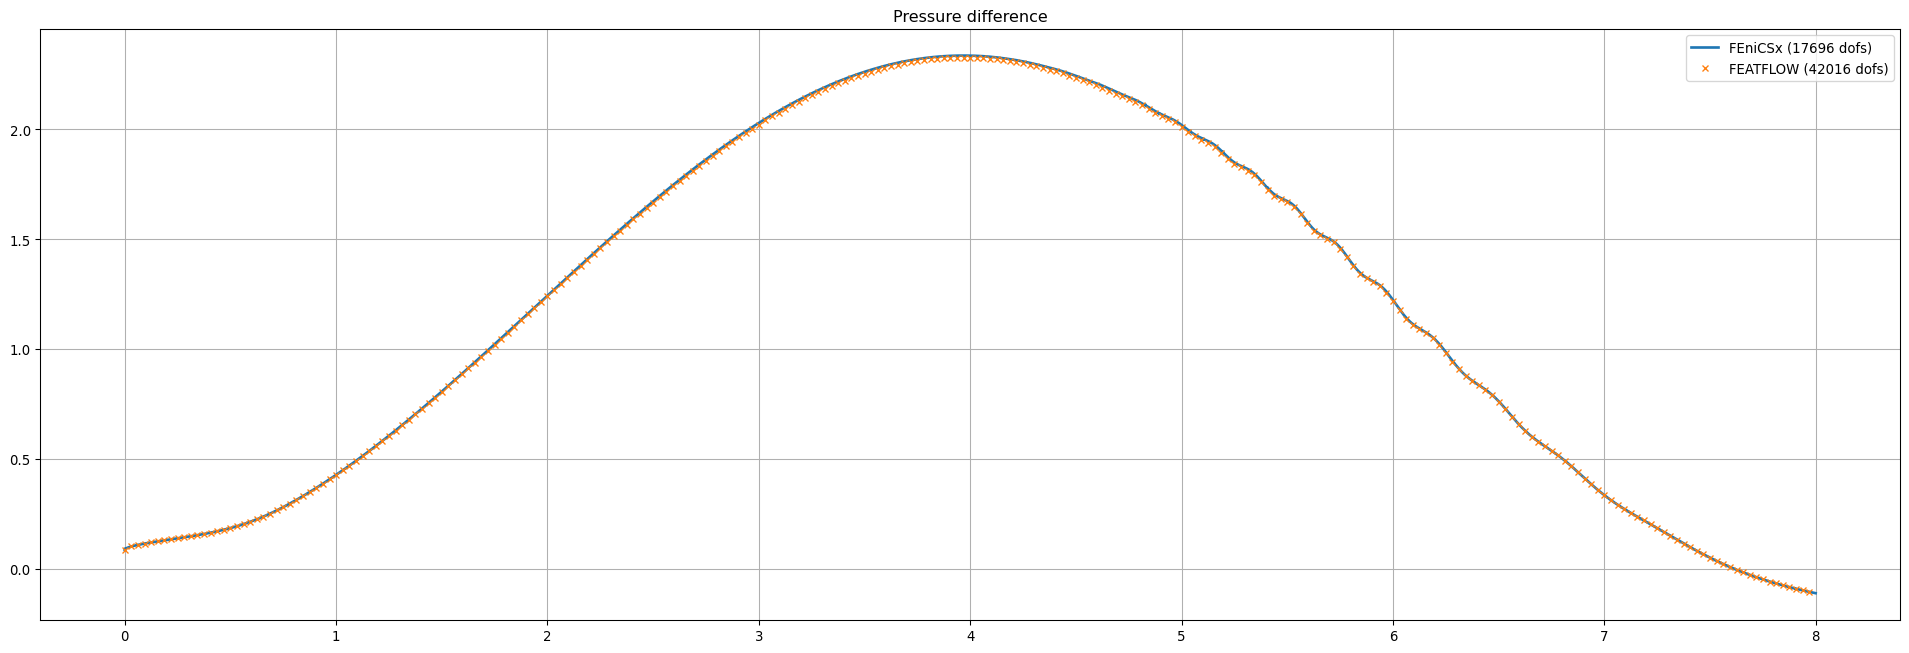

In [141]:
if mesh.comm.rank == 0:
  # Compute the total number of velocity degrees of freedom (DOFs)
  # - V.dofmap.index_map.size_global : global number of scalar DOFs
  # - V.dofmap.index_map_bs          : block size (e.g., 2 in 2D, 3 in 3D for vector spaces)
  #   → Total number of velocity DOFs = block size × scalar DOFs  
  num_velocity_dofs = V.dofmap.index_map_bs *V.dofmap.index_map.size_global

  # Compute the total number of pressure degrees of freedom (DOFs)
  # - Typically: Q.dofmap.index_map.size_global × Q.dofmap.index_map_bs
  #   (for scalar pressure spaces, block size = 1)
  num_pressure_dofs = Q.dofmap.index_map_bs *Q.dofmap.index_map.size_global

  turek = np.loadtxt(folder/"bdforces_lv4")
  turek_p = np.loadtxt(folder/"pointvalues_lv4")
  
  fig = plt.figure(figsize=(25, 8))

  l1 = plt.plot(
    t_u, C_D, 
    label=f"FEniCSx ({num_velocity_dofs +num_pressure_dofs:d} dofs)", linewidth=2
  )
  l2 = plt.plot(
    turek[1:, 1], turek[1:, 3], 
    marker="x", markevery=50, linestyle="", markersize=4, 
    label="FEATFLOW (42016 dofs)")

  plt.title("Drag Coefficient")
  plt.grid()
  plt.legend()
  plt.savefig(folder/"drag_comparison.png")
  plt.show()

  fig = plt.figure(figsize=(25, 8))

  l1 = plt.plot(
    t_u, C_L, 
    label=f"FEniCSx ({num_velocity_dofs +num_pressure_dofs:d} dofs)", linewidth=2
  )
  l2 = plt.plot(
    turek[1:, 1], turek[1:, 4], 
    marker="x", markevery=50, linestyle="", markersize=4, 
    label="FEATFLOW (42016 dofs)"
  )
  
  plt.title("Lift Coefficient")
  plt.grid()
  plt.legend()
  plt.savefig(folder/"lift_comparison.png")
  plt.show()  

  fig = plt.figure(figsize=(25, 8))

  l1 = plt.plot(
    t_p, p_diff, 
    label=f"FEniCSx ({num_velocity_dofs + num_pressure_dofs:d} dofs)", linewidth=2
  )
  l2 = plt.plot(
    turek[1:, 1], turek_p[1:, 6] -turek_p[1:, -1], 
    marker="x", markevery=50, linestyle="", markersize=4, 
    label="FEATFLOW (42016 dofs)"
  )
  
  plt.title("Pressure difference")
  plt.grid()
  plt.legend()
  plt.savefig(folder/"pressure_comparison.png")
  plt.show()

### Hyperelasticity

Author: Jørgen S. Dokken and Garth N. Wells

This section demonstrates how to solve the hyperelasticity problem for the deformation of a beam.
We also illustrate how to define a constant boundary condition for a vector function space

We begin by importing `DOLFINx` along with additional dependencies.
Next, we construct a slender cantilever composed of hexahedral elements and define the function space `V` for the unknown field

In [142]:
import numpy as np

from mpi4py import MPI
import pyvista

from dolfinx import fem, mesh, plot
from dolfinx import log, default_scalar_type
from dolfinx.fem.petsc import NonlinearProblem
from dolfinx.nls.petsc import NewtonSolver

import ufl

L = 20.0
domain = mesh.create_box(
  MPI.COMM_WORLD, 
  [[0.0, 0.0, 0.0], [L, 1, 1]], 
  [20, 5, 5], 
  mesh.CellType.hexahedron
)
V = fem.functionspace(domain, ("Lagrange", 2, (domain.geometry.dim, )))

We define two Python functions to identify the facets where boundary conditions should be applied

In [143]:
def left(x):
  return np.isclose(x[0], 0)

def right(x):
  return np.isclose(x[0], L)

fdim = domain.topology.dim -1
left_facets = mesh.locate_entities_boundary(domain, fdim, left)
right_facets = mesh.locate_entities_boundary(domain, fdim, right)

Next, we create a marker using these two functions

In [144]:
# Concatenate and sort the arrays based on facet indices
# Left facets are marked with ID 1, right facets with ID 2

# Combine the facet indices from the left and right boundary
marked_facets = np.hstack([left_facets, right_facets])

# Assign marker values: 1 for left facets, 2 for right facets
marked_values = np.hstack([
    np.full_like(left_facets, 1), 
    np.full_like(right_facets, 2)
])

# Sort facets (and corresponding marker values) by facet index
sorted_facets = np.argsort(marked_facets)

# Create a MeshTags object that stores the facet markers
# This will allow us to apply different boundary conditions
# depending on whether the facet belongs to the left or right boundary
facet_tag = mesh.meshtags(
    domain, fdim, 
    marked_facets[sorted_facets], 
    marked_values[sorted_facets]
)

We then create a function to prescribe the fixed boundary condition on the left side

In [145]:
u_bc = np.array((0,) *domain.geometry.dim, dtype=default_scalar_type)

To apply the boundary condition, we identify the degrees of freedom (dofs) associated with the facets marked by the `MeshTag`

In [146]:
left_dofs = fem.locate_dofs_topological(
  V, 
  facet_tag.dim, 
  facet_tag.find(1)
)
bcs = [fem.dirichletbc(u_bc, left_dofs, V)]

Next, we define the body force `B` on the reference configuration and the nominal (first Piola-Kirchhoff) traction `T`

In [147]:
B = fem.Constant(domain, default_scalar_type((0, 0, 0)))
T = fem.Constant(domain, default_scalar_type((0, 0, 0)))

We define the test and solution functions in the space $V$

In [148]:
v = ufl.TestFunction(V)
u = fem.Function(V)

We define the kinematic quantities relevant to the problem

In [149]:
# Spatial dimension
d = len(u)

# Identity tensor
I = ufl.variable(ufl.Identity(d))

# Deformation gradient
F = ufl.variable(I +ufl.grad(u))

# Right Cauchy-Green tensor
C = ufl.variable(F.T *F)

# Invariants of deformation tensors
Ic = ufl.variable(ufl.tr(C))
J = ufl.variable(ufl.det(F))

We define the elasticity model using the stored strain energy density function $\psi$, and derive the corresponding first Piola-Kirchhoff stress expression:

In [150]:
# Elasticity parameters
E = default_scalar_type(1.0e4)
nu = default_scalar_type(0.3)
mu = fem.Constant(domain, E /(2 *(1 +nu)))

lmbda = fem.Constant(domain, E *nu /((1 +nu) *(1 -2 *nu)))

# Stored strain energy density (compressible neo-Hookean model)
psi = (mu /2) *(Ic -3) -mu *ufl.ln(J) +(lmbda /2) *(ufl.ln(J))**2

# Stress - Hyper-elasticity
P = ufl.diff(psi, F)

::: callout-note
To illustrate the difference between linear elasticity and hyperelasticity, the following lines can be uncommented to solve the linear elasticity problem
:::

In [151]:
# P = 2.0 *mu *ufl.sym(ufl.grad(u)) +lmbda *ufl.tr(ufl.sym(ufl.grad(u))) *I

Define the variational form, including the traction integral over all facets marked with value 2. The quadrature degree for the integrals is set to 4

In [152]:
metadata = {"quadrature_degree": 4}
ds = ufl.Measure(
  "ds", 
  domain=domain, 
  subdomain_data=facet_tag, 
  metadata=metadata
)

dx = ufl.Measure(
  "dx", 
  domain=domain, 
  metadata=metadata
)

# Define form F (we want to find u such that F(u) = 0)
F = ufl.inner(ufl.grad(v), P) *dx -ufl.inner(v, B) *dx -ufl.inner(v, T) *ds(2)

As the variational form is nonlinear and written in residual form, we use the nonlinear problem class from `DOLFINx` to set up the structures required for a Newton solver

In [153]:
problem = NonlinearProblem(F, u, bcs)

and then create and configure the Newton solver

In [154]:
solver = NewtonSolver(domain.comm, problem)

# Set Newton solver options
solver.atol = 1e-8
solver.rtol = 1e-8
solver.convergence_criterion = "incremental"

We define a function to plot the solution at each time step

In [155]:
results_folder = Path("fenicsx/hyperelasticity")
results_folder.mkdir(exist_ok=True, parents=True)

plotter = pyvista.Plotter(off_screen=True)
plotter.open_gif(results_folder/"deformation.gif", fps=3)

topology, cells, geometry = plot.vtk_mesh(u.function_space)
function_grid = pyvista.UnstructuredGrid(topology, cells, geometry)

values = np.zeros((geometry.shape[0], 3))
values[:, :len(u)] = u.x.array.reshape(geometry.shape[0], len(u))
function_grid["u"] = values
function_grid.set_active_vectors("u")

# Warp mesh by deformation
warped = function_grid.warp_by_vector("u", factor=1)
warped.set_active_vectors("u")

# Add mesh to plotter and visualize
actor = plotter.add_mesh(
  warped, 
  show_edges=True, 
  lighting=False, 
  clim=[0, 10],
  scalar_bar_args={"vertical": True},
)

# Compute magnitude of displacement to visualize in GIF
Vs = fem.functionspace(domain, ("Lagrange", 2))
magnitude = fem.Function(Vs)

us = fem.Expression(
  ufl.sqrt(sum([u[i]**2 for i in range(len(u))])), 
  Vs.element.interpolation_points()
)
magnitude.interpolate(us)
warped["mag"] = magnitude.x.array

Finally, we solve the problem over multiple time steps, updating the traction in the z-direction

In [156]:
log.set_log_level(log.LogLevel.INFO)

tval0 = -1.5
for n in range(1, 10):
    T.value[2] = n *tval0
    
    num_its, converged = solver.solve(u)
    assert (converged)
    u.x.scatter_forward()
    print(f"Time step {n}, Number of iterations {num_its}, Load {T.value}")
    function_grid["u"][:, :len(u)] = u.x.array.reshape(geometry.shape[0], len(u))
    
    magnitude.interpolate(us)
    
    warped.set_active_scalars("mag")
    warped_n = function_grid.warp_by_vector(factor=1)
    warped.points[:, :] = warped_n.points
    warped.point_data["mag"][:] = magnitude.x.array
    
    plotter.update_scalar_bar_range([0, 10])
    plotter.write_frame()

plotter.close()

log.set_log_level(log.LogLevel.WARNING)

[2025-11-07 04:12:52.669] [info] PETSc Krylov solver starting to solve system.
[2025-11-07 04:12:54.740] [info] PETSc Krylov solver starting to solve system.
[2025-11-07 04:12:56.411] [info] Newton iteration 2: r (abs) = 22.245488847569664 (tol = 1e-08), r (rel) = 0.1342779422433199 (tol = 1e-08)


[2025-11-07 04:12:56.588] [info] PETSc Krylov solver starting to solve system.
[2025-11-07 04:12:58.304] [info] Newton iteration 3: r (abs) = 2.432613380788242 (tol = 1e-08), r (rel) = 0.01468371053942908 (tol = 1e-08)
[2025-11-07 04:12:58.479] [info] PETSc Krylov solver starting to solve system.
[2025-11-07 04:13:00.129] [info] Newton iteration 4: r (abs) = 4.431578720802735 (tol = 1e-08), r (rel) = 0.026749840185403984 (tol = 1e-08)
[2025-11-07 04:13:00.309] [info] PETSc Krylov solver starting to solve system.
[2025-11-07 04:13:02.027] [info] Newton iteration 5: r (abs) = 0.14418915583061978 (tol = 1e-08), r (rel) = 0.0008703527834971478 (tol = 1e-08)
[2025-11-07 04:13:02.200] [info] PETSc Krylov solver starting to solve system.
[2025-11-07 04:13:03.937] [info] Newton iteration 6: r (abs) = 0.02142394652831032 (tol = 1e-08), r (rel) = 0.00012931895874550384 (tol = 1e-08)


[2025-11-07 04:13:04.111] [info] PETSc Krylov solver starting to solve system.
[2025-11-07 04:13:05.823] [info] Newton iteration 7: r (abs) = 4.80066955935609e-06 (tol = 1e-08), r (rel) = 2.8977741700241697e-08 (tol = 1e-08)
[2025-11-07 04:13:06.003] [info] PETSc Krylov solver starting to solve system.
Time step 1, Number of iterations 8, Load [ 0.   0.  -1.5]
[2025-11-07 04:13:07.691] [info] Newton iteration 8: r (abs) = 2.6593315879693925e-11 (tol = 1e-08), r (rel) = 1.6052224153042273e-13 (tol = 1e-08)
[2025-11-07 04:13:07.691] [info] Newton solver finished in 8 iterations and 8 linear solver iterations.


[2025-11-07 04:13:07.972] [info] PETSc Krylov solver starting to solve system.
[2025-11-07 04:13:09.867] [info] PETSc Krylov solver starting to solve system.
[2025-11-07 04:13:11.557] [info] Newton iteration 2: r (abs) = 17.325417842770662 (tol = 1e-08), r (rel) = 0.11784222264969324 (tol = 1e-08)
[2025-11-07 04:13:11.732] [info] PETSc Krylov solver starting to solve system.
[2025-11-07 04:13:13.460] [info] Newton iteration 3: r (abs) = 5.148824037029388 (tol = 1e-08), r (rel) = 0.03502073508771889 (tol = 1e-08)
[2025-11-07 04:13:13.635] [info] PETSc Krylov solver starting to solve system.
[2025-11-07 04:13:15.285] [info] Newton iteration 4: r (abs) = 7.240032569659952 (tol = 1e-08), r (rel) = 0.0492444994866836 (tol = 1e-08)
[2025-11-07 04:13:15.458] [info] PETSc Krylov solver starting to solve system.


[2025-11-07 04:13:17.131] [info] Newton iteration 5: r (abs) = 0.7778888011215269 (tol = 1e-08), r (rel) = 0.0052909630307540366 (tol = 1e-08)
[2025-11-07 04:13:17.316] [info] PETSc Krylov solver starting to solve system.
[2025-11-07 04:13:19.036] [info] Newton iteration 6: r (abs) = 1.2552533144730293 (tol = 1e-08), r (rel) = 0.008537851260402308 (tol = 1e-08)
[2025-11-07 04:13:19.210] [info] PETSc Krylov solver starting to solve system.
[2025-11-07 04:13:20.912] [info] Newton iteration 7: r (abs) = 0.008495122949791085 (tol = 1e-08), r (rel) = 5.778124251724872e-05 (tol = 1e-08)
[2025-11-07 04:13:21.085] [info] PETSc Krylov solver starting to solve system.
[2025-11-07 04:13:22.757] [info] Newton iteration 8: r (abs) = 0.00019210705108344808 (tol = 1e-08), r (rel) = 1.3066537322098655e-06 (tol = 1e-08)
[2025-11-07 04:13:22.939] [info] PETSc Krylov solver starting to solve system.
Time step 2, Number of iterations 9, Load [ 0.  0. -3.]
[2025-11-07 04:13:24.628] [info] Newton iteration 

[2025-11-07 04:13:24.825] [info] PETSc Krylov solver starting to solve system.
[2025-11-07 04:13:26.695] [info] PETSc Krylov solver starting to solve system.


[2025-11-07 04:13:28.406] [info] Newton iteration 2: r (abs) = 10.001117239450483 (tol = 1e-08), r (rel) = 0.08874707904158333 (tol = 1e-08)
[2025-11-07 04:13:28.585] [info] PETSc Krylov solver starting to solve system.
[2025-11-07 04:13:30.297] [info] Newton iteration 3: r (abs) = 5.330258434852234 (tol = 1e-08), r (rel) = 0.04729920220952126 (tol = 1e-08)
[2025-11-07 04:13:30.476] [info] PETSc Krylov solver starting to solve system.
[2025-11-07 04:13:32.175] [info] Newton iteration 4: r (abs) = 11.990116721075117 (tol = 1e-08), r (rel) = 0.10639689655528227 (tol = 1e-08)


[2025-11-07 04:13:32.351] [info] PETSc Krylov solver starting to solve system.
[2025-11-07 04:13:34.072] [info] Newton iteration 5: r (abs) = 2.2970192412283055 (tol = 1e-08), r (rel) = 0.020383097536063585 (tol = 1e-08)
[2025-11-07 04:13:34.246] [info] PETSc Krylov solver starting to solve system.
[2025-11-07 04:13:35.949] [info] Newton iteration 6: r (abs) = 3.9023388069967275 (tol = 1e-08), r (rel) = 0.03462824825065298 (tol = 1e-08)
[2025-11-07 04:13:36.118] [info] PETSc Krylov solver starting to solve system.
[2025-11-07 04:13:37.787] [info] Newton iteration 7: r (abs) = 0.23653543302398086 (tol = 1e-08), r (rel) = 0.0020989483742786096 (tol = 1e-08)
[2025-11-07 04:13:37.964] [info] PETSc Krylov solver starting to solve system.
[2025-11-07 04:13:39.672] [info] Newton iteration 8: r (abs) = 0.04271420922498156 (tol = 1e-08), r (rel) = 0.0003790337830792644 (tol = 1e-08)


[2025-11-07 04:13:39.850] [info] PETSc Krylov solver starting to solve system.
[2025-11-07 04:13:41.546] [info] Newton iteration 9: r (abs) = 2.8779784817306148e-05 (tol = 1e-08), r (rel) = 2.553836513290955e-07 (tol = 1e-08)
[2025-11-07 04:13:41.724] [info] PETSc Krylov solver starting to solve system.
Time step 3, Number of iterations 10, Load [ 0.   0.  -4.5]
[2025-11-07 04:13:43.417] [info] Newton iteration 10: r (abs) = 6.077785953131127e-10 (tol = 1e-08), r (rel) = 5.393254948084079e-12 (tol = 1e-08)
[2025-11-07 04:13:43.417] [info] Newton solver finished in 10 iterations and 10 linear solver iterations.


[2025-11-07 04:13:43.615] [info] PETSc Krylov solver starting to solve system.
[2025-11-07 04:13:45.430] [info] PETSc Krylov solver starting to solve system.
[2025-11-07 04:13:47.126] [info] Newton iteration 2: r (abs) = 5.506929934734036 (tol = 1e-08), r (rel) = 0.06539183682426397 (tol = 1e-08)
[2025-11-07 04:13:47.308] [info] PETSc Krylov solver starting to solve system.
[2025-11-07 04:13:49.054] [info] Newton iteration 3: r (abs) = 26.248919589460577 (tol = 1e-08), r (rel) = 0.3116918295584109 (tol = 1e-08)
[2025-11-07 04:13:49.228] [info] PETSc Krylov solver starting to solve system.


[2025-11-07 04:13:50.925] [info] Newton iteration 4: r (abs) = 2.309270521316821 (tol = 1e-08), r (rel) = 0.027421347811341937 (tol = 1e-08)
[2025-11-07 04:13:51.144] [info] PETSc Krylov solver starting to solve system.
[2025-11-07 04:13:52.881] [info] Newton iteration 5: r (abs) = 14.056244490622522 (tol = 1e-08), r (rel) = 0.16691035785570413 (tol = 1e-08)
[2025-11-07 04:13:53.064] [info] PETSc Krylov solver starting to solve system.
[2025-11-07 04:13:54.790] [info] Newton iteration 6: r (abs) = 0.22277413322257641 (tol = 1e-08), r (rel) = 0.0026453232456209053 (tol = 1e-08)
[2025-11-07 04:13:54.967] [info] PETSc Krylov solver starting to solve system.
[2025-11-07 04:13:56.660] [info] Newton iteration 7: r (abs) = 0.28667052510539687 (tol = 1e-08), r (rel) = 0.0034040585992898666 (tol = 1e-08)


[2025-11-07 04:13:56.837] [info] PETSc Krylov solver starting to solve system.
[2025-11-07 04:13:58.540] [info] Newton iteration 8: r (abs) = 0.00032186938773632337 (tol = 1e-08), r (rel) = 3.822026198086344e-06 (tol = 1e-08)
[2025-11-07 04:13:58.718] [info] PETSc Krylov solver starting to solve system.
Time step 4, Number of iterations 9, Load [ 0.  0. -6.]
[2025-11-07 04:14:00.423] [info] Newton iteration 9: r (abs) = 2.637964780929628e-07 (tol = 1e-08), r (rel) = 3.132441569933224e-09 (tol = 1e-08)
[2025-11-07 04:14:00.423] [info] Newton solver finished in 9 iterations and 9 linear solver iterations.


[2025-11-07 04:14:00.624] [info] PETSc Krylov solver starting to solve system.
[2025-11-07 04:14:02.483] [info] PETSc Krylov solver starting to solve system.
[2025-11-07 04:14:04.190] [info] Newton iteration 2: r (abs) = 3.194619708234956 (tol = 1e-08), r (rel) = 0.04964789514888014 (tol = 1e-08)


[2025-11-07 04:14:04.369] [info] PETSc Krylov solver starting to solve system.
[2025-11-07 04:14:06.075] [info] Newton iteration 3: r (abs) = 7.714285832925293 (tol = 1e-08), r (rel) = 0.1198884653451208 (tol = 1e-08)
[2025-11-07 04:14:06.246] [info] PETSc Krylov solver starting to solve system.
[2025-11-07 04:14:07.966] [info] Newton iteration 4: r (abs) = 0.8508731194677975 (tol = 1e-08), r (rel) = 0.013223501786908416 (tol = 1e-08)
[2025-11-07 04:14:08.139] [info] PETSc Krylov solver starting to solve system.
[2025-11-07 04:14:09.858] [info] Newton iteration 5: r (abs) = 0.3714343524134822 (tol = 1e-08), r (rel) = 0.005772497344763917 (tol = 1e-08)


[2025-11-07 04:14:10.030] [info] PETSc Krylov solver starting to solve system.
[2025-11-07 04:14:11.661] [info] Newton iteration 6: r (abs) = 0.002150656410572117 (tol = 1e-08), r (rel) = 3.342356014961964e-05 (tol = 1e-08)
[2025-11-07 04:14:11.840] [info] PETSc Krylov solver starting to solve system.
[2025-11-07 04:14:13.504] [info] Newton iteration 7: r (abs) = 2.546067480793498e-06 (tol = 1e-08), r (rel) = 3.956868199446797e-08 (tol = 1e-08)
[2025-11-07 04:14:13.677] [info] PETSc Krylov solver starting to solve system.
Time step 5, Number of iterations 8, Load [ 0.   0.  -7.5]
[2025-11-07 04:14:15.389] [info] Newton iteration 8: r (abs) = 1.6857449626793708e-13 (tol = 1e-08), r (rel) = 2.619832618546621e-15 (tol = 1e-08)
[2025-11-07 04:14:15.389] [info] Newton solver finished in 8 iterations and 8 linear solver iterations.


[2025-11-07 04:14:15.585] [info] PETSc Krylov solver starting to solve system.
[2025-11-07 04:14:17.410] [info] PETSc Krylov solver starting to solve system.
[2025-11-07 04:14:19.085] [info] Newton iteration 2: r (abs) = 2.006488301405612 (tol = 1e-08), r (rel) = 0.0395622031385681 (tol = 1e-08)
[2025-11-07 04:14:19.263] [info] PETSc Krylov solver starting to solve system.
[2025-11-07 04:14:20.945] [info] Newton iteration 3: r (abs) = 4.609768229355378 (tol = 1e-08), r (rel) = 0.09089142806549969 (tol = 1e-08)


[2025-11-07 04:14:21.120] [info] PETSc Krylov solver starting to solve system.
[2025-11-07 04:14:22.825] [info] Newton iteration 4: r (abs) = 0.18537214300427624 (tol = 1e-08), r (rel) = 0.0036550077927837146 (tol = 1e-08)
[2025-11-07 04:14:23.002] [info] PETSc Krylov solver starting to solve system.
[2025-11-07 04:14:24.720] [info] Newton iteration 5: r (abs) = 0.02468800140561847 (tol = 1e-08), r (rel) = 0.00048677668641781437 (tol = 1e-08)
[2025-11-07 04:14:24.894] [info] PETSc Krylov solver starting to solve system.
[2025-11-07 04:14:26.534] [info] Newton iteration 6: r (abs) = 5.6925390491283854e-06 (tol = 1e-08), r (rel) = 1.1224056780100924e-07 (tol = 1e-08)
[2025-11-07 04:14:26.709] [info] PETSc Krylov solver starting to solve system.
Time step 6, Number of iterations 7, Load [ 0.  0. -9.]
[2025-11-07 04:14:28.409] [info] Newton iteration 7: r (abs) = 2.6204561860805414e-11 (tol = 1e-08), r (rel) = 5.166789154803981e-13 (tol = 1e-08)
[2025-11-07 04:14:28.409] [info] Newton solv

[2025-11-07 04:14:30.444] [info] PETSc Krylov solver starting to solve system.
[2025-11-07 04:14:32.100] [info] Newton iteration 2: r (abs) = 1.3850621350551318 (tol = 1e-08), r (rel) = 0.033662175723783674 (tol = 1e-08)
[2025-11-07 04:14:32.271] [info] PETSc Krylov solver starting to solve system.
[2025-11-07 04:14:34.009] [info] Newton iteration 3: r (abs) = 3.0373936052903123 (tol = 1e-08), r (rel) = 0.07381999312219266 (tol = 1e-08)
[2025-11-07 04:14:34.179] [info] PETSc Krylov solver starting to solve system.
[2025-11-07 04:14:35.834] [info] Newton iteration 4: r (abs) = 0.04123861973234785 (tol = 1e-08), r (rel) = 0.00100225226645253 (tol = 1e-08)
[2025-11-07 04:14:36.007] [info] PETSc Krylov solver starting to solve system.
Time step 7, Number of iterations 6, Load [  0.    0.  -10.5]


[2025-11-07 04:14:37.704] [info] Newton iteration 5: r (abs) = 0.00205056641006533 (tol = 1e-08), r (rel) = 4.983641172614961e-05 (tol = 1e-08)
[2025-11-07 04:14:37.881] [info] PETSc Krylov solver starting to solve system.
[2025-11-07 04:14:39.558] [info] Newton iteration 6: r (abs) = 1.7885886176830885e-08 (tol = 1e-08), r (rel) = 4.346937427728534e-10 (tol = 1e-08)
[2025-11-07 04:14:39.558] [info] Newton solver finished in 6 iterations and 6 linear solver iterations.


[2025-11-07 04:14:39.756] [info] PETSc Krylov solver starting to solve system.
[2025-11-07 04:14:41.583] [info] PETSc Krylov solver starting to solve system.
[2025-11-07 04:14:43.308] [info] Newton iteration 2: r (abs) = 1.0633648528364101 (tol = 1e-08), r (rel) = 0.031085002034186824 (tol = 1e-08)
[2025-11-07 04:14:43.481] [info] PETSc Krylov solver starting to solve system.
[2025-11-07 04:14:45.154] [info] Newton iteration 3: r (abs) = 2.0477031306171987 (tol = 1e-08), r (rel) = 0.05985984566901875 (tol = 1e-08)


[2025-11-07 04:14:45.331] [info] PETSc Krylov solver starting to solve system.
[2025-11-07 04:14:47.005] [info] Newton iteration 4: r (abs) = 0.008977192522240718 (tol = 1e-08), r (rel) = 0.0002624273757692741 (tol = 1e-08)
[2025-11-07 04:14:47.189] [info] PETSc Krylov solver starting to solve system.
[2025-11-07 04:14:48.922] [info] Newton iteration 5: r (abs) = 0.00016742178144130685 (tol = 1e-08), r (rel) = 4.894186978992472e-06 (tol = 1e-08)
[2025-11-07 04:14:49.094] [info] PETSc Krylov solver starting to solve system.
Time step 8, Number of iterations 6, Load [  0.   0. -12.]
[2025-11-07 04:14:50.747] [info] Newton iteration 6: r (abs) = 3.241819305822145e-11 (tol = 1e-08), r (rel) = 9.476705897053983e-13 (tol = 1e-08)
[2025-11-07 04:14:50.747] [info] Newton solver finished in 6 iterations and 6 linear solver iterations.
[2025-11-07 04:14:50.945] [info] PETSc Krylov solver starting to solve system.


[2025-11-07 04:14:52.836] [info] PETSc Krylov solver starting to solve system.
[2025-11-07 04:14:54.541] [info] Newton iteration 2: r (abs) = 0.898788614589174 (tol = 1e-08), r (rel) = 0.030966555717676078 (tol = 1e-08)
[2025-11-07 04:14:54.719] [info] PETSc Krylov solver starting to solve system.
[2025-11-07 04:14:56.416] [info] Newton iteration 3: r (abs) = 1.3835366517792282 (tol = 1e-08), r (rel) = 0.04766789890229271 (tol = 1e-08)
[2025-11-07 04:14:56.588] [info] PETSc Krylov solver starting to solve system.
[2025-11-07 04:14:58.249] [info] Newton iteration 4: r (abs) = 0.001850960693256602 (tol = 1e-08), r (rel) = 6.377236706003253e-05 (tol = 1e-08)
[2025-11-07 04:14:58.418] [info] PETSc Krylov solver starting to solve system.


[2025-11-07 04:15:00.138] [info] Newton iteration 5: r (abs) = 7.871830666129107e-06 (tol = 1e-08), r (rel) = 2.712133631490422e-07 (tol = 1e-08)
[2025-11-07 04:15:00.311] [info] PETSc Krylov solver starting to solve system.
Time step 9, Number of iterations 6, Load [  0.    0.  -13.5]
[2025-11-07 04:15:02.021] [info] Newton iteration 6: r (abs) = 4.498496771177386e-13 (tol = 1e-08), r (rel) = 1.549896701507776e-14 (tol = 1e-08)
[2025-11-07 04:15:02.021] [info] Newton solver finished in 6 iterations and 6 linear solver iterations.


![](fenicsx/hyperelasticity/deformation.gif)

---
jupyter: fenicsx
---

### The Helmholtz equation {#sec-fenicsx-helmholtz}

Author: Antonio Baiano Svizzero 

The study of computational acoustics is essential in fields such as noise, vibration, and harshness (NVH), noise control, and acoustic design. In this section, we focus on the theoretical foundations of the Helmholtz equation—which is valid for noise problems with harmonic time dependence—and its implementation in `FEniCSx` to compute the sound pressure in arbitrary acoustic systems

**The PDE problem**

The acoustic Helmholtz equation in its general form reads

$$
\begin{aligned}
\nabla^2 p + k^2 p = -j \omega \rho_0 q \quad\text{in } \Omega
\end{aligned}
$$

where $p$ is the complex acoustic pressure, $k$ the wavenumber, $\omega$ the angular frequency, $j$ the imaginary unit, and $q$ the volume velocity ($\mathrm{m^3/s}$) of a generic source field. In the case of a monopole source, $q$ can be written as

$$q = Q \, \delta(x_s, y_s, z_s)$$

where $\delta(x_s, y_s, z_s)$ is the three-dimensional Dirac delta function centered at the monopole location. This formulation allows the computation of the sound pressure field generated by any generic source distribution, while the monopole source provides a simple yet fundamental example for analytical and numerical studies in computational acoustics

In order to solve this problem with real-valued solvers in `FEniCSx`, we split the complex pressure into its real and imaginary parts:

$$p = p_r + j \, p_i$$

with $p_r$ and $p_i$ real-valued functions representing the real and imaginary components, respectively. Substituting this into the original equation and separating real and imaginary parts leads to two coupled real-valued PDEs:

$$\begin{aligned}
\nabla^2 p_r + k^2 p_r &= 0, \\
\nabla^2 p_i + k^2 p_i &= - \omega \, \rho_0 \, q,
\end{aligned}
\quad \text{in } \Omega$$

After splitting the complex pressure $p = p_r + j\, p_i$ into its real and imaginary parts, the boundary conditions are applied separately to $p_r$ and $p_i$:

* Dirichlet BC:

  $$p_r = \Re(\bar{p}), \quad p_i = \Im(\bar{p}) \quad \text{on } \partial\Omega_p$$

* Neumann BC:

  $$\frac{\partial p_r}{\partial n} = 0, \quad
    \frac{\partial p_i}{\partial n} = - \omega \, \rho_0 \, \bar{v}_n \quad \text{on } \partial\Omega_v$$

* Robin BC:

  $$\frac{\partial p_r}{\partial n} = 
      \frac{\omega \, \rho_0}{\bar{Z}} \, p_i, \quad
    \frac{\partial p_i}{\partial n} = -\frac{\omega \, \rho_0}{\bar{Z}} \, p_r \quad \text{on } \partial\Omega_Z$$

where $\bar{p}$ is the complex prescribed acoustic pressure at $\partial\Omega_p$,
$\bar{v}_n$ is the prescribed normal sound particle velocity at $\partial\Omega_v$, and
$\bar{Z}$ is the prescribed acoustic impedance at $\partial\Omega_Z$, with $n$ denoting the outward unit normal. In this context, the overbar notation is used to denote prescribed boundary quantities (known data) in order to distinguish them from the unknown fields. It should be emphasized that the overbar does not indicate a complex conjugate

This formulation allows the use of real-valued solvers while fully accounting for the effect of complex-valued boundary conditions in the Helmholtz problem

**Weak formulation in terms of real and imaginary parts**

\paragraph{Real–Imaginary split with complex impedance and complex normal velocity}
Let the complex source be

$$
q = q_r + j\,q_i,
$$

and let the (possibly complex) surface impedance and the prescribed normal velocity be

$$
\bar Z = Z_r + j\,Z_i,\qquad \bar v_n = v_{n,r} + j\,v_{n,i},
$$

with $Z_r,Z_i,v_{n,r},v_{n,i}\in\mathbb{R}$. Define $\Delta_Z = Z_r^2+Z_i^2$. Then

$$
\frac{j\,\omega\rho_0}{\bar Z}
= \frac{\omega\rho_0}{\Delta_Z}\bigl(Z_i + j\,Z_r\bigr)
$$

Multiplying the complex Helmholtz equation by a real test function $v \in \hat V$  and separating real and imaginary parts yields the following two real variational problems.

* Real part (for $p_r$):

$$
\begin{aligned}
\int_{\Omega} \nabla p_r \cdot \nabla v \,\mathrm{d}x
&- k^2 \int_{\Omega} p_r\,v\,\mathrm{d}x
+ \frac{\omega\rho_0}{\Delta_Z}\int_{\partial\Omega_Z} \bigl(Z_i p_r - Z_r p_i\bigr)\,v\,\mathrm{d}s \\
=& -\,\omega\rho_0\int_{\Omega} q_i\,v\,\mathrm{d}x
\;+\; \omega\rho_0\int_{\partial\Omega_v} v_{n,i}\,v\,\mathrm{d}s
\end{aligned}$$

* Imaginary part (for $p_i$):

$$
\begin{aligned}
\int_{\Omega} \nabla p_i \cdot \nabla v \,\mathrm{d}x
&- k^2 \int_{\Omega} p_i\,v\,\mathrm{d}x
+ \frac{\omega\rho_0}{\Delta_Z}\int_{\partial\Omega_Z} \bigl(Z_r p_r + Z_i p_i\bigr)\,v\,\mathrm{d}s \\
=& \;\omega\rho_0\int_{\Omega} q_r\,v\,\mathrm{d}x
\;-\; \omega\rho_0\int_{\partial\Omega_v} v_{n,r}\,v\,\mathrm{d}s
\end{aligned}$$

After solving these two coupled real systems for $p_r$ and $p_i$, the complex pressure is reconstructed as $p = p_r + \mathrm{i}\,p_i$, from which amplitude $|p|$, phase and derived quantities such as the Sound Pressure Level (SPL) can be computed

In this section, you will learn how to:

* Define acoustic velocity and impedance boundary conditions
* Compute the acoustic sound pressure for multiple frequencies
* Evaluate the SPL at a given microphone position

**Test problem**

As an example, we model a plane wave propagating through a tube.
Although this is a basic test case, the code can be extended to more complex problems requiring velocity and impedance boundary conditions

Finally, we create the mesh with `GMSH`, defining the physical groups for the velocity and impedance boundary conditions along with their respective tags

In [157]:
import gmsh

# ---------------------------------
# Create gmsh box and tag facets
# ---------------------------------

if not gmsh.isInitialized():
  gmsh.initialize()

# meshsize settings
meshsize = 0.02
gmsh.option.setNumber("Mesh.MeshSizeMin", meshsize)
gmsh.option.setNumber("Mesh.MeshSizeMax", meshsize)

# create geometry
L = 1.0
W = 0.1
H = 0.1

gdim = 3

box = gmsh.model.occ.addBox(0, 0, 0, L, W, H)
gmsh.model.occ.synchronize()

# Remove any existing physical groups with the same (dim, tag)
for dim, tag in gmsh.model.getPhysicalGroups():
  gmsh.model.removePhysicalGroups([(dim, tag)])

# get surfaces
surfaces = gmsh.model.getEntities(dim=2)

# tolerance for coordinate matching
tol = 1e-6

velocity_surfaces = []
impedance_surfaces = []

for (dim, tag) in surfaces:
  com = gmsh.model.occ.getCenterOfMass(dim, tag)
  x, y, z = com
  if abs(x -0.0) < tol:      # x = 0 face
    velocity_surfaces.append(tag)
  elif abs(x -L) < tol:      # x = L face
    impedance_surfaces.append(tag)

# setup physical groups
vol_tag = gmsh.model.addPhysicalGroup(3, [box], 1)
gmsh.model.setPhysicalName(3, vol_tag, "air_volume")

v_bc_tag = 2
Z_bc_tag = 3

if velocity_surfaces:
  gmsh.model.addPhysicalGroup(2, velocity_surfaces, v_bc_tag)
  gmsh.model.setPhysicalName(2, v_bc_tag, "velocity_BC") 
if impedance_surfaces:
  gmsh.model.addPhysicalGroup(2, impedance_surfaces, Z_bc_tag) 
  gmsh.model.setPhysicalName(2, Z_bc_tag, "impedance_BC")

# mesh generation
gmsh.model.mesh.generate(dim=3)

Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 10%] Meshing curve 2 (Line)
Info    : [ 20%] Meshing curve 3 (Line)
Info    : [ 30%] Meshing curve 4 (Line)
Info    : [ 40%] Meshing curve 5 (Line)
Info    : [ 50%] Meshing curve 6 (Line)
Info    : [ 60%] Meshing curve 7 (Line)
Info    : [ 60%] Meshing curve 8 (Line)
Info    : [ 70%] Meshing curve 9 (Line)
Info    : [ 80%] Meshing curve 10 (Line)
Info    : [ 90%] Meshing curve 11 (Line)
Info    : [100%] Meshing curve 12 (Line)
Info    : Done meshing 1D (Wall 0.000515833s, CPU 0.001154s)
Info    : Meshing 2D...
Info    : [  0%] Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : [ 20%] Meshing surface 2 (Plane, Frontal-Delaunay)
Info    : [ 40%] Meshing surface 3 (Plane, Frontal-Delaunay)
Info    : [ 60%] Meshing surface 4 (Plane, Frontal-Delaunay)
Info    : [ 70%] Meshing surface 5 (Plane, Frontal-Delaunay)
Info    : [ 90%] Meshing surface 6 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.0282209s

We then import the mesh generated by `Gmsh` with the `dolfinx.io.gmshio` function

In [158]:
import csv
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import pyvista

from mpi4py import MPI
from dolfinx import (
  fem,
  io,
  default_scalar_type,
  geometry,
  plot,
)
from dolfinx.fem.petsc import LinearProblem
import ufl

comm = MPI.COMM_WORLD
rank = comm.rank

mesh_data = io.gmshio.model_to_mesh(
  gmsh.model, 
  comm, 
  0, 
  gdim=3
)

domain, _, facet_tags = mesh_data

gmsh.finalize()

We define the function space for the unknowns $p_r$ and $p_i$. We also specify the boundary integration measure $ds$ using `ufl`

In [159]:
V = fem.functionspace(domain, ("Lagrange", 1))
ds = ufl.Measure("ds", domain=domain, subdomain_data=facet_tags)

In [160]:
results_folder = Path("fenicsx/helmholtz")
results_folder.mkdir(exist_ok=True, parents=True)

# Extract topology from mesh and create pyvista mesh
topology, cell_types, x = plot.vtk_mesh(V)
grid = pyvista.UnstructuredGrid(topology, cell_types, x)

plotter = pyvista.Plotter(off_screen=True)
plotter.add_mesh(grid, show_edges=True)
plotter.add_axes()

# if not pyvista.OFF_SCREEN:
#     plotter.show()

# HTML 저장
plotter.export_html(results_folder/"helmholtz_mesh.html")

```{=html}
<iframe src="fenicsx/helmholtz/helmholtz_mesh.html"
        width="100%" height="400px"
        style="border:none;">
</iframe>
```

**Boundary conditions**

We impose a velocity boundary condition of $v_n = 1.0 \times 10^{-5}$ at one end of the tube.
For simplicity, we omit the point source in this example (although it could be included using [`scifem`](https://github.com/scientificcomputing/scifem)).
At the opposite end of the tube, we prescribe an impedance $Z$ computed with the Delaney–Bazley model, assuming a layer of thickness $d = 0.01$ and a flow resistivity $\sigma = 1.5 \times 10^4$.
This choice of impedance—corresponding to a plane wave propagating in free field—produces a solution without reflections

The Delaney–Bazley model is used to compute the characteristic impedance and the wavenumber of the porous layer, which is treated as an equivalent fluid with complex-valued properties:

$$
\begin{aligned}
Z_c(\omega) &= \rho_0 c_0 \left[1 + 0.0571 X^{-0.754} - j\, 0.087 X^{-0.732}\right] \\
k_c(\omega) &= \frac{\omega}{c_0} \left[1 + 0.0978 X^{-0.700} - j\, 0.189 X^{-0.595}\right]
\end{aligned}
$$

where $X = \tfrac{\rho_0 f}{\sigma}$

Using these values, we can compute the surface impedance.
In the case of a rigid passive absorber mounted on a rigid wall, it is given by:

$$
Z_s = -j\, Z_c \cot(k_c d)
$$

Let’s create a function to calculate it

In [161]:
# Air parameters
rho0 = 1.225  # kg/m^3
c = 340       # m/s
p_ref = 2e-5

# Wall parameters
sigma = 1.5e4  # ***
d = 0.01       # ***

# Impedance calculation
def delany_bazley_layer(f, rho0, c, sigma, d):
  X = rho0 *f /sigma
  Zc = rho0 *c *(1 +0.0571 *(X**-0.754) -1j *0.087 *(X**-0.732))
  kc = 2 *np.pi *f /c *(1 +0.0978 *(X**-0.700) -1j *0.189 *(X**-0.595))
  Z_s = -1j *Zc *(1 /np.tan(kc *d))
  return Z_s

We define the value of the normal velocity at the first end of the tube.
Since we are going to compute a sound pressure spectrum, all frequency-dependent variables (i.e., $\omega$, $k$, $Z_r$ and $Z_i$) need to be updated within the frequency loop.
To enable this, we initialize them as `DOLFINx` constants

In [162]:
# sources (zero in this case)
q_r = fem.Constant(domain, 0.0)
q_i = fem.Constant(domain, 0.0)

# velocity boundary condition (real part only here)
v_nr = 1e-5  #***
v_ni = 0.0

# frequency-dependent variables
omega = fem.Constant(domain, default_scalar_type(0))
k = fem.Constant(domain, default_scalar_type(0))

Z_r = fem.Constant(domain, default_scalar_type(0))
Z_i = fem.Constant(domain, default_scalar_type(0))

# probe point at center
probe_points = np.array(
  [[L/2.0, W/2.0, H/2.0]], 
  dtype=np.float64
)
coords = V.tabulate_dof_coordinates().reshape((-1, domain.geometry.dim))
dof_indices = [
  int(np.argmin(np.linalg.norm(coords -p, axis=1))) for p in probe_points
]

**Variational formulation**

We can now write the variational formulation

In [163]:
p_r = ufl.TrialFunction(V)
p_i = ufl.TrialFunction(V)
v = ufl.TestFunction(V)

Delta_Z = Z_r**2 +Z_i**2
coef = omega *rho0 /Delta_Z

# bilinear forms
a_r = ( 
  (ufl.inner(ufl.grad(p_r), ufl.grad(v)) -k**2 *p_r *v) *ufl.dx 
  +coef *(Z_i *p_r -Z_r *p_i) *v *ds(3)
)

a_i = (
  (ufl.inner(ufl.grad(p_i), ufl.grad(v)) -k**2 *p_i *v) *ufl.dx
  +coef *(Z_r *p_r +Z_i *p_i) *v *ds(3)
)

# RHS (velocity BC only)
L_r = -omega *rho0 *q_i *v *ufl.dx +omega *rho0 *v_ni *v *ds(2)
L_i =  omega *rho0 *q_r *v *ufl.dx -omega *rho0 *v_nr *v *ds(2)

The `LinearProblem` class is used to set up the `PETSc` backend and assemble the system matrix and vector.
The solution is stored in a `dolfinx.fem.Function`, `p_r_fun` and `p_i_fun`

In [164]:
p_r_fun = fem.Function(V)
p_r_fun.name = "p_real"

p_i_fun = fem.Function(V)
p_i_fun.name = "p_imag"

problem_r = LinearProblem(
  a_r, L_r, u=p_r_fun,
  petsc_options={"ksp_type": "preonly", "pc_type": "lu"}
)
problem_i = LinearProblem(
  a_i, L_i, u=p_i_fun,
  petsc_options={"ksp_type": "preonly", "pc_type": "lu"}
)

**Frequency loop**

Finally, we implement the frequency loop. In this step, the frequency-dependent variables are updated and the system is solved for each frequency

In [165]:
# Output files
xdmf_real = io.XDMFFile(comm, results_folder/"p_real.xdmf", "w")
xdmf_imag = io.XDMFFile(comm, results_folder/"p_imag.xdmf", "w")
xdmf_real.write_mesh(domain)
xdmf_imag.write_mesh(domain)

csv_file = results_folder/"SPL_probes.csv"
if rank == 0:
  with open(csv_file, "w", newline="") as f_:
    writer = csv.writer(f_)
    writer.writerow(["freq_Hz", "SPL_probe_center_dB"])

# Discrete frequency range
freq = np.arange(10, 1000, 5)  # Hz
SPL_all = []

for f in freq:
  omega.value = 2 *np.pi *f    
  k.value = omega.value /c

  Zs = delany_bazley_layer(f, rho0, c, sigma, d)
  Z_r.value = Zs.real
  Z_i.value = Zs.imag
  
  Delta_Z = Z_r**2 + Z_i**2
  coef = omega *rho0 /Delta_Z

  problem_r.solve()
  problem_i.solve()

  xdmf_real.write_function(p_r_fun, float(f))
  xdmf_imag.write_function(p_i_fun, float(f))  

  p_r_fun.x.scatter_forward()
  p_i_fun.x.scatter_forward()

  pr_vals = p_r_fun.x.array
  pi_vals = p_i_fun.x.array
  probe_SPLs = []
  for idx in dof_indices:
    pr = pr_vals[idx]
    pi = pi_vals[idx]
    p_complex = pr +1j *pi

    spl_db = 20 *np.log10(np.abs(p_complex) /(np.sqrt(2) *p_ref))
    probe_SPLs.append(spl_db)

  all_probe_SPLs = comm.gather(probe_SPLs, root=0)
  if rank == 0:
    row = [float(f)] +all_probe_SPLs[0]
    with open(csv_file, "a", newline="") as f_:
      csv.writer(f_).writerow(row)

  SPL_all.append(probe_SPLs[0])
  if rank == 0:
    print(
      f"f: {f:.0f} Hz,",
      f"|p|(probe): {10**(SPL_all[-1] /20) *np.sqrt(2) *p_ref:.3e} Pa,",
      f"SPL: {SPL_all[-1]:.2f} dB"
    )

xdmf_real.close()
xdmf_imag.close()  

f: 10 Hz, |p|(probe): 2.232e-02 Pa, SPL: 57.94 dB
f: 15 Hz, |p|(probe): 1.490e-02 Pa, SPL: 54.43 dB
f: 20 Hz, |p|(probe): 1.120e-02 Pa, SPL: 51.95 dB
f: 25 Hz, |p|(probe): 8.984e-03 Pa, SPL: 50.04 dB
f: 30 Hz, |p|(probe): 7.513e-03 Pa, SPL: 48.49 dB
f: 35 Hz, |p|(probe): 6.467e-03 Pa, SPL: 47.18 dB
f: 40 Hz, |p|(probe): 5.686e-03 Pa, SPL: 46.07 dB
f: 45 Hz, |p|(probe): 5.082e-03 Pa, SPL: 45.09 dB
f: 50 Hz, |p|(probe): 4.602e-03 Pa, SPL: 44.23 dB
f: 55 Hz, |p|(probe): 4.212e-03 Pa, SPL: 43.46 dB
f: 60 Hz, |p|(probe): 3.890e-03 Pa, SPL: 42.77 dB
f: 65 Hz, |p|(probe): 3.620e-03 Pa, SPL: 42.14 dB
f: 70 Hz, |p|(probe): 3.391e-03 Pa, SPL: 41.58 dB
f: 75 Hz, |p|(probe): 3.195e-03 Pa, SPL: 41.06 dB


f: 80 Hz, |p|(probe): 3.025e-03 Pa, SPL: 40.58 dB
f: 85 Hz, |p|(probe): 2.878e-03 Pa, SPL: 40.15 dB
f: 90 Hz, |p|(probe): 2.748e-03 Pa, SPL: 39.75 dB
f: 95 Hz, |p|(probe): 2.634e-03 Pa, SPL: 39.38 dB
f: 100 Hz, |p|(probe): 2.533e-03 Pa, SPL: 39.04 dB
f: 105 Hz, |p|(probe): 2.442e-03 Pa, SPL: 38.72 dB
f: 110 Hz, |p|(probe): 2.361e-03 Pa, SPL: 38.43 dB
f: 115 Hz, |p|(probe): 2.288e-03 Pa, SPL: 38.16 dB
f: 120 Hz, |p|(probe): 2.220e-03 Pa, SPL: 37.90 dB
f: 125 Hz, |p|(probe): 2.158e-03 Pa, SPL: 37.65 dB
f: 130 Hz, |p|(probe): 2.099e-03 Pa, SPL: 37.41 dB
f: 135 Hz, |p|(probe): 2.040e-03 Pa, SPL: 37.16 dB
f: 140 Hz, |p|(probe): 1.979e-03 Pa, SPL: 36.90 dB
f: 145 Hz, |p|(probe): 1.909e-03 Pa, SPL: 36.59 dB
f: 150 Hz, |p|(probe): 1.820e-03 Pa, SPL: 36.17 dB


f: 155 Hz, |p|(probe): 1.681e-03 Pa, SPL: 35.48 dB
f: 160 Hz, |p|(probe): 1.390e-03 Pa, SPL: 33.83 dB
f: 165 Hz, |p|(probe): 1.664e-04 Pa, SPL: 15.39 dB
f: 170 Hz, |p|(probe): 5.048e-03 Pa, SPL: 45.03 dB
f: 175 Hz, |p|(probe): 2.958e-03 Pa, SPL: 40.39 dB
f: 180 Hz, |p|(probe): 2.619e-03 Pa, SPL: 39.33 dB
f: 185 Hz, |p|(probe): 2.489e-03 Pa, SPL: 38.89 dB
f: 190 Hz, |p|(probe): 2.429e-03 Pa, SPL: 38.68 dB
f: 195 Hz, |p|(probe): 2.404e-03 Pa, SPL: 38.59 dB
f: 200 Hz, |p|(probe): 2.399e-03 Pa, SPL: 38.57 dB
f: 205 Hz, |p|(probe): 2.409e-03 Pa, SPL: 38.61 dB
f: 210 Hz, |p|(probe): 2.431e-03 Pa, SPL: 38.69 dB
f: 215 Hz, |p|(probe): 2.464e-03 Pa, SPL: 38.80 dB
f: 220 Hz, |p|(probe): 2.507e-03 Pa, SPL: 38.95 dB


f: 225 Hz, |p|(probe): 2.560e-03 Pa, SPL: 39.13 dB
f: 230 Hz, |p|(probe): 2.623e-03 Pa, SPL: 39.35 dB
f: 235 Hz, |p|(probe): 2.698e-03 Pa, SPL: 39.59 dB
f: 240 Hz, |p|(probe): 2.785e-03 Pa, SPL: 39.87 dB
f: 245 Hz, |p|(probe): 2.887e-03 Pa, SPL: 40.18 dB
f: 250 Hz, |p|(probe): 3.004e-03 Pa, SPL: 40.52 dB
f: 255 Hz, |p|(probe): 3.140e-03 Pa, SPL: 40.91 dB
f: 260 Hz, |p|(probe): 3.297e-03 Pa, SPL: 41.33 dB
f: 265 Hz, |p|(probe): 3.481e-03 Pa, SPL: 41.80 dB
f: 270 Hz, |p|(probe): 3.697e-03 Pa, SPL: 42.32 dB
f: 275 Hz, |p|(probe): 3.951e-03 Pa, SPL: 42.90 dB
f: 280 Hz, |p|(probe): 4.255e-03 Pa, SPL: 43.55 dB
f: 285 Hz, |p|(probe): 4.622e-03 Pa, SPL: 44.27 dB
f: 290 Hz, |p|(probe): 5.074e-03 Pa, SPL: 45.08 dB


f: 295 Hz, |p|(probe): 5.639e-03 Pa, SPL: 45.99 dB
f: 300 Hz, |p|(probe): 6.365e-03 Pa, SPL: 47.04 dB
f: 305 Hz, |p|(probe): 7.328e-03 Pa, SPL: 48.27 dB
f: 310 Hz, |p|(probe): 8.663e-03 Pa, SPL: 49.72 dB
f: 315 Hz, |p|(probe): 1.063e-02 Pa, SPL: 51.50 dB
f: 320 Hz, |p|(probe): 1.381e-02 Pa, SPL: 53.78 dB
f: 325 Hz, |p|(probe): 1.981e-02 Pa, SPL: 56.91 dB
f: 330 Hz, |p|(probe): 3.527e-02 Pa, SPL: 61.92 dB
f: 335 Hz, |p|(probe): 1.646e-01 Pa, SPL: 75.30 dB
f: 340 Hz, |p|(probe): 6.128e-02 Pa, SPL: 66.72 dB
f: 345 Hz, |p|(probe): 2.578e-02 Pa, SPL: 59.20 dB
f: 350 Hz, |p|(probe): 1.632e-02 Pa, SPL: 55.22 dB
f: 355 Hz, |p|(probe): 1.194e-02 Pa, SPL: 52.51 dB
f: 360 Hz, |p|(probe): 9.415e-03 Pa, SPL: 50.45 dB


f: 365 Hz, |p|(probe): 7.778e-03 Pa, SPL: 48.79 dB
f: 370 Hz, |p|(probe): 6.632e-03 Pa, SPL: 47.40 dB
f: 375 Hz, |p|(probe): 5.786e-03 Pa, SPL: 46.22 dB
f: 380 Hz, |p|(probe): 5.136e-03 Pa, SPL: 45.18 dB
f: 385 Hz, |p|(probe): 4.623e-03 Pa, SPL: 44.27 dB
f: 390 Hz, |p|(probe): 4.207e-03 Pa, SPL: 43.45 dB
f: 395 Hz, |p|(probe): 3.864e-03 Pa, SPL: 42.71 dB
f: 400 Hz, |p|(probe): 3.576e-03 Pa, SPL: 42.04 dB
f: 405 Hz, |p|(probe): 3.332e-03 Pa, SPL: 41.42 dB
f: 410 Hz, |p|(probe): 3.122e-03 Pa, SPL: 40.86 dB
f: 415 Hz, |p|(probe): 2.940e-03 Pa, SPL: 40.34 dB
f: 420 Hz, |p|(probe): 2.780e-03 Pa, SPL: 39.85 dB
f: 425 Hz, |p|(probe): 2.638e-03 Pa, SPL: 39.40 dB
f: 430 Hz, |p|(probe): 2.511e-03 Pa, SPL: 38.97 dB


f: 435 Hz, |p|(probe): 2.397e-03 Pa, SPL: 38.56 dB
f: 440 Hz, |p|(probe): 2.292e-03 Pa, SPL: 38.18 dB
f: 445 Hz, |p|(probe): 2.196e-03 Pa, SPL: 37.80 dB
f: 450 Hz, |p|(probe): 2.104e-03 Pa, SPL: 37.43 dB
f: 455 Hz, |p|(probe): 2.017e-03 Pa, SPL: 37.06 dB
f: 460 Hz, |p|(probe): 1.930e-03 Pa, SPL: 36.68 dB
f: 465 Hz, |p|(probe): 1.841e-03 Pa, SPL: 36.27 dB
f: 470 Hz, |p|(probe): 1.745e-03 Pa, SPL: 35.81 dB
f: 475 Hz, |p|(probe): 1.636e-03 Pa, SPL: 35.24 dB
f: 480 Hz, |p|(probe): 1.500e-03 Pa, SPL: 34.49 dB
f: 485 Hz, |p|(probe): 1.316e-03 Pa, SPL: 33.35 dB
f: 490 Hz, |p|(probe): 1.029e-03 Pa, SPL: 31.22 dB
f: 495 Hz, |p|(probe): 4.823e-04 Pa, SPL: 24.63 dB
f: 500 Hz, |p|(probe): 1.079e-03 Pa, SPL: 31.63 dB


f: 505 Hz, |p|(probe): 6.165e-02 Pa, SPL: 66.77 dB
f: 510 Hz, |p|(probe): 5.665e-03 Pa, SPL: 46.03 dB
f: 515 Hz, |p|(probe): 3.850e-03 Pa, SPL: 42.68 dB
f: 520 Hz, |p|(probe): 3.277e-03 Pa, SPL: 41.28 dB
f: 525 Hz, |p|(probe): 3.005e-03 Pa, SPL: 40.53 dB
f: 530 Hz, |p|(probe): 2.855e-03 Pa, SPL: 40.08 dB
f: 535 Hz, |p|(probe): 2.768e-03 Pa, SPL: 39.81 dB
f: 540 Hz, |p|(probe): 2.719e-03 Pa, SPL: 39.66 dB
f: 545 Hz, |p|(probe): 2.697e-03 Pa, SPL: 39.59 dB
f: 550 Hz, |p|(probe): 2.694e-03 Pa, SPL: 39.58 dB
f: 555 Hz, |p|(probe): 2.708e-03 Pa, SPL: 39.62 dB
f: 560 Hz, |p|(probe): 2.736e-03 Pa, SPL: 39.71 dB
f: 565 Hz, |p|(probe): 2.778e-03 Pa, SPL: 39.84 dB
f: 570 Hz, |p|(probe): 2.833e-03 Pa, SPL: 40.01 dB


f: 575 Hz, |p|(probe): 2.901e-03 Pa, SPL: 40.22 dB
f: 580 Hz, |p|(probe): 2.985e-03 Pa, SPL: 40.47 dB
f: 585 Hz, |p|(probe): 3.084e-03 Pa, SPL: 40.75 dB
f: 590 Hz, |p|(probe): 3.201e-03 Pa, SPL: 41.07 dB
f: 595 Hz, |p|(probe): 3.338e-03 Pa, SPL: 41.44 dB
f: 600 Hz, |p|(probe): 3.500e-03 Pa, SPL: 41.85 dB
f: 605 Hz, |p|(probe): 3.690e-03 Pa, SPL: 42.31 dB
f: 610 Hz, |p|(probe): 3.915e-03 Pa, SPL: 42.82 dB
f: 615 Hz, |p|(probe): 4.182e-03 Pa, SPL: 43.40 dB
f: 620 Hz, |p|(probe): 4.504e-03 Pa, SPL: 44.04 dB
f: 625 Hz, |p|(probe): 4.895e-03 Pa, SPL: 44.76 dB
f: 630 Hz, |p|(probe): 5.380e-03 Pa, SPL: 45.58 dB
f: 635 Hz, |p|(probe): 5.992e-03 Pa, SPL: 46.52 dB
f: 640 Hz, |p|(probe): 6.786e-03 Pa, SPL: 47.60 dB


f: 645 Hz, |p|(probe): 7.853e-03 Pa, SPL: 48.87 dB
f: 650 Hz, |p|(probe): 9.358e-03 Pa, SPL: 50.39 dB
f: 655 Hz, |p|(probe): 1.163e-02 Pa, SPL: 52.28 dB
f: 660 Hz, |p|(probe): 1.545e-02 Pa, SPL: 54.75 dB
f: 665 Hz, |p|(probe): 2.319e-02 Pa, SPL: 58.27 dB
f: 670 Hz, |p|(probe): 4.702e-02 Pa, SPL: 64.41 dB
f: 675 Hz, |p|(probe): 1.206e+00 Pa, SPL: 92.60 dB
f: 680 Hz, |p|(probe): 4.325e-02 Pa, SPL: 63.69 dB
f: 685 Hz, |p|(probe): 2.194e-02 Pa, SPL: 57.80 dB
f: 690 Hz, |p|(probe): 1.468e-02 Pa, SPL: 54.30 dB
f: 695 Hz, |p|(probe): 1.102e-02 Pa, SPL: 51.81 dB
f: 700 Hz, |p|(probe): 8.813e-03 Pa, SPL: 49.87 dB
f: 705 Hz, |p|(probe): 7.343e-03 Pa, SPL: 48.29 dB
f: 710 Hz, |p|(probe): 6.295e-03 Pa, SPL: 46.95 dB


f: 715 Hz, |p|(probe): 5.510e-03 Pa, SPL: 45.79 dB
f: 720 Hz, |p|(probe): 4.900e-03 Pa, SPL: 44.77 dB
f: 725 Hz, |p|(probe): 4.414e-03 Pa, SPL: 43.87 dB
f: 730 Hz, |p|(probe): 4.017e-03 Pa, SPL: 43.05 dB
f: 735 Hz, |p|(probe): 3.687e-03 Pa, SPL: 42.30 dB
f: 740 Hz, |p|(probe): 3.408e-03 Pa, SPL: 41.62 dB
f: 745 Hz, |p|(probe): 3.169e-03 Pa, SPL: 40.99 dB
f: 750 Hz, |p|(probe): 2.962e-03 Pa, SPL: 40.40 dB
f: 755 Hz, |p|(probe): 2.781e-03 Pa, SPL: 39.85 dB
f: 760 Hz, |p|(probe): 2.620e-03 Pa, SPL: 39.33 dB
f: 765 Hz, |p|(probe): 2.475e-03 Pa, SPL: 38.84 dB
f: 770 Hz, |p|(probe): 2.344e-03 Pa, SPL: 38.37 dB
f: 775 Hz, |p|(probe): 2.223e-03 Pa, SPL: 37.91 dB
f: 780 Hz, |p|(probe): 2.110e-03 Pa, SPL: 37.45 dB


f: 785 Hz, |p|(probe): 2.002e-03 Pa, SPL: 37.00 dB
f: 790 Hz, |p|(probe): 1.897e-03 Pa, SPL: 36.53 dB
f: 795 Hz, |p|(probe): 1.793e-03 Pa, SPL: 36.04 dB
f: 800 Hz, |p|(probe): 1.684e-03 Pa, SPL: 35.50 dB
f: 805 Hz, |p|(probe): 1.567e-03 Pa, SPL: 34.87 dB
f: 810 Hz, |p|(probe): 1.435e-03 Pa, SPL: 34.11 dB
f: 815 Hz, |p|(probe): 1.276e-03 Pa, SPL: 33.09 dB
f: 820 Hz, |p|(probe): 1.071e-03 Pa, SPL: 31.57 dB
f: 825 Hz, |p|(probe): 7.809e-04 Pa, SPL: 28.82 dB
f: 830 Hz, |p|(probe): 3.158e-04 Pa, SPL: 20.96 dB
f: 835 Hz, |p|(probe): 5.912e-04 Pa, SPL: 26.40 dB
f: 840 Hz, |p|(probe): 3.254e-03 Pa, SPL: 41.22 dB
f: 845 Hz, |p|(probe): 2.715e-01 Pa, SPL: 79.65 dB
f: 850 Hz, |p|(probe): 7.706e-03 Pa, SPL: 48.71 dB


f: 855 Hz, |p|(probe): 4.893e-03 Pa, SPL: 44.76 dB
f: 860 Hz, |p|(probe): 3.978e-03 Pa, SPL: 42.96 dB
f: 865 Hz, |p|(probe): 3.534e-03 Pa, SPL: 41.93 dB
f: 870 Hz, |p|(probe): 3.280e-03 Pa, SPL: 41.29 dB
f: 875 Hz, |p|(probe): 3.123e-03 Pa, SPL: 40.86 dB
f: 880 Hz, |p|(probe): 3.025e-03 Pa, SPL: 40.58 dB
f: 885 Hz, |p|(probe): 2.965e-03 Pa, SPL: 40.41 dB
f: 890 Hz, |p|(probe): 2.934e-03 Pa, SPL: 40.32 dB
f: 895 Hz, |p|(probe): 2.924e-03 Pa, SPL: 40.29 dB
f: 900 Hz, |p|(probe): 2.933e-03 Pa, SPL: 40.31 dB
f: 905 Hz, |p|(probe): 2.958e-03 Pa, SPL: 40.39 dB
f: 910 Hz, |p|(probe): 2.999e-03 Pa, SPL: 40.51 dB
f: 915 Hz, |p|(probe): 3.054e-03 Pa, SPL: 40.67 dB


f: 920 Hz, |p|(probe): 3.126e-03 Pa, SPL: 40.87 dB
f: 925 Hz, |p|(probe): 3.215e-03 Pa, SPL: 41.11 dB
f: 930 Hz, |p|(probe): 3.321e-03 Pa, SPL: 41.39 dB
f: 935 Hz, |p|(probe): 3.448e-03 Pa, SPL: 41.72 dB
f: 940 Hz, |p|(probe): 3.599e-03 Pa, SPL: 42.09 dB
f: 945 Hz, |p|(probe): 3.778e-03 Pa, SPL: 42.51 dB
f: 950 Hz, |p|(probe): 3.989e-03 Pa, SPL: 42.99 dB
f: 955 Hz, |p|(probe): 4.242e-03 Pa, SPL: 43.52 dB
f: 960 Hz, |p|(probe): 4.545e-03 Pa, SPL: 44.12 dB
f: 965 Hz, |p|(probe): 4.914e-03 Pa, SPL: 44.80 dB
f: 970 Hz, |p|(probe): 5.368e-03 Pa, SPL: 45.57 dB
f: 975 Hz, |p|(probe): 5.938e-03 Pa, SPL: 46.44 dB
f: 980 Hz, |p|(probe): 6.671e-03 Pa, SPL: 47.45 dB
f: 985 Hz, |p|(probe): 7.644e-03 Pa, SPL: 48.64 dB


f: 990 Hz, |p|(probe): 8.993e-03 Pa, SPL: 50.05 dB
f: 995 Hz, |p|(probe): 1.098e-02 Pa, SPL: 51.78 dB


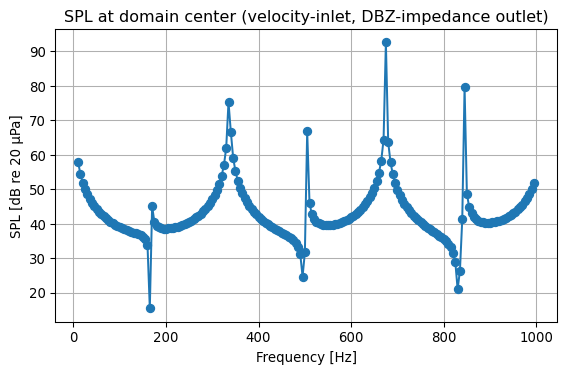

In [166]:
if rank == 0:
  plt.figure(figsize=(6, 4))

  plt.plot(freq, SPL_all, marker="o")
  
  plt.xlabel("Frequency [Hz]")
  plt.ylabel("SPL [dB re 20 µPa]")
  plt.title("SPL at domain center (velocity-inlet, DBZ-impedance outlet)")
  plt.grid(True)
  plt.tight_layout()
  plt.savefig(results_folder/"SPL_spectrum.png", dpi=150)
  
  plt.show()

---
jupyter: fenicsx
---

### Adaptive mesh refinement with GMSH/FEniCSx {#sec-fenicsx-adaptive-mesh}

In this section, we consider an adaptive mesh refinement method applied to the Laplace eigenvalue problem 

#### Solving the eigenvalue problem

We consider the Laplace eigenvalue problem with adaptive mesh refinement. The finite element discretization is performed using `dolfinx`, while `PETSc/SLEPc` are used for the linear algebra and eigenvalue solver. The geometry is generated with `GMSH`

**Problem definition**

We study the Laplace eigenvalue problem:

$$
-\Delta u = \lambda u \quad \text{in } \Omega,
\quad u = 0 \quad \text{on } \partial\Omega
$$

We use a variational formulation: $~$Find $(\lambda, u) \in \mathbb{R} \times V_h$ such that

$$
a(u, v) = \lambda m(u, v), \quad \forall v \in V_h
$$

with

$$
a(u, v) = \int_\Omega \nabla u \cdot \nabla v \, dx,
\quad
m(u, v) = \int_\Omega u v \, dx
$$

#### Adaptive mesh refinement

Adaptive mesh refinement improves solution accuracy by selectively refining elements where errors are largest. Two common approaches for eigenvalue problems are gradient-based and residual-based error estimation

**Gradient-based refinement**

Uses the magnitude of the solution gradient as an error indicator:

$$ \eta_K = \int_K |\nabla u_h| \, dx $$

* Advantages

  * Simple and computationally cheap
  * Works well for smooth solutions
  * Intuitive: large gradients suggest refinement needs

* Limitations

  * May over-refine in regions with naturally large gradients
  * Doesn't account for actual PDE residual
  * Less theoretically rigorous

**Residual-based refinement**

Uses the PDE residual and flux jumps across element boundaries:

$$\eta_K^2 = h_K^2 \|R_K\|_{L^2(K)}^2 + \frac{1}{2} \sum_{e \in \partial K} h_e \|J_e\|_{L^2(e)}^2$$​

where $R_K = \lambda_h u_h$  (interior residual) and $J_e = [\nabla u_h \cdot n]$ (flux jump) 

* Advantages

  * Theoretically rigorous error bound
  * Accounts for both interior and boundary contributions
  * Better handles singularities and discontinuities
  * More efficient refinement strategy

* Limitations

  * More complex implementation
  * Higher computational cost
  * Requires careful treatment of jumps

**Implementation tips**

  * Threshold selection: Use percentile-based marking (e.g., top 25%)
  * Scaling: Residual estimator naturally scales with mesh size
  * Stability: Ensure non-negative error indicators
  * Convergence: Monitor eigenvalue changes across refinement levels

Both methods provide effective adaptive strategies, with residual-based estimation offering superior theoretical foundations at the cost of implementation complexity

#### Implementation

We begin by importing the necessary packages:

In [167]:
import numpy as np
from pathlib import Path
from mpi4py import MPI
from petsc4py import PETSc
from slepc4py import SLEPc
import pyvista
import gmsh

from dolfinx import fem, mesh, plot, default_scalar_type
from dolfinx.fem.petsc import assemble_matrix, assemble_vector  # fenicsx 0.9.0
from dolfinx.mesh import create_unit_square, locate_entities_boundary, refine
from dolfinx.io import gmshio, XDMFFile
import ufl

In this section, we’ll go through a complete workflow for generating, converting, and visualizing 2D meshes—specifically a square, an L-shaped domain, and a Pac-Man shape—using `Gmsh`, `FEniCSx`, and `PyVista`

Once the meshes are ready, we’ll set up a helper function that solves the eigenvalue problem with `SLEPc` on a discretized domain

Next, we’ll run the adaptive mesh refinement (AMR) algorithm. To make visualization easier, we’ll also add a helper function that attaches the relevant data to the plotter at each refinement step

Finally, we’ll set up some parameters to check the convergence of the algorithm

In [168]:
class AdaptiveLaplaceEigenSolver:
    """
    Adaptive Laplace eigenvalue solver with visualization
    """
    
    def __init__(self, domain_type="unit_square", initial_mesh_size=0.1):
        self.domain_type = domain_type
        self.initial_mesh_size = initial_mesh_size
        self.mesh = None
        self.V = None

        self.eigenvalues = []
        self.eigenfunctions = []

        self.results_folder = Path("fenicsx/adaptive_mesh_refinement")
        self.results_folder.mkdir(exist_ok=True, parents=True)
        
        print(f"Initialized solver for {domain_type} domain")
        
    def create_domain(self):
        """Create computational domain"""
        if self.domain_type == "unit_square":
            self.mesh = create_unit_square(MPI.COMM_WORLD, 20, 20, mesh.CellType.triangle)
            print(f"Created unit square: {self._count_n_cells()} cells")
            
        elif self.domain_type == "l_shape":
            self._create_l_shape_domain()
            
        elif self.domain_type == "pacman":
            self._create_pacman_domain()
            
        else:
            raise ValueError(f"Unknown domain type: {self.domain_type}")

    def _count_n_cells(self):
        return self.mesh.topology.index_map(2).size_global
    
    def _create_l_shape_domain(self):
        """Create L-shaped domain using GMSH"""
        gmsh.initialize()
        gmsh.model.add("l_shape")
        
        try:
            # Create L-shape
            rect1 = gmsh.model.occ.addRectangle(0, 0, 0, 1, 1)
            rect2 = gmsh.model.occ.addRectangle(0, 1, 0, 1, 1)
            rect3 = gmsh.model.occ.addRectangle(1, 0, 0, 1, 1)
            
            # Fuse rectangles
            fused1, _ = gmsh.model.occ.fuse([(2, rect1)], [(2, rect2)])
            fused2, _ = gmsh.model.occ.fuse(fused1, [(2, rect3)])
            
            gmsh.model.occ.synchronize()
            
            # Add physical groups
            surfaces = gmsh.model.getEntities(2)
            if surfaces:
                gmsh.model.addPhysicalGroup(2, [s[1] for s in surfaces], 1)
                gmsh.model.setPhysicalName(2, 1, "LDomain")
            
            # Set mesh size
            gmsh.option.setNumber("Mesh.CharacteristicLengthMin", self.initial_mesh_size * 0.5)
            gmsh.option.setNumber("Mesh.CharacteristicLengthMax", self.initial_mesh_size * 2.0)
            gmsh.model.mesh.generate(2)
            
            # Convert to dolfinx
            self.mesh, ct, ft = gmshio.model_to_mesh(gmsh.model, MPI.COMM_WORLD, 0, gdim=2)
            
        finally:
            gmsh.finalize()
            
        print(f"Created L-shape: {self._count_n_cells()} cells")
    
    def _create_pacman_domain(self):
        """Create Pac-Man domain using GMSH"""
        gmsh.initialize()
        gmsh.model.add("pacman")
        
        try:
            # Create Pac-Man shape
            disk = gmsh.model.occ.addDisk(0, 0, 0, 1.0, 1.0)
            
            # Create mouth triangle
            angle_rad = np.radians(30)  # 30-degree mouth opening
            mouth_length = 1.2
            
            p1 = gmsh.model.occ.addPoint(0, 0, 0)
            p2 = gmsh.model.occ.addPoint(mouth_length * np.cos(angle_rad), 
                                       mouth_length * np.sin(angle_rad), 0)
            p3 = gmsh.model.occ.addPoint(mouth_length * np.cos(-angle_rad), 
                                       mouth_length * np.sin(-angle_rad), 0)
            
            l1 = gmsh.model.occ.addLine(p1, p2)
            l2 = gmsh.model.occ.addLine(p2, p3)  
            l3 = gmsh.model.occ.addLine(p3, p1)
            
            mouth_loop = gmsh.model.occ.addCurveLoop([l1, l2, l3])
            mouth_surface = gmsh.model.occ.addPlaneSurface([mouth_loop])
            
            # Cut mouth from disk
            pacman, _ = gmsh.model.occ.cut([(2, disk)], [(2, mouth_surface)])
            
            gmsh.model.occ.synchronize()
            
            # Add physical groups
            if pacman:
                dim, tag = pacman[0]
                gmsh.model.addPhysicalGroup(dim, [tag], 1)
                gmsh.model.setPhysicalName(dim, 1, "PacmanDomain")
            
            # Set mesh options
            gmsh.option.setNumber("Mesh.CharacteristicLengthMin", self.initial_mesh_size * 0.5)
            gmsh.option.setNumber("Mesh.CharacteristicLengthMax", self.initial_mesh_size * 2.0)
            gmsh.option.setNumber("Mesh.Algorithm", 6)  # Frontal-Delaunay
            gmsh.model.mesh.generate(2)
            
            # Convert to dolfinx
            self.mesh, ct, ft = gmshio.model_to_mesh(gmsh.model, MPI.COMM_WORLD, 0, gdim=2)
            
        finally:
            gmsh.finalize()
            
        print(f"Created Pac-Man: {self._count_n_cells()} cells")
    
    def solve_eigenvalue_problem(self, n_eigenvalues=6):
        """Solve eigenvalue problem on current mesh"""
        # Create function space
        self.V = fem.functionspace(self.mesh, ("Lagrange", 1))
        
        # Define variational forms
        u = ufl.TrialFunction(self.V)
        v = ufl.TestFunction(self.V)
        
        a = ufl.inner(ufl.grad(u), ufl.grad(v)) * ufl.dx  # Stiffness
        m = ufl.inner(u, v) * ufl.dx                      # Mass
        
        # Apply homogeneous Dirichlet boundary conditions
        boundary_facets = locate_entities_boundary(
            self.mesh, self.mesh.topology.dim-1, 
            lambda x: np.ones(x.shape[1], dtype=bool)  # All boundary
        )
        boundary_dofs = fem.locate_dofs_topological(self.V, self.mesh.topology.dim-1, boundary_facets)
        bc = fem.dirichletbc(default_scalar_type(0.0), boundary_dofs, self.V)
        
        # Assemble matrices
        A = assemble_matrix(fem.form(a), bcs=[bc])
        A.assemble()
        M = assemble_matrix(fem.form(m), bcs=[bc])
        M.assemble()
        
        # Solve using shift-invert
        eps = SLEPc.EPS().create(MPI.COMM_WORLD)
        eps.setOperators(A, M)
        eps.setProblemType(SLEPc.EPS.ProblemType.GHEP)
        
        # Set shift based on domain type
        if self.domain_type == "unit_square":
            shift = 15.0
        elif self.domain_type == "l_shape":
            shift = 2.0
        elif self.domain_type == "pacman":
            shift = 3.0
        
        st = eps.getST()
        st.setType(SLEPc.ST.Type.SINVERT)
        st.setShift(shift)
        
        eps.setWhichEigenpairs(SLEPc.EPS.Which.TARGET_MAGNITUDE)
        eps.setTarget(shift)
        eps.setDimensions(n_eigenvalues + 3)
        eps.setTolerances(1e-10, 3000)
        eps.setType(SLEPc.EPS.Type.KRYLOVSCHUR)
        
        eps.solve()
        
        # Extract results
        nconv = eps.getConverged()
        results = []
        
        for i in range(nconv):
            eigenval = eps.getEigenvalue(i).real
            if eigenval > shift * 0.8:  # Filter based on shift
                eigenvec = fem.Function(self.V)
                eps.getEigenvector(i, eigenvec.x.petsc_vec)
                eigenvec.x.scatter_forward()
                
                # Normalize
                norm = np.sqrt(eigenvec.x.petsc_vec.dot(eigenvec.x.petsc_vec))
                if norm > 1e-12:
                    eigenvec.x.petsc_vec.scale(1.0 / norm)
                
                results.append((eigenval, eigenvec))
        
        # Sort and store results
        results.sort(key=lambda x: x[0])
        self.eigenvalues = [r[0] for r in results[:n_eigenvalues]]
        self.eigenfunctions = [r[1] for r in results[:n_eigenvalues]]
        
        # Cleanup
        eps.destroy()
        A.destroy()
        M.destroy()
        
        return self.eigenvalues, self.eigenfunctions
    
    def gradient_estimate_error(self, eigenfunction, eigenvalue):
        """
        Estimate error using gradient-based indicator
        """
        # Create DG0 space for error indicators
        W = fem.functionspace(self.mesh, ("DG", 0))
        error_indicator = fem.Function(W)
        
        # Compute gradient magnitude as error indicator
        u_dg = ufl.TrialFunction(W)        
        v_dg = ufl.TestFunction(W)
  
        grad_u = ufl.grad(eigenfunction)
        grad_norm_expr = ufl.sqrt(ufl.inner(grad_u, grad_u))
        
        # Project gradient norm to DG0
        a_proj = ufl.inner(u_dg, v_dg) * ufl.dx
        L_proj = ufl.inner(grad_norm_expr, v_dg) * ufl.dx
        
        A_proj = assemble_matrix(fem.form(a_proj))
        A_proj.assemble()
        b_proj = assemble_vector(fem.form(L_proj))
        b_proj.assemble()
        
        # Solve projection
        solver = PETSc.KSP().create()
        solver.setOperators(A_proj)
        solver.setType(PETSc.KSP.Type.CG)
        solver.solve(b_proj, error_indicator.x.petsc_vec)
        
        A_proj.destroy()
        b_proj.destroy()
        solver.destroy()
        
        return error_indicator.x.array

    def residual_estimate_error(self, eigenfunction, eigenvalue):
        """
        Residual-based error estimator for eigenvalue problems
        
        η_K² = h_K² ||R_K||²_L²(K) + (1/2) Σ h_e ||J_e||²_L²(e)
        
        where:
        - R_K = λ_h u_h (interior residual, since -Δu_h = λ_h u_h)
        - J_e = [∇u_h · n] (jump in normal flux across interior facets)
        - h_K = cell diameter, h_e = facet size
        """
        # Create DG0 space for error indicators
        W = fem.functionspace(self.mesh, ("DG", 0))
        error_indicator = fem.Function(W)
        
        # Define test function and cell/facet measures
        w = ufl.TestFunction(W)
        h_K = ufl.CellDiameter(self.mesh)
        h_e = ufl.FacetArea(self.mesh)  # In 2D, this gives edge length
        n = ufl.FacetNormal(self.mesh)
        
        # Interior residual: R_K = λ_h * u_h 
        # (since the strong form is -Δu = λu, the residual is λu when Δu ≈ 0)
        R_K = eigenvalue * eigenfunction
        
        # Jump in normal flux: J_e = [∇u_h · n]
        grad_u = ufl.grad(eigenfunction)
        flux_jump = ufl.jump(grad_u, n)  # Jump across interior facets
        
        # Residual-based error estimator
        # Interior contribution: h_K² ||R_K||²
        interior_contrib = h_K**2 * R_K**2 * w * ufl.dx
        
        # Boundary contribution: (1/2) h_e ||J_e||²  
        # Note: ufl.dS integrates over interior facets only
        boundary_contrib = 0.5 * h_e * flux_jump**2 * ufl.avg(w) * ufl.dS
        
        # Total error estimator
        error_form = interior_contrib + boundary_contrib
        
        # Assemble the error estimator
        error_vector = assemble_vector(fem.form(error_form))
        error_vector.assemble()
        
        # Extract local error indicators and take square root
        # (since we computed η_K², we need sqrt to get η_K)
        error_indicators_squared = error_vector.array
        error_indicators = np.sqrt(np.maximum(error_indicators_squared, 0.0))  # Ensure non-negative
        
        return error_indicators        
    
    def adaptive_refinement(self, err_estimator='residual', n_iterations=4, refinement_fraction=0.25, n_eigenvalues=6):
        """
        Perform adaptive mesh refinement
        """
        print(f"\n{'='*60}")
        print(f"ADAPTIVE REFINEMENT for {self.domain_type.upper()}")
        print(f"{'='*60}")
        
        refinement_history = []
        
        for iteration in range(n_iterations):
            print(f"\n--- Iteration {iteration + 1}/{n_iterations} ---")
            
            # Solve eigenvalue problem
            eigenvalues, eigenfunctions = self.solve_eigenvalue_problem(n_eigenvalues)
            
            print(f"Mesh: {self._count_n_cells()} cells, "
                  f"DOFs: {self.V.dofmap.index_map.size_global}")
            
            # Display first few eigenvalues
            for i, eigenval in enumerate(eigenvalues[:3]):
                print(f"λ_{i+1} = {eigenval:.6f}")
            
            # Save current results
            self.save_iteration_results(iteration)
            
            # Estimate error for first eigenfunction
            if eigenfunctions:

                if err_estimator == 'residual':
                    error_indicators = self.residual_estimate_error(eigenfunctions[0], eigenvalues[0])
                elif err_estimator == 'gradient':
                    error_indicators = self.gradient_estimate_error(eigenfunctions[0], eigenvalues[0])
                
                # Mark cells for refinement
                threshold = np.percentile(error_indicators, (1 - refinement_fraction) * 100)
                cells_to_refine = np.where(error_indicators > threshold)[0]
                
                print(f"Refining {len(cells_to_refine)} cells (threshold: {threshold:.3f})")
                
                if len(cells_to_refine) == 0:
                    print("No cells to refine, stopping.")
                    break
                
                # Store history
                refinement_history.append({
                    'iteration': iteration + 1,
                    'n_cells': self._count_n_cells(),
                    'n_dofs': self.V.dofmap.index_map.size_global,
                    'eigenvalues': eigenvalues.copy(),
                    'error_max': error_indicators.max(),
                    'error_mean': error_indicators.mean()
                })
                
                # Refine mesh
                if iteration < n_iterations - 1:  # Don't refine on last iteration
                    refined_result = refine(self.mesh, cells_to_refine)
                    # In dolfinx 0.9.0, refine may return a tuple (mesh, cell_map, vertex_map, facet_map)
                    if isinstance(refined_result, tuple):
                        self.mesh = refined_result[0]  # Extract just the mesh
                    else:
                        self.mesh = refined_result
        
        # Final solve and save
        final_eigenvalues, final_eigenfunctions = self.solve_eigenvalue_problem(n_eigenvalues)
        self.save_final_results()
        self.print_convergence_summary(refinement_history)
        
        return refinement_history
    
    def save_iteration_results(self, iteration):
        """Save results for current iteration"""
        if not self.eigenvalues or not self.eigenfunctions:
            return
            
        # Save eigenvalues
        eigenval_file = self.results_folder / f"{self.domain_type}_eigenvalues_iter_{iteration}.txt"
        np.savetxt(eigenval_file, self.eigenvalues)
        
        # Save eigenfunctions to XDMF
        try:
            xdmf_file = self.results_folder / f"{self.domain_type}_eigenfunctions_iter_{iteration}.xdmf"
            with XDMFFile(self.mesh.comm, xdmf_file, "w") as file:
                file.write_mesh(self.mesh)
                for i, u in enumerate(self.eigenfunctions[:3]):
                    u.name = f"eigenmode_{i+1}"
                    file.write_function(u)
        except Exception as e:
            print(f"Could not save XDMF for iteration {iteration}: {e}")
    
    def save_final_results(self):
        """Save final results"""
        if not self.eigenvalues or not self.eigenfunctions:
            return
            
        # Save final eigenvalues
        final_eigenval_file = self.results_folder / f"{self.domain_type}_final_eigenvalues.txt"
        np.savetxt(final_eigenval_file, self.eigenvalues)
        
        # Save final eigenfunctions
        try:
            final_xdmf_file = self.results_folder / f"{self.domain_type}_final_eigenfunctions.xdmf"
            with XDMFFile(self.mesh.comm, final_xdmf_file, "w") as file:
                file.write_mesh(self.mesh)
                for i, u in enumerate(self.eigenfunctions):
                    u.name = f"final_eigenmode_{i+1}"
                    file.write_function(u)
        except Exception as e:
            print(f"Could not save final XDMF: {e}")
    
    def visualize_eigenmodes(self, max_modes=4, save_html=True, save_png=True):
        """
        Create beautiful visualizations of eigenmodes using PyVista
        """
        if not self.eigenfunctions:
            print("No eigenfunctions to visualize")
            return
        
        print(f"\nCreating visualizations for {len(self.eigenfunctions)} eigenmodes...")
        
        for i, (eigenval, eigenfunction) in enumerate(zip(self.eigenvalues[:max_modes], 
                                                         self.eigenfunctions[:max_modes])):
            try:
                # Create PyVista grid
                topology, cell_types, geometry = plot.vtk_mesh(self.V)
                grid = pyvista.UnstructuredGrid(topology, cell_types, geometry)
                grid.point_data["Eigenfunction"] = eigenfunction.x.array.real
                
                # Create beautiful plot
                plotter = pyvista.Plotter(off_screen=True, window_size=(1200, 800))
                
                # Add mesh with scalar field
                mesh_actor = plotter.add_mesh(
                    grid, 
                    scalars="Eigenfunction",
                    cmap="RdBu_r",
                    show_edges=True,
                    scalar_bar_args={
                        'title': f'Mode {i+1}\n',
                        'title_font_size': 14,
                        'label_font_size': 13,
                        'n_labels': 5,
                        'width': 0.6,
                        'height': 0.05,
                        'position_x': 0.2,
                        'position_y': 0.02
                    }
                )
                
                # Set camera and lighting
                plotter.view_xy()
                plotter.camera.zoom(1.1)
                
                # Add title
                plotter.add_text(
                    f'{self.domain_type.replace("_", " ").title()}: lambda_{i+1} = {eigenval:.6f}',
                    position='upper_left',
                    font_size=14,
                    color='black'
                )
                
                # Add mesh info
                plotter.add_text(
                    f'\n\nCells: {self._count_n_cells()}, '
                    f'DOFs: {self.V.dofmap.index_map.size_global}',
                    position='upper_left',#'lower_right',
                    font_size=9,
                    color='gray'
                )
                
                # Save visualizations
                if save_html:
                    html_file = self.results_folder / f"{self.domain_type}_mode_{i+1}.html"
                    plotter.export_html(html_file)
                
                if save_png:
                    png_file = self.results_folder / f"{self.domain_type}_mode_{i+1}.png"
                    plotter.screenshot(png_file, transparent_background=True)
                
                print(f"✓ Saved visualizations for mode {i+1}")
                
            except Exception as e:
                print(f"✗ Visualization error for mode {i+1}: {e}")
    
    def create_comparison_plot(self):
        """Create comparison plot of all eigenmodes"""
        if len(self.eigenfunctions) < 4:
            return
            
        try:
            # Create 2x2 subplot
            plotter = pyvista.Plotter(shape=(2, 2), off_screen=True, window_size=(1600, 1200))
            
            for i in range(min(4, len(self.eigenfunctions))):
                eigenval = self.eigenvalues[i]
                eigenfunction = self.eigenfunctions[i]
                
                # Create grid
                topology, cell_types, geometry = plot.vtk_mesh(self.V)
                grid = pyvista.UnstructuredGrid(topology, cell_types, geometry)
                grid.point_data["Eigenfunction"] = eigenfunction.x.array.real
                
                # Set subplot
                row, col = divmod(i, 2)
                plotter.subplot(row, col)
                
                plotter.add_mesh(
                    grid,
                    scalars="Eigenfunction", 
                    cmap="RdBu_r",
                    show_edges=False,
                    scalar_bar_args={
                        'title': f'Mode {i+1}\n',
                        'title_font_size': 14,
                        'label_font_size': 13,
                    }                    
                )
                
                plotter.add_text(
                    f'lambda_{i+1} = {eigenval:.4f}', 
                    position='upper_left',
                    font_size=14)
                plotter.view_xy()
                plotter.camera.zoom(0.95)
            
            # Save comparison
            comparison_file = self.results_folder / f"{self.domain_type}_comparison.png"
            plotter.screenshot(comparison_file)
            
            print(f"✓ Saved comparison plot: {comparison_file}")
            
        except Exception as e:
            print(f"✗ Comparison plot error: {e}")
    
    def print_convergence_summary(self, history):
        """Print convergence summary"""
        print(f"\n{'='*60}")
        print(f"CONVERGENCE SUMMARY - {self.domain_type.upper()}")
        print(f"{'='*60}")
        print("Iter | Cells | DOFs  | λ_1      | λ_2      | λ_3      | Error")
        print("-" * 60)
        
        for h in history:
            eigenvals = h['eigenvalues']
            print(f"{h['iteration']:4d} | {h['n_cells']:5d} | {h['n_dofs']:5d} | "
                  f"{eigenvals[0]:8.4f} | {eigenvals[1]:8.4f} | {eigenvals[2]:8.4f} | "
                  f"{h['error_max']:8.3e}")
        
        if history:
            final = history[-1]['eigenvalues']
            print(f"\nFinal eigenvalues:")
            for i, eigenval in enumerate(final[:6]):
                print(f"  λ_{i+1} = {eigenval:.8f}")

In [169]:
def run_complete_tests():
    """Run complete test suite with all domains"""
    domains = ["unit_square", "l_shape", "pacman"]
    
    for domain in domains:
        print(f"\n{'='*80}")
        print(f"TESTING {domain.upper()} DOMAIN")
        print(f"{'='*80}")
        
        try:
            # Create solver
            solver = AdaptiveLaplaceEigenSolver(domain_type=domain, initial_mesh_size=0.1)
            
            # Create domain
            solver.create_domain()
            
            # Run adaptive refinement
            history = solver.adaptive_refinement(
                err_estimator='residual', # or 'gradient'
                n_iterations=4, 
                refinement_fraction=0.25, 
                n_eigenvalues=6
            )
            
            # Create visualizations
            print(f"\nCreating visualizations for {domain}...")
            solver.visualize_eigenmodes(max_modes=4)
            solver.create_comparison_plot()
            
            print(f"✓ {domain} test completed successfully!")
            
        except Exception as e:
            print(f"✗ {domain} test failed: {e}")
            import traceback
            traceback.print_exc()

if __name__ == "__main__":
    run_complete_tests()


TESTING UNIT_SQUARE DOMAIN
Initialized solver for unit_square domain
Created unit square: 800 cells

ADAPTIVE REFINEMENT for UNIT_SQUARE

--- Iteration 1/4 ---
Mesh: 800 cells, DOFs: 441
λ_1 = 19.861105
λ_2 = 49.871661
λ_3 = 50.168029
Refining 200 cells (threshold: 0.003)

--- Iteration 2/4 ---
Mesh: 1377 cells, DOFs: 733
λ_1 = 19.830708
λ_2 = 49.802740
λ_3 = 49.881808
Refining 344 cells (threshold: 0.002)

--- Iteration 3/4 ---
Mesh: 2452 cells, DOFs: 1281
λ_1 = 19.810581
λ_2 = 49.696385
λ_3 = 49.793126
Refining 613 cells (threshold: 0.001)

--- Iteration 4/4 ---
Mesh: 4385 cells, DOFs: 2268
λ_1 = 19.770349
λ_2 = 49.537673
λ_3 = 49.561696
Refining 1096 cells (threshold: 0.000)



CONVERGENCE SUMMARY - UNIT_SQUARE
Iter | Cells | DOFs  | λ_1      | λ_2      | λ_3      | Error
------------------------------------------------------------
   1 |   800 |   441 |  19.8611 |  49.8717 |  50.1680 | 5.218e-03
   2 |  1377 |   733 |  19.8307 |  49.8027 |  49.8818 | 3.736e-03
   3 |  2452 |  1281 |  19.8106 |  49.6964 |  49.7931 | 2.560e-03
   4 |  4385 |  2268 |  19.7703 |  49.5377 |  49.5617 | 1.934e-03

Final eigenvalues:
  λ_1 = 19.77034867
  λ_2 = 49.53767254
  λ_3 = 49.56169589
  λ_4 = 79.47168019
  λ_5 = 99.49882125
  λ_6 = 99.52280091

Creating visualizations for unit_square...

Creating visualizations for 6 eigenmodes...


✓ Saved visualizations for mode 1


✓ Saved visualizations for mode 2


✓ Saved visualizations for mode 3


✓ Saved visualizations for mode 4


✓ Saved comparison plot: fenicsx/adaptive_mesh_refinement/unit_square_comparison.png
✓ unit_square test completed successfully!

TESTING L_SHAPE DOMAIN
Initialized solver for l_shape domain
Info    : Cannot bind existing OpenCASCADE surface 1 to second tag 2
Info    : Could not preserve tag of 2D object 2 (->1)
Info    : Cannot bind existing OpenCASCADE surface 1 to second tag 3
Info    : Could not preserve tag of 2D object 3 (->1)
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 10 (Line)
Info    : [ 20%] Meshing curve 11 (Line)
Info    : [ 40%] Meshing curve 12 (TrimmedCurve)
Info    : [ 60%] Meshing curve 13 (TrimmedCurve)
Info    : [ 70%] Meshing curve 14 (Line)
Info    : [ 90%] Meshing curve 15 (TrimmedCurve)
Info    : Done meshing 1D (Wall 0.000262208s, CPU 0.000487s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.00223804s, CPU 0.003844s)
Info    : 117 nodes 238 elements
Created L-shape: 192 cells

ADAPTIVE R

✓ Saved visualizations for mode 1


✓ Saved visualizations for mode 2


✓ Saved visualizations for mode 3


✓ Saved visualizations for mode 4


✓ Saved comparison plot: fenicsx/adaptive_mesh_refinement/l_shape_comparison.png
✓ l_shape test completed successfully!

TESTING PACMAN DOMAIN
Initialized solver for pacman domain
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 40%] Meshing curve 2 (Line)
Info    : [ 70%] Meshing curve 3 (Ellipse)
Info    : Done meshing 1D (Wall 0.000138292s, CPU 0.000267s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.00196588s, CPU 0.003527s)
Info    : 106 nodes 213 elements
Created Pac-Man: 173 cells

ADAPTIVE REFINEMENT for PACMAN

--- Iteration 1/4 ---
Mesh: 173 cells, DOFs: 106
λ_1 = 11.443015
λ_2 = 17.443094
λ_3 = 25.203978
Refining 43 cells (threshold: 0.045)

--- Iteration 2/4 ---
Mesh: 309 cells, DOFs: 178
λ_1 = 11.210718
λ_2 = 17.344920
λ_3 = 24.855278
Refining 77 cells (threshold: 0.018)

--- Iteration 3/4 ---
Mesh: 548 cells, DOFs: 301
λ_1 = 11.145025
λ_2 = 17.288168
λ_3 = 24.746407
Refining 137 c

✓ Saved visualizations for mode 1


✓ Saved visualizations for mode 2


✓ Saved visualizations for mode 3


✓ Saved visualizations for mode 4


✓ Saved comparison plot: fenicsx/adaptive_mesh_refinement/pacman_comparison.png
✓ pacman test completed successfully!


![](fenicsx/adaptive_mesh_refinement/unit_square_comparison.png)

```{=html}
<iframe src="fenicsx/adaptive_mesh_refinement/unit_square_mode_1.html"
        width="100%" height="400px"
        style="border:none;">
</iframe>
```

![](fenicsx/adaptive_mesh_refinement/l_shape_comparison.png)

```{=html}
<iframe src="fenicsx/adaptive_mesh_refinement/l_shape_mode_1.html"
        width="100%" height="400px"
        style="border:none;">
</iframe>
```

![](fenicsx/adaptive_mesh_refinement/pacman_comparison.png)

```{=html}
<iframe src="fenicsx/adaptive_mesh_refinement/pacman_mode_1.html"
        width="100%" height="400px"
        style="border:none;">
</iframe>
```


## Subdomains and boundary conditions

### Combining Dirichlet and Neumann conditions

Author: Jørgen S. Dokken

Let us return to the Poisson problem and explore how to extend both the mathematical formulation and the implementation to handle a Dirichlet condition in combination with a Neumann condition.
The domain is still the unit square, but this time we impose the Dirichlet condition `u = u_D` on the left and right boundaries, while the Neumann condition

$$-\frac{\partial u}{\partial n} = g$$

is applied to the remaining boundaries, $y = 0$ and $y = 1$

**The PDE problem**

Let $\Lambda_D$ and $\Lambda_N$ denote the portions of the boundary $\partial \Omega$ where the Dirichlet and Neumann conditions are prescribed, respectively.
The full boundary-value problem is then given by

$$
\begin{aligned}
-\nabla^2 u &= f \quad \text{in } \Omega \\
u &= u_D \quad \text{on } \Lambda_D \\
-\frac{\partial u}{\partial n} &= g \quad \text{on } \Lambda_N
\end{aligned}
$$

As before, we choose $u = 1 + x^2 + 2y^2$ as the exact solution and then set $f$, $g$, and $u_D$ to match this choice

$$
\begin{aligned}
    f(x,y) &=-6 \\
    u_D(x,y) &=1+x^2+2y^2 \\
    g(x,y) &=
    \begin{cases}
        \phantom{-}0, & y=0\\
        -4, & y=1
    \end{cases}
\end{aligned}
$$

To simplify the implementation, we define $g$ as a function over the whole domain $\Omega$, making sure it has the correct values at $y=0$ and $y=1$. One possible choice is

$$
 g(x,y)=-4y
$$

**The variational formulation**

The first step is to derive the variational formulation. In this case, the boundary term resulting from integration by parts cannot be omitted, since $v$ vanishes only on $\Lambda_D$. We obtain

$$-\int_\Omega (\nabla^2 u)\, v \,\mathrm{d}x \;=\; \int_\Omega \nabla u \cdot \nabla v \,\mathrm{d}x \;-\; \int_{\partial \Omega}\frac{\partial u}{\partial n} v \,\mathrm{d}s$$

and because $v=0$ on $\Lambda_D$, it follows that

$$-\int_{\partial \Omega}\frac{\partial u}{\partial n} v \,\mathrm{d}s \;=\; - \int_{\Lambda_N}\frac{\partial u}{\partial n} v \,\mathrm{d}s \;=\; \int_{\Lambda_N} g v \,\mathrm{d}s$$

by applying the boundary condition on $\Lambda_N$.
The resulting weak form is therefore

$$\int_\Omega \nabla u \cdot \nabla v \,\mathrm{d}x \;=\; \int_\Omega f v \,\mathrm{d}x \;-\; \int_{\Lambda_N} g v \,\mathrm{d}s$$

Expressing this equation in the standard notation $a(u,v) = L(v)$, we have

$$\begin{aligned}
a(u,v) &= \int_\Omega \nabla u \cdot \nabla v \,\mathrm{d}x \\
L(v) &= \int_\Omega f v \,\mathrm{d}x \;-\; \int_{\Lambda_N} g v \,\mathrm{d}s
\end{aligned}$$

**Implementation**

As in the previous example, we start by defining the mesh, the function space, and the bilinear form $a(u,v)$

In [170]:
import numpy as np

from mpi4py import MPI
import pyvista

from dolfinx import default_scalar_type
from dolfinx.fem import (Constant, Function, functionspace,
  assemble_scalar, dirichletbc, form, locate_dofs_geometrical)
from dolfinx.fem.petsc import LinearProblem
from dolfinx.mesh import create_unit_square
from dolfinx.plot import vtk_mesh

from ufl import SpatialCoordinate, TestFunction, TrialFunction, dot, ds, dx, grad

mesh = create_unit_square(MPI.COMM_WORLD, 10, 10)

V = functionspace(mesh, ("Lagrange", 1))
u = TrialFunction(V)
v = TestFunction(V)

a = dot(grad(u), grad(v)) *dx

Now we turn to the Neumann and Dirichlet boundary conditions. As before, we use a Python function to mark the part of the boundary where the Dirichlet condition should apply. With this function, we can then identify the corresponding degrees of freedom that satisfy the condition

In [171]:
def u_exact(x):
  return 1 +x[0]**2 +2 *x[1]**2

def boundary_D(x):
  return np.logical_or(np.isclose(x[0], 0), np.isclose(x[0], 1))

dofs_D = locate_dofs_geometrical(V, boundary_D)

u_bc = Function(V)
u_bc.interpolate(u_exact)
bc = dirichletbc(u_bc, dofs_D)

The next step is to define the Neumann condition. We begin by defining $g$ using `UFL`’s `SpatialCoordinate` function, and then create a boundary integration measure `ds`. Since the test function $v$ vanishes on the Dirichlet boundary, the corresponding integrals drop out. This allows us to simply integrate `g *v *ds` over the entire boundary

In [172]:
f = Constant(mesh, default_scalar_type(-6))

x = SpatialCoordinate(mesh)
g = -4 *x[1]

L = f *v *dx -g *v *ds

At this stage, we are ready to assemble the linear system and solve it

In [173]:
problem = LinearProblem(
    a, 
    L, 
    bcs=[bc], 
    petsc_options={
        "ksp_type": "preonly", 
        "pc_type": "lu"}
)

uh = problem.solve()

V2 = functionspace(mesh, ("Lagrange", 2))
uex = Function(V2)
uex.interpolate(u_exact)

error_L2 = assemble_scalar(form((uh -uex)**2 *dx))
error_L2 = np.sqrt(MPI.COMM_WORLD.allreduce(error_L2, op=MPI.SUM))

u_vertex_values = uh.x.array

uex_1 = Function(V)
uex_1.interpolate(uex)
u_ex_vertex_values = uex_1.x.array

error_max = np.max(np.abs(u_vertex_values -u_ex_vertex_values))
error_max = MPI.COMM_WORLD.allreduce(error_max, op=MPI.MAX)

print(f"Error_L2 : {error_L2:.2e}")
print(f"Error_max : {error_max:.2e}")

Error_L2 : 5.27e-03
Error_max : 1.78e-15


**Visualization**

To visualize the solution, run the code either as a Python script with `off_screen=True`, or inside a Jupyter notebook with `off_screen=False`

In [174]:
from pathlib import Path

results_folder = Path("fenicsx/bcs_subdomains")
results_folder.mkdir(exist_ok=True, parents=True)

pyvista_cells, cell_types, geometry = vtk_mesh(V)
grid = pyvista.UnstructuredGrid(pyvista_cells, cell_types, geometry)
grid.point_data["u"] = uh.x.array
grid.set_active_scalars("u")

plotter = pyvista.Plotter(off_screen=False)
plotter.add_text("uh", position="upper_edge", font_size=14, color="black")
plotter.add_mesh(grid, show_edges=True)
plotter.view_xy()

if not pyvista.OFF_SCREEN:
    #plotter.show()
    plotter.export_html(results_folder/"neumann_dirichlet.html")
else:
    figure = plotter.screenshot(results_folder/"neumann_dirichlet.png")

```{=html}
<iframe src="fenicsx/bcs_subdomains/neumann_dirichlet.html"
        width="100%" height="400px"
        style="border:none;"
        allowfullscreen
        loading="lazy">        
</iframe>
```

### Setting multiple Dirichlet condition

In the previous section, we applied the same Dirichlet condition to both the left and right boundaries using a single function. While this works, it is often more flexible to define separate boundary conditions for each side

Let us consider a similar setup to the earlier example, but this time with distinct Dirichlet conditions on the left and right boundaries:

$$
\begin{aligned}
-\nabla^2 u &= f \quad &&\text{in } \Omega \\
u &= u_L \quad &&\text{on } \Lambda_D^L \\
u &= u_R \quad &&\text{on } \Lambda_D^R \\
-\frac{\partial u}{\partial n} &= g \quad &&\text{on } \Lambda_N
\end{aligned}
$$

Here, $\Lambda_D^L$ represents the left boundary ($x=0$), and $\Lambda_D^R$ represents the right boundary ($x=1$)

For this example, we choose

* $u_L(y) = 1 + 2y^2$

* $u_R(y) = 2 + 2y^2$

* $g(y) = -4y$

in line with the analytical solution introduced earlier

As before, we begin by defining the mesh, the function space, and the variational formulation

In [175]:
import numpy as np
from mpi4py import MPI
import pyvista

from dolfinx import default_scalar_type
from dolfinx.fem import (
  Constant, Function, functionspace,
  assemble_scalar, dirichletbc, 
  form, locate_dofs_geometrical
)
from dolfinx.fem.petsc import LinearProblem
from dolfinx.mesh import create_unit_square
from dolfinx.plot import vtk_mesh

from ufl import (
  SpatialCoordinate, 
  TrialFunction, TestFunction, 
  dot, dx, ds, grad
)

def u_exact(x):
  return 1 +x[0]**2 +2 *x[1]**2

mesh = create_unit_square(MPI.COMM_WORLD, 10, 10)

V = functionspace(mesh, ("Lagrange", 1))
u = TrialFunction(V)
v = TestFunction(V)

a = dot(grad(u), grad(v)) *dx

x = SpatialCoordinate(mesh)
f = Constant(mesh, default_scalar_type(-6))
g = - 4 *x[1]
L = f *v *dx -g *v *ds

Our next step is to mark the two boundaries individually, beginning with the left boundary

In [176]:
dofs_L = locate_dofs_geometrical(V, lambda x: np.isclose(x[0], 0))
u_L = Function(V)
u_L.interpolate(lambda x: 1 +2 *x[1]**2)
bc_L = dirichletbc(u_L, dofs_L)

Note that we have used `lambda` functions to compactly define the functions that evaluate the subdomain and the solution. We can use a similar procedure for the right boundary condition, and collect both boundary conditions in the list `bcs`

In [177]:
dofs_R = locate_dofs_geometrical(V, lambda x: np.isclose(x[0], 1))
u_R = Function(V)
u_R.interpolate(lambda x: 2 +2 *x[1]**2)
bc_R = dirichletbc(u_R, dofs_R)
bcs = [bc_R, bc_L]

We are now ready to solve the problem once more and evaluate both the $L^2$ error and the maximum error at the mesh vertices

In [178]:
problem = LinearProblem(
  a, 
  L, 
  bcs=bcs, 
  petsc_options={"ksp_type": "preonly", "pc_type": "lu"}
)
uh = problem.solve()

V2 = functionspace(mesh, ("Lagrange", 2))
uex = Function(V2)
uex.interpolate(u_exact)

error_L2 = assemble_scalar(form((uh -uex)**2 *dx))
error_L2 = np.sqrt(MPI.COMM_WORLD.allreduce(error_L2, op=MPI.SUM))

u_vertex_values = uh.x.array
uex_1 = Function(V)
uex_1.interpolate(uex)
u_ex_vertex_values = uex_1.x.array

error_max = np.max(np.abs(u_vertex_values -u_ex_vertex_values))
error_max = MPI.COMM_WORLD.allreduce(error_max, op=MPI.MAX)

print(f"Error_L2 : {error_L2:.2e}")
print(f"Error_max : {error_max:.2e}")

Error_L2 : 5.27e-03
Error_max : 2.22e-15


**Visualization**

To visualize the solution, run the code either as a Python script with `off_screen=True`, or inside a Jupyter notebook with `off_screen=False`

In [179]:
from pathlib import Path

results_folder = Path("fenicsx/bcs_subdomains")
results_folder.mkdir(exist_ok=True, parents=True)

pyvista_cells, cell_types, geometry = vtk_mesh(V)
grid = pyvista.UnstructuredGrid(pyvista_cells, cell_types, geometry)
grid.point_data["u"] = uh.x.array
grid.set_active_scalars("u")

plotter = pyvista.Plotter(off_screen=False)
plotter.add_text("uh", position="upper_edge", font_size=14, color="black")
plotter.add_mesh(grid, show_edges=True)
plotter.view_xy()

if not pyvista.OFF_SCREEN:
    #plotter.show()
    plotter.export_html(results_folder/"multiple_dirichlet.html")
else:
    figure = plotter.screenshot(results_folder/"multiple_dirichlet.png")

```{=html}
<iframe src="fenicsx/bcs_subdomains/multiple_dirichlet.html"
        width="100%" height="400px"
        style="border:none;"
        allowfullscreen
        loading="lazy">        
</iframe>
```

### Defining subdomains for different materials

Author: Jørgen S. Dokken

Many PDE problems involve domains consisting of different materials. In `FEniCSx`, these cases can be treated by introducing a discontinuous, cell-wise constant function. We can create such a function on any mesh in the following way

**Subdomains on built-in meshes**

In [180]:
import numpy as np
from mpi4py import MPI
import pyvista

import gmsh

from dolfinx import default_scalar_type
from dolfinx.mesh import create_unit_square, locate_entities
from dolfinx.fem import (
  Constant, dirichletbc, Function, functionspace, 
  assemble_scalar, form, 
  locate_dofs_geometrical, locate_dofs_topological
)
from dolfinx.fem.petsc import LinearProblem
from dolfinx.io import XDMFFile, gmshio
from dolfinx.plot import vtk_mesh

from ufl import (
  SpatialCoordinate, TestFunction, TrialFunction,
  dx, grad, inner
)

mesh = create_unit_square(MPI.COMM_WORLD, 10, 10)
Q = functionspace(mesh, ("DG", 0))

To illustrate the concept, let’s consider a simple two-dimensional example with two materials. The domain $\Omega=[0,1]\times[0,1]$ is split into two subdomains, $\Omega_1=[0,1]\times [0,1/2]$ and $\Omega_2=[0,1]\times[1/2, 1]$. We start by defining two Python functions, where each function returns `True` whenever the given coordinate falls inside its corresponding subdomain

In [181]:
def Omega_1(x):
  return x[1] <= 0.5

def Omega_2(x):
  return x[1] >= 0.5

Notice that both functions make use of $\leq$ and $\geq$. This is because `FEniCSx` evaluates each cell at all of its vertices, and we need every vertex on the interface to return `True` in order for the interface to be marked correctly

With this in place, we now move on to a variable-coefficient version of the Poisson equation:

$$\begin{aligned}
-\nabla \cdot &[\kappa(x,y)\,\nabla u(x, y)] = 1 &&\text{in } \Omega \\[5pt]
u &= u_D = 1  &&\text{on } \partial\Omega_D = {(0,y), \, y \in [0,1]} \\[5pt]
-\frac{\partial u}{\partial n} &= 0 &&\text{on } \partial\Omega \setminus \partial\Omega_D 
\end{aligned}
$$

The next step is to define the coefficient $\kappa$

In [182]:
kappa = Function(Q)
cells_1 = locate_entities(mesh, mesh.topology.dim, Omega_1)
cells_2 = locate_entities(mesh, mesh.topology.dim, Omega_2)

In the previous code block, we determined which cells (triangular elements) belong to $\Omega_1$ and $\Omega_2$. Since a DG-0 function has a single degree of freedom per cell, there is a one-to-one correspondence between the degrees of freedom and the cells. We then define the coefficient $\kappa$ by

$$
\kappa =
\begin{cases}
\phantom{.}1 & \text{if } x \in \Omega_1 \\
0.1 & \text{if } x \in \Omega_2
\end{cases}$$

In [183]:
kappa.x.array[cells_1] = np.full_like(cells_1, 1, dtype=default_scalar_type)
kappa.x.array[cells_2] = np.full_like(cells_2, 0.1, dtype=default_scalar_type)

In [184]:
# Filter out ghosted cells
tdim = mesh.topology.dim
num_cells_local = mesh.topology.index_map(tdim).size_local
marker = np.zeros(num_cells_local, dtype=np.int32)

cells_1 = cells_1[cells_1 < num_cells_local]
cells_2 = cells_2[cells_2 < num_cells_local]

marker[cells_1] = 1
marker[cells_2] = 2

mesh.topology.create_connectivity(tdim, tdim)
topology, cell_types, x = vtk_mesh(mesh, tdim, np.arange(num_cells_local, dtype=np.int32))

In [185]:
from pathlib import Path

results_folder = Path("fenicsx/bcs_subdomains")
results_folder.mkdir(exist_ok=True, parents=True)

plotter = pyvista.Plotter(off_screen=False, window_size=[800, 800])

grid = pyvista.UnstructuredGrid(topology, cell_types, x)
grid.cell_data["Marker"] = marker
grid.set_active_scalars("Marker")
plotter.add_mesh(grid, show_edges=True)

if not pyvista.OFF_SCREEN:
    #plotter.show()
    plotter.export_html(results_folder/"subdomains_structured.html")
else:
    figure = plotter.screenshot(results_folder/"subdomains_structured.png")

```{=html}
<iframe src="fenicsx/bcs_subdomains/subdomains_structured.html"
        width="100%" height="400px"
        style="border:none;"
        allowfullscreen
        loading="lazy">        
</iframe>
```

After performing integration by parts, we are now ready to define the variational formulation and the Dirichlet boundary condition

In [186]:
V = functionspace(mesh, ("Lagrange", 1))
u = TrialFunction(V)
v = TestFunction(V)

a = inner(kappa *grad(u), grad(v)) *dx

x = SpatialCoordinate(mesh)
L = Constant(mesh, default_scalar_type(1)) *v *dx

dofs = locate_dofs_geometrical(V, lambda x: np.isclose(x[0], 0))
bcs = [dirichletbc(default_scalar_type(1), dofs, V)]

We can now solve the problem and visualize its solution

In [187]:
problem = LinearProblem(
  a, 
  L, 
  bcs=bcs, 
  petsc_options={"ksp_type": "preonly", "pc_type": "lu"}
)
uh = problem.solve()

In [188]:
plotter = pyvista.Plotter(off_screen=False, window_size=[800, 800])
grid_uh = pyvista.UnstructuredGrid(*vtk_mesh(V))
grid_uh.point_data["u"] = uh.x.array.real
grid_uh.set_active_scalars("u")

plotter.add_mesh(grid_uh, show_edges=True)
if not pyvista.OFF_SCREEN:
  #plotter.show()
  plotter.export_html(results_folder/"subdomains_structured2.html")
else:
  figure = plotter.screenshot(results_folder/"subdomains_structured2.png")

```{=html}
<iframe src="fenicsx/bcs_subdomains/subdomains_structured2.html"
        width="100%" height="400px"
        style="border:none;"
        allowfullscreen
        loading="lazy">        
</iframe>
```

Distinct behaviors are clearly observed in the two regions, despite both having the same Dirichlet boundary condition at $x=0$ on the left boundary

**Interpolation with Python-function**

As we saw in the first approach, in many cases the geometrical coordinates can be used to determine which coefficient to apply. Using the unstructured mesh from the previous example, we illustrate an alternative approach based on interpolation

In [189]:
def eval_kappa(x):
  values = np.zeros(x.shape[1], dtype=default_scalar_type)
  
  # Create a boolean array indicating which dofs 
  #   that are in each domain
  top_coords = x[1] > 0.5
  bottom_coords = x[1] < 0.5

  values[top_coords] = np.full(sum(top_coords), 0.1)
  values[bottom_coords] = np.full(sum(bottom_coords), 1)

  return values

In [190]:
kappa2 = Function(Q)
kappa2.interpolate(eval_kappa)

We verify this by computing the error between the new function and the previous one

In [191]:
# Difference in kappa's
error = mesh.comm.allreduce(assemble_scalar(form((kappa -kappa2)**2 *dx)))
print(f'{error = }')

error = 0.0

**Subdomains defined from external mesh data**

Let us now consider the same problem, but using `Gmsh` to generate both the mesh and the subdomains. We will then show how to use this data to create discontinuous functions in `dolfinx`

In [192]:
gmsh.initialize()

proc = MPI.COMM_WORLD.rank

top_marker = 2
bottom_marker = 1
left_marker = 1

if proc == 0:
  # We create one rectangle for each subdomain
  gmsh.model.occ.addRectangle(0, 0, 0, 1, 0.5, tag=1)
  gmsh.model.occ.addRectangle(0, 0.5, 0, 1, 0.5, tag=2)
  # We fuse the two rectangles and keep the interface between them
  gmsh.model.occ.fragment([(2, 1)], [(2, 2)])
  gmsh.model.occ.synchronize()

  # Mark the top (2) and bottom (1) rectangle
  top, bottom = None, None
  for surface in gmsh.model.getEntities(dim=2):
    com = gmsh.model.occ.getCenterOfMass(surface[0], surface[1])
    if np.allclose(com, [0.5, 0.25, 0]):
      bottom = surface[1]
    else:
      top = surface[1]
  gmsh.model.addPhysicalGroup(2, [bottom], bottom_marker)
  gmsh.model.addPhysicalGroup(2, [top], top_marker)
  
  # Tag the left boundary
  left = []
  for line in gmsh.model.getEntities(dim=1):
    com = gmsh.model.occ.getCenterOfMass(line[0], line[1])
    if np.isclose(com[0], 0):
      left.append(line[1])
  gmsh.model.addPhysicalGroup(1, left, left_marker)
  
  gmsh.model.mesh.generate(2)
  gmsh.write(str(results_folder/"gmsh_mesh.msh"))

gmsh.finalize()

Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 20%] Meshing curve 2 (Line)
Info    : [ 30%] Meshing curve 3 (Line)
Info    : [ 50%] Meshing curve 4 (Line)
Info    : [ 60%] Meshing curve 5 (Line)
Info    : [ 80%] Meshing curve 6 (Line)
Info    : [ 90%] Meshing curve 7 (Line)
Info    : Done meshing 1D (Wall 0.000256584s, CPU 0.000486s)
Info    : Meshing 2D...
Info    : [  0%] Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : [ 60%] Meshing surface 2 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.00245863s, CPU 0.004233s)
Info    : 101 nodes 214 elements
Info    : Writing 'fenicsx/bcs_subdomains/gmsh_mesh.msh'...
Info    : Done writing 'fenicsx/bcs_subdomains/gmsh_mesh.msh'


**Read in MSH files with `dolfinx`**

You can read MSH files with `dolfinx`, which initially loads them on a single process and then distributes them across the available ranks in the MPI communicator

In [193]:
mesh, cell_markers, facet_markers = gmshio.read_from_msh(
  results_folder/"gmsh_mesh.msh", 
  MPI.COMM_WORLD, 
  gdim=2
)

Info    : Reading 'fenicsx/bcs_subdomains/gmsh_mesh.msh'...
Info    : 15 entities
Info    : 101 nodes
Info    : 176 elements
Info    : Done reading 'fenicsx/bcs_subdomains/gmsh_mesh.msh'


**Convert `msh`-files to `XDMF` using `meshio`**

We will use `meshio` to read in the `msh` file, and convert it to a more suitable IO format. We start by creating a convenience function for extracting data for a single cell type, and creating a new `meshio.Mesh`

In [194]:
import meshio

def create_mesh(mesh, cell_type, prune_z=False):
  
  points = mesh.points[:, :2] if prune_z else mesh.points
  cells = mesh.get_cells_type(cell_type)
  cell_data = mesh.get_cell_data("gmsh:physical", cell_type)

  out_mesh = meshio.Mesh(
    points=points, 
    cells={cell_type: cells}, 
    cell_data={"name_to_read": [cell_data.astype(np.int32)]}
  )
  
  return out_mesh

This function returns a `meshio` mesh, including physical markers for the specified type. The `prune_z` argument is used when working with two-dimensional meshes. The last coordinate in the `mesh` (since it is generated in 3D space) must be removed for `dolfinx` to recognize it as a two-dimensional geometry

In [195]:
if proc == 0:
  # Read in mesh
  msh = meshio.read(results_folder/"gmsh_mesh.msh")

  # Create and save one file for the mesh, and one file for the facets
  triangle_mesh = create_mesh(msh, "triangle", prune_z=True)
  line_mesh = create_mesh(msh, "line", prune_z=True)
  meshio.write(results_folder/"mesh.xdmf", triangle_mesh)
  meshio.write(results_folder/"mt.xdmf", line_mesh)

MPI.COMM_WORLD.barrier()

We have written the mesh and cell markers to one file, and the facet markers to a separate file. This data can be read in `dolfinx` using `XDMFFile.read_mesh` and `XDMFFile.read_meshtags`. A `dolfinx.MeshTags` object stores the entity indices and their corresponding marker values in two one-dimensional arrays

Note that the mesh was generated and written using a single processor. However, since the `XDMF` format supports parallel I/O, the mesh can be read in parallel

In [196]:
with XDMFFile(
  MPI.COMM_WORLD, 
  results_folder/"mesh.xdmf", "r"
) as xdmf:
  mesh = xdmf.read_mesh(name="Grid")
  ct = xdmf.read_meshtags(mesh, name="Grid")

mesh.topology.create_connectivity(mesh.topology.dim, mesh.topology.dim -1)

with XDMFFile(
  MPI.COMM_WORLD, 
  results_folder/"mt.xdmf", "r"
) as xdmf:
  ft = xdmf.read_meshtags(mesh, name="Grid")

Having read the mesh together with the associated cell and facet data, we can now construct the discontinuous function `kappa` as follows:

In [197]:
Q = functionspace(mesh, ("DG", 0))
kappa = Function(Q)

bottom_cells = ct.find(bottom_marker)
kappa.x.array[bottom_cells] = np.full_like(
  bottom_cells, 
  1, 
  dtype=default_scalar_type
)

top_cells = ct.find(top_marker)
kappa.x.array[top_cells] = np.full_like(
  top_cells, 
  0.1, 
  dtype=default_scalar_type
)

The facet data `ft` can also be used efficiently to construct the Dirichlet boundary condition

In [198]:
V = functionspace(mesh, ("Lagrange", 1))
u_bc = Function(V)
left_facets = ft.find(left_marker)

mesh.topology.create_connectivity(mesh.topology.dim -1, mesh.topology.dim)
left_dofs = locate_dofs_topological(V, mesh.topology.dim -1, left_facets)

bcs = [dirichletbc(default_scalar_type(1), left_dofs, V)]

We can now solve the problem in a fashion similar to that used above

In [199]:
u = TrialFunction(V)
v = TestFunction(V)

a = inner(kappa *grad(u), grad(v)) *dx

x = SpatialCoordinate(mesh)
L = Constant(mesh, default_scalar_type(1)) *v *dx

problem = LinearProblem(
  a, 
  L, 
  bcs=bcs, 
  petsc_options={"ksp_type": "preonly", "pc_type": "lu"}
)
uh = problem.solve()

In [200]:
# Since dolfinx.MeshTag contains a value for every cell in the geometry, 
# we can attach it directly to the grid

tdim = mesh.topology.dim
mesh.topology.create_connectivity(tdim, tdim)

topology, cell_types, x = vtk_mesh(mesh, tdim)
grid = pyvista.UnstructuredGrid(topology, cell_types, x)

num_local_cells = mesh.topology.index_map(tdim).size_local
grid.cell_data["Marker"] = ct.values[ct.indices < num_local_cells]
grid.set_active_scalars("Marker")

plotter = pyvista.Plotter(off_screen=False, window_size=[800, 800])
plotter.add_mesh(grid, show_edges=True)

if not pyvista.OFF_SCREEN:
  #plotter.show()
  plotter.export_html(results_folder/"subdomains_unstructured.html")
else:
  figure = plotter.screenshot(results_folder/"subdomains_unstructured.png")

```{=html}
<iframe src="fenicsx/bcs_subdomains/subdomains_unstructured.html"
        width="100%" height="400px"
        style="border:none;"
        allowfullscreen
        loading="lazy">        
</iframe>
```

In [201]:
grid_uh = pyvista.UnstructuredGrid(*vtk_mesh(V))
grid_uh.point_data["u"] = uh.x.array.real
grid_uh.set_active_scalars("u")

plotter = pyvista.Plotter(off_screen=False, window_size=[800, 800])
plotter.add_mesh(grid_uh, show_edges=True)

if not pyvista.OFF_SCREEN:
  #plotter.show()
  plotter.export_html(results_folder/"subdomains_unstructured_u.html")
else:
  figure = plotter.screenshot(results_folder/"subdomains_unstructured_u.png")

```{=html}
<iframe src="fenicsx/bcs_subdomains/subdomains_unstructured_u.html"
        width="100%" height="400px"
        style="border:none;"
        allowfullscreen
        loading="lazy">        
</iframe>
```

### Setting multiple Dirichlet, Neumann, and Robin conditions

Author: Hans Petter Langtangen and Anders Logg

We now look at the variable-coefficient example from the previous section. In this part, we will show how to apply a combination of Dirichlet, Neumann, and Robin boundary conditions to this problem

We split the boundary into three distinct parts:

* $\Gamma_D$ for Dirichlet conditions:
  
  $\phantom{-\kappa\partial}u=u_D^i \quad\text{on } \Gamma_D^i \quad$ where $\;\Gamma_D=\Gamma_D^0\cup \Gamma_D^1 \cup \dots$

* $\Gamma_N$ for Neumann conditions: 

  $\displaystyle -\kappa \frac{\partial u}{\partial n}=g_j \quad\text{on } \Gamma_N^j \quad$ where $\;\Gamma_N=\Gamma_N^0\cup \Gamma_N^1 \cup \dots$

* $\Gamma_R$ for Robin conditions: 

  $\displaystyle -\kappa \frac{\partial u}{\partial n}=r_k (u -s_k) \quad\text{on } \Gamma_R^k \quad$  where $\;\Gamma_R=\Gamma_R^0\cup \Gamma_R^1 \cup \dots$

where $r_k$ and $s_k$ are prescribed functions. The Robin condition is commonly used to model heat transfer to the surroundings and arises naturally from Newton’s law of cooling.
In this case, $r_k$ represents the heat transfer coefficient, and $s_k$ is the ambient temperature.
Both may depend on space and time

**The PDE problem and variational formulation**

We can summarize the PDE problem as follows:

$$\begin{aligned}
 -\nabla &\cdot (\kappa \nabla u) = f &&\text{in } \Omega\\[6pt]
u &= u_D^i \quad &&\text{on } \Gamma_D^i \\[5pt]
-\kappa \frac{\partial u}{\partial n} &= g_j &&\text{on } \Gamma_N^j\\
-\kappa \frac{\partial u}{\partial n} &= r_k (u - s_k) &&\text{on } \Gamma_R^k
\end{aligned}$$

As usual, we multiply the equation by a test function $v$ and integrate by parts:

$$-\int_{\Omega} \nabla \cdot (\kappa \nabla u)\, v \,\mathrm{d}x
= \int_{\Omega} \kappa \nabla u \cdot \nabla v \,\mathrm{d}x
	-	\int_{\partial \Omega} \kappa \frac{\partial u}{\partial n} v \,\mathrm{d}s$$

On the Dirichlet part ($\Gamma_D^i$), the boundary integral vanishes since $v = 0$. On the remaining parts of the boundary, we split the contributions into the Neumann boundaries ($\Gamma_N^j$) and the Robin boundaries ($\Gamma_R^k$).
Inserting the boundary conditions, we obtain

$$-\int_{\partial\Omega} \kappa \frac{\partial u}{\partial n} v \,\mathrm{d}s
= \sum_j \int_{\Gamma_N^j} g_j v \,\mathrm{d}s
	+	\sum_k \int_{\Gamma_R^k} r_k (u - s_k) v \,\mathrm{d}s$$

Thus, the variational problem can be written as

$$\begin{aligned}
F(u, v)
&= \int_\Omega \kappa \nabla u \cdot \nabla v \,\mathrm{d}x
	+	\sum_j \int_{\Gamma_N^j} g_j v \,\mathrm{d}s \\
&\quad + \sum_k \int_{\Gamma_R^k} r_k (u - s_k) v \,\mathrm{d}s
	-	\int_\Omega f v \,\mathrm{d}x = 0
\end{aligned}$$

We are accustomed to writing the variational formulation in the form $a(u, v) = L(v)$. This requires identifying the integrals that depend on the trial function $u$ and collecting them in $a(u, v)$, while the remaining terms form $L(v)$.
Note that the Robin condition contributes to both $a(u, v)$ and $L(v)$

Thus, we have

$$a(u, v) = \int_{\Omega} \kappa \nabla u \cdot \nabla v \,\mathrm{d}x
	+\sum_k \int_{\Gamma_R^k} r_k \, u \, v \,\mathrm{d}s$$

$$L(v) = \int_{\Omega} f \, v \,\mathrm{d}x
	-\sum_j \int_{\Gamma_N^j} g_j \, v \,\mathrm{d}s
	+\sum_k \int_{\Gamma_R^k} r_k \, s_k \, v \,\mathrm{d}s$$

**Implementation**

First, we define the domain $\Omega$ to be the unit square $[0,1] \times [0,1]$

In [202]:
import numpy as np
from mpi4py import MPI
import pyvista

from dolfinx import default_scalar_type
from dolfinx.mesh import create_unit_square, locate_entities, meshtags
from dolfinx.fem import (
  Constant, Function, functionspace, assemble_scalar, 
  dirichletbc, form, locate_dofs_topological
)
from dolfinx.fem.petsc import LinearProblem
from dolfinx.io import XDMFFile
from dolfinx.plot import vtk_mesh

from ufl import (
  FacetNormal, Measure, SpatialCoordinate, 
  TestFunction, TrialFunction, 
  div, dot, dx, grad, inner, lhs, rhs
)

mesh = create_unit_square(MPI.COMM_WORLD, 10, 10)

In this section, we solve the Poisson problem for the manufactured solution

$$u_{ex} = 1 + x^2 + 2y^2$$

which gives $\kappa = 1$ and $f = -6$. The next step is to define the boundary condition parameters and specify where to apply them. In this example, we apply the following:

$$
\begin{aligned}
\phantom{-\kappa} u &= u_D &&\quad \text{for } x=0,1\\[5pt]
-\kappa \frac{\partial u}{\partial n} &= r(u - s) &&\quad \text{for } y=0\\
-\kappa \frac{\partial u}{\partial n} &= g_0 &&\quad \text{for } y=1
\end{aligned}$$

To reproduce the analytical solution, we set

$$
\begin{aligned}
u_D &= u_{ex} = 1 + x^2 + 2y^2 \\
g_0 &= -\left.\frac{\partial u_{ex}}{\partial y}\right\vert_{y=1} = -4y \big\vert_{y=1} = -4
\end{aligned}$$

The Robin condition can be specified in many ways. Since

$$-\left.\frac{\partial u_{ex}}{\partial n}\right\vert_{y=0} = \left.\frac{\partial u_{ex}}{\partial y}\right\vert_{y=0} = 4y \big\vert_{y=0} = 0$$

we can choose $r \neq 0$ arbitrarily and set $s = u_{ex}$. Here, we choose $r = 1000$

We can now define all the necessary variables and assemble the traditional part of the variational form

In [203]:
x = SpatialCoordinate(mesh)
u_ex = lambda x: 1 +x[0]**2 +2*x[1]**2

# Define physical parameters and boundary condtions
kappa = Constant(mesh, default_scalar_type(1))

f = -div(grad(u_ex(x)))
n = FacetNormal(mesh)
g = -dot(n, grad(u_ex(x)))
s = u_ex(x)
r = Constant(mesh, default_scalar_type(1000))

# Define function space and standard part of variational form
V = functionspace(mesh, ("Lagrange", 1))
u = TrialFunction(V)
v = TestFunction(V)

F = kappa *inner(grad(u), grad(v)) *dx -inner(f, v) *dx

We begin by identifying the facets on each boundary and creating a custom integration measure, `ds`

In [204]:
boundaries = [
  (1, lambda x: np.isclose(x[0], 0)),
  (2, lambda x: np.isclose(x[0], 1)),
  (3, lambda x: np.isclose(x[1], 0)),
  (4, lambda x: np.isclose(x[1], 1))
]

Next, we go through each boundary condition and generate `MeshTags` that mark the corresponding facets

In [205]:
facet_indices, facet_markers = [], []
fdim = mesh.topology.dim -1

for (marker, locator) in boundaries:
  facets = locate_entities(mesh, fdim, locator)
  facet_indices.append(facets)
  facet_markers.append(np.full_like(facets, marker))

facet_indices = np.hstack(facet_indices).astype(np.int32)
facet_markers = np.hstack(facet_markers).astype(np.int32)
sorted_facets = np.argsort(facet_indices)

facet_tag = meshtags(
  mesh, 
  fdim, 
  facet_indices[sorted_facets], 
  facet_markers[sorted_facets]
)

**Debugging boundary condition**

A simple way to debug boundary conditions is to visualize the boundaries in `ParaView`. We do this by writing the `MeshTags` to a file, after which individual boundaries can be examined using the `Threshold` filter

In [206]:
from pathlib import Path

results_folder = Path("fenicsx/fundamentals")
results_folder.mkdir(exist_ok=True, parents=True)

mesh.topology.create_connectivity(mesh.topology.dim -1, mesh.topology.dim)
with XDMFFile(mesh.comm, results_folder/"facet_tags.xdmf", "w") as xdmf:
  xdmf.write_mesh(mesh)
  xdmf.write_meshtags(facet_tag, mesh.geometry)

Next, we define a custom integration measure `ds`, which can be used to restrict integration to selected facets. Using `ds(1)` ensures that we integrate only over facets that have been assigned the value `1` in the corresponding `facet_tag`

In [207]:
ds = Measure("ds", domain=mesh, subdomain_data=facet_tag)

We define a general boundary condition class that can handle different types of boundary conditions

In [208]:
class BoundaryCondition():
    
  def __init__(self, BCtype, marker, values):
    self._type = BCtype
    if BCtype == "Dirichlet":
      u_D = Function(V)
      u_D.interpolate(values)
      facets = facet_tag.find(marker)
      dofs = locate_dofs_topological(V, fdim, facets)
      self._bc = dirichletbc(u_D, dofs)
    elif BCtype == "Neumann":
      self._bc = inner(values, v) *ds(marker)
    elif BCtype == "Robin":
      self._bc = values[0] *inner(u -values[1], v) *ds(marker)
    else:
      raise TypeError(f"Unknown boundary condition: {BCtype:s}")
  
  @property
  def bc(self):
    return self._bc

  @property
  def type(self):
    return self._type

# Define the Dirichlet, Neumann, and Robin conditions
boundary_conditions = [
  BoundaryCondition("Dirichlet", 1, u_ex),
  BoundaryCondition("Dirichlet", 2, u_ex),
  BoundaryCondition("Robin", 3, (r, s)),
  BoundaryCondition("Neumann", 4, g)
]

Next, we go through each boundary condition and add it to $L(v)$ or include it in the list of Dirichlet boundary conditions, depending on its type

In [209]:
bcs = []
for condition in boundary_conditions:
  if condition.type == "Dirichlet":
    bcs.append(condition.bc)
  else:
    F += condition.bc

We can now create the bilinear form $a$ and the linear form $L$ using the `ufl` functions `lhs` and `rhs`

In [210]:
# Solve linear variational problem
a = lhs(F)
L = rhs(F)

problem = LinearProblem(
  a, 
  L, 
  bcs=bcs, 
  petsc_options={"ksp_type": "preonly", "pc_type": "lu"}
)
uh = problem.solve()

In [211]:
from pathlib import Path

results_folder = Path("fenicsx/bcs_subdomains")
results_folder.mkdir(exist_ok=True, parents=True)

# Visualize solution
pyvista_cells, cell_types, geometry = vtk_mesh(V)
grid = pyvista.UnstructuredGrid(pyvista_cells, cell_types, geometry)
grid.point_data["u"] = uh.x.array
grid.set_active_scalars("u")

plotter = pyvista.Plotter(off_screen=True)
plotter.add_text("uh", position="upper_edge", font_size=14, color="black")
plotter.add_mesh(grid, show_edges=True)
plotter.view_xy()

if not pyvista.OFF_SCREEN:
  #plotter.show()
  plotter.export_html(results_folder/"robin_neumann_dirichlet.html")
else:
  figure = plotter.screenshot(results_folder/"robin_neumann_dirichlet.png")

```{=html}
<iframe src="fenicsx/bcs_subdomains/robin_neumann_dirichlet.html"
        width="100%" height="400px"
        style="border:none;"
        allowfullscreen
        loading="lazy">        
</iframe>
```
**Verification**

Following the approach used in the previous problems, we calculate the error of the computed solution and compare it to the analytical solution

In [212]:
# Compute L2 error and error at nodes
V_ex = functionspace(mesh, ("Lagrange", 2))
u_exact = Function(V_ex)
u_exact.interpolate(u_ex)

error_L2 = np.sqrt(
  mesh.comm.allreduce(
    assemble_scalar(form((uh -u_exact)**2 *dx)), 
    op=MPI.SUM
  )
)

u_vertex_values = uh.x.array
uex_1 = Function(V)
uex_1.interpolate(u_ex)
u_ex_vertex_values = uex_1.x.array

error_max = np.max(np.abs(u_vertex_values -u_ex_vertex_values))
error_max = mesh.comm.allreduce(error_max, op=MPI.MAX)

print(f"Error_L2 : {error_L2:.2e}")
print(f"Error_max : {error_max:.2e}")

Error_L2 : 4.86e-03
Error_max : 2.07e-03


### Component-wise Dirichlet BC

Author: Jørgen S. Dokken

We consider the linear elasticity problem on the rectangular domain $\Omega=[0,L]\times[0,H]$ with displacement $u=(u_x,u_y)$. The strong form with the boundary conditions is

$$
\begin{aligned}
-\,\nabla\cdot\sigma(u) &= f &&\quad\text{in }\Omega\\[2mm]
u &= 0 &&\quad\text{on }\Gamma_D \;(\text{bottom } y=0)\\[2mm]
u_x &= 0 &&\quad\text{on }\Gamma_{D_x} \;(\text{right } x=L) \\[2mm]
\sigma(u)\cdot n &= 0 &&\quad\text{on }\Gamma_N \;(\text{left } x=0 \text{ and top } y=H)
\end{aligned}$$

where the stress and strain are given by

$$\begin{aligned}
\sigma(u) &= \lambda\,\mathrm{tr}(\epsilon(u))\,I + 2\mu\,\epsilon(u)\\[2mm]
\epsilon(u) &= \tfrac{1}{2}\big(\nabla u + \nabla u^T\big)
\end{aligned}$$

**Physical interpretation**

* $\Gamma_D$ (bottom): The boundary is fully clamped, meaning both displacement components vanish

$$u = (u_x,u_y) = 0$$

* $\Gamma_{D_x}$ (right): Only the horizontal displacement is constrained
$u_x = 0$, while the vertical displacement $u_y$ is left free

* $\Gamma_N$ (left and top): These boundaries are traction-free, that is,

$$\sigma(u)\cdot n = 0$$

The chosen combination of boundary conditions eliminates possible rigid body motions. This ensures that the variational problem admits a unique solution, i.e. the problem is well-posed

In [213]:
import numpy as np
from mpi4py import MPI
import pyvista

from dolfinx import default_scalar_type
from dolfinx.mesh import CellType, create_rectangle, locate_entities_boundary
from dolfinx.fem import (
  Constant, dirichletbc, Function, functionspace, 
  locate_dofs_geometrical, locate_dofs_topological
)
from dolfinx.fem.petsc import LinearProblem
from dolfinx.plot import vtk_mesh

from petsc4py import PETSc

from ufl import (
  Identity, Measure, TestFunction, TrialFunction, 
  dot, dx, inner, grad, nabla_div, sym
)

L = 1
H = 1.3

lambda_ = 1.25
mu = 1
rho = 1
g = 1

As in the previous demos, we begin by defining the computational mesh and the corresponding function space. The function space is chosen to represent vector-valued functions, since the unknown displacement field $u = (u_x, u_y)$ has two components

In [214]:
mesh = create_rectangle(
    MPI.COMM_WORLD, 
    np.array([[0, 0], [L, H]]), 
    [30, 30], 
    cell_type=CellType.triangle
)
V = functionspace(mesh, ("Lagrange", 1, (mesh.geometry.dim,)))

**Boundary conditions**

Next, we define the boundary conditions for our problem

In [215]:
# Define geometric tolerance
tol = 1e-8

# Locate boundary facets
bottom_facets = locate_entities_boundary(
  mesh, 
  mesh.topology.dim -1,
  lambda x: np.isclose(x[1], 0.0, atol=tol)
)

right_facets = locate_entities_boundary(
  mesh, 
  mesh.topology.dim -1,
  lambda x: np.isclose(x[0], L, atol=tol)
)

# Define boundary conditions
u_bc = Function(V)

# Γ_D (bottom): u = (0,0)
bc_bottom = dirichletbc(
  PETSc.ScalarType((0.0, 0.0)), 
  locate_dofs_topological(V, mesh.topology.dim -1, bottom_facets), 
  V
)

# Γ_{Dx} (right): u_x = 0
bc_right_x = dirichletbc(
  PETSc.ScalarType(0.0),
  locate_dofs_topological(V.sub(0), mesh.topology.dim -1, right_facets),
  V.sub(0)
)

# Collect Dirichlet boundary conditions
bcs = [bc_bottom, bc_right_x]

Note that the traction-free boundaries $\Gamma_N$ (left and top) do not require explicit constraints in the variational formulation, since they are naturally included through the weak form of the problem

**Variational formulation**

We now turn to the weak form of the elasticity problem. Multiplying the PDE by a test function $v$ and integrating by parts yields the variational form

$$a(u,v) = L(v)$$

where

$$\begin{aligned}
a(u,v) &= \int_\Omega \sigma(u):\epsilon(v) \,\mathrm{d}x \\
L(v) &= \int_\Omega f \cdot v \,\mathrm{d}x
\end{aligned}$$

Note that the Neumann boundary conditions on $\Gamma_N$ (traction-free boundaries) are naturally included in the weak formulation, and therefore do not need to be imposed explicitly

In [216]:
# Strain and stress
def epsilon(u):
  return sym(grad(u))

# linear problem: tr(epsilon(u)) = nabla_div(u)
def sigma(u):
  return lambda_ *nabla_div(u) *Identity(len(u)) + 2 *mu *epsilon(u)

# Body force
f = Constant(mesh, default_scalar_type((0, -rho *g)))

# Define trial and test functions
u = TrialFunction(V)
v = TestFunction(V)

# Bilinear form and linear form
a = inner(sigma(u), epsilon(v)) *dx
L = dot(f, v) *dx  # +dot(T, v) *ds

As in the previous demos, we now assemble the system matrix and right-hand side vector, and then use `PETSc` to solve the resulting variational problem

In [217]:
# Define linear problem using PETSc
problem = LinearProblem(
  a, 
  L, 
  bcs=bcs,
  petsc_options={
    "ksp_type": "preonly",
    "pc_type": "lu"
  }
)

# Solve the system
uh = problem.solve()

# Print solver information
PETSc.Sys.Print("Linear system solved.")

Linear system solved.


**Visualization**

In [218]:
from pathlib import Path

results_folder = Path("fenicsx/bcs_subdomains")
results_folder.mkdir(exist_ok=True, parents=True)

topology, cell_types, x = vtk_mesh(V)
grid = pyvista.UnstructuredGrid(topology, cell_types, x)

vals = np.zeros((x.shape[0], 3))
vals[:, :len(uh)] = uh.x.array.reshape((x.shape[0], len(uh)))
grid["u"] = vals

# Create plotter and pyvista grid
plotter = pyvista.Plotter(off_screen=False)

actor_0 = plotter.add_mesh(grid, style="wireframe", color="k")
warped = grid.warp_by_vector("u", factor=1.1)
actor_1 = plotter.add_mesh(warped, opacity=0.8)
plotter.view_xy()

if not pyvista.OFF_SCREEN:
  ##p.show()
  plotter.export_html(results_folder/"component.html")
else:
  fig_array = plotter.screenshot(results_folder/"component.png")

```{=html}
<iframe src="fenicsx/bcs_subdomains/component.html"
        width="100%" height="400px"
        style="border:none;"
        allowfullscreen
        loading="lazy">        
</iframe>
```

### Electromagnetics example

Author: Hans Petter Langtangen, Anders Logg and Jørgen S. Dokken

In this example, we consider an iron cylinder with copper wires wound around it, as illustrated below

![](figures/fenicsx_wire.png)

A static current of $J = 1\,\text{A}$ flows through the copper wires.
Our goal is to compute the magnetic field B in the iron cylinder, the copper wires, and the surrounding vacuum

To simplify the problem, we note that the cylinder extends far in the $z$-direction, so the field can be assumed to be independent of the $z$-coordinate. This reduces the problem to a two-dimensional cross-section in the $x$–$y$ plane

We begin with Maxwell’s equations in magnetostatics:

$$\nabla \cdot \mathbf{B} = 0, \quad \nabla \times \mathbf{H} = \mathbf{J}
$$

where $\mathbf{B}$ is the magnetic flux density, $\mathbf{H}$ is the magnetic field intensity, and $\mathbf{J}$ is the current density.
The constitutive relation connects $\mathbf{B}$ and $\mathbf{H}$:

$$\mathbf{B} = \mu \mathbf{H}$$

with $\mu$ denoting the magnetic permeability of the medium

**Step 1:** Introducing the Vector Potential

Since $\nabla \cdot \mathbf{B} = 0$, we may represent the magnetic flux density using a vector potential $\mathbf{A}$:

$$\mathbf{B} = \nabla \times \mathbf{A}$$

**Step 2:** Substituting into Ampère’s Law

Using $\mathbf{B} = \mu \mathbf{H}$, Ampère’s law becomes

$$\nabla \times \left(\frac{1}{\mu} \nabla \times \mathbf{A}\right) = \mathbf{J}$$

**Step 3:** Reduction to 2D

For a long cylinder aligned with the $z$-axis and a current flowing along $z$, symmetry implies that the vector potential has only a $z$-component:

$$\mathbf{A}(x,y) = (0,0, A_z(x,y))$$

Thus, the magnetic flux density lies in the $x$-$y$ plane

**Step 4:** Scalar Poisson Equation

With this reduction, the vector equation simplifies to a scalar Poisson equation for $A_z$:

$$-\nabla \cdot \left(\frac{1}{\mu} \nabla A_z\right) = J_z$$

$$\lim_{\vert(x,y)\vert\to \infty}A_z = 0$$

where $J_z$ is the $z$-component of the current density. 
Once $A_z$ is known, the magnetic field can be recovered as

$$\mathbf{B} = \nabla \times \mathbf{A} =
\left(\frac{\partial A_z}{\partial y}, \; -\frac{\partial A_z}{\partial x}, \; 0 \right)$$

Since we cannot compute on an infinite domain, we truncate the problem by surrounding the cylinder with a sufficiently large disk. On the boundary of this disk, we impose the condition $A_z = 0$

The current density $J_z$ is prescribed inside the circular cross-sections of the copper wires. In the interior set of circles, we assign a current of $+1\,\mathrm{A}$, while in the exterior set of circles, we assign a current of $-1\,\mathrm{A}$. This ensures that the net current in the domain is balanced, making the problem well-posed and allowing for a consistent computation of the magnetic field throughout the iron, copper, and vacuum regions

**Variational formulation**

To derive the variational problem, we multiply the governing PDE
by a test function $v$ and integrate over the computational domain $\Omega$:

$$-\int_\Omega \nabla \cdot \left( \mu^{-1} \nabla A_z \right) v \,\mathrm{d}x = \int_\Omega J_z v \,\mathrm{d}x$$

Applying integration by parts (Green’s theorem) gives

$$\int_\Omega \mu^{-1} \nabla A_z \cdot \nabla v \,\mathrm{d}x
	-\int_{\partial \Omega} \mu^{-1} \frac{\partial A_z}{\partial n} v \,\mathrm{d}s = \int_\Omega J_z v \,\mathrm{d}x$$

On the boundary $\partial \Omega$, we have prescribed $A_z = 0$, which implies that the test function $v$ also vanishes there. Consequently, the boundary integral disappears, leaving us with the variational formulation:

$$a(A_z, v) = L(v)$$

where

$$ a(A_z, v) = \int_\Omega \mu^{-1} \nabla A_z \cdot \nabla v \,\mathrm{d}x, \qquad
L(v) = \int_\Omega J_z v \,\mathrm{d}x$$

Thus, the problem reduces to finding $A_z \in V$, where $V$ is the appropriate function space with homogeneous Dirichlet boundary conditions, such that

$$a(A_z, v) = L(v) \quad \text{for all } v \in V$$

**Meshing a complex structure with subdomains**

We now turn to the practical implementation of the problem. The first step is to create the computational mesh. We can construct this geometry in `GMSH`. Each physical region (iron, copper wires, vacuum, and outer boundary) is tagged with unique markers. These markers are preserved when the mesh is imported into `dolfinx`, and they allow us to assign different material parameters and source terms

In [219]:
"""
Electromagnetic coil geometry generation using Gmsh and DOLFINx.
This script creates a 2D geometry consisting of:
- Iron cylinder (magnetic core)
- Copper wire windings (inner and outer)
- Vacuum/air background
"""

# Import required libraries
import numpy as np
from mpi4py import MPI

import gmsh
import pyvista

from dolfinx import default_scalar_type
from dolfinx.fem import (dirichletbc, Expression, Function, functionspace, 
                        locate_dofs_topological)
from dolfinx.fem.petsc import LinearProblem
from dolfinx.io import XDMFFile
from dolfinx.io.gmshio import model_to_mesh
from dolfinx.mesh import compute_midpoints, locate_entities_boundary
from dolfinx.plot import vtk_mesh

from ufl import TestFunction, TrialFunction, as_vector, dot, dx, grad, inner

# MPI configuration
rank = MPI.COMM_WORLD.rank

# Initialize Gmsh
gmsh.initialize()

# ============================================================================
# GEOMETRY PARAMETERS
# ============================================================================
R = 5      # Radius of computational domain

a = 1      # Inner radius of iron cylinder
b = 1.2    # Outer radius of iron cylinder

N = 8      # Number of copper wire windings
c_1 = 0.8  # Radius of inner copper wire circle
c_2 = 1.4  # Radius of outer copper wire circle
r = 0.1    # Radius of individual copper wires

# Mesh parameters
gdim = 2           # Geometric dimension (2D problem)
model_rank = 0     # MPI rank responsible for geometry creation
mesh_comm = MPI.COMM_WORLD

# ============================================================================
# GEOMETRY CREATION
# ============================================================================
if mesh_comm.rank == model_rank:

    # ------------------------------------------------------------------------
    # Create background domain (vacuum/air)
    # ------------------------------------------------------------------------
    print("Creating background domain...")
    background = gmsh.model.occ.addDisk(0, 0, 0, R, R)
    gmsh.model.occ.synchronize()    
    
    # ------------------------------------------------------------------------
    # Create iron cylinder (magnetic core)
    # ------------------------------------------------------------------------
    print("Creating iron cylinder geometry...")
    
    # Create outer and inner boundaries of iron cylinder
    outer_iron = gmsh.model.occ.addCircle(0, 0, 0, b)
    inner_iron = gmsh.model.occ.addCircle(0, 0, 0, a)
    
    # Create curve loops and surface for iron cylinder (annular region)
    gmsh.model.occ.addCurveLoop([outer_iron], 5)
    gmsh.model.occ.addCurveLoop([inner_iron], 6)
    iron = gmsh.model.occ.addPlaneSurface([5, 6])  # Surface with hole
    gmsh.model.occ.synchronize()

     # ------------------------------------------------------------------------
    # Create copper wire windings
    # ------------------------------------------------------------------------
    print(f"Creating {N} inner and {N} outer copper wire windings...")
    
    # Inner copper wires (North polarity) - evenly distributed
    angles_N = [i * 2 * np.pi / N for i in range(N)]
    wires_N = []
    for v in angles_N:
        x_pos = c_1 * np.cos(v)
        y_pos = c_1 * np.sin(v)
        wire = gmsh.model.occ.addDisk(x_pos, y_pos, 0, r, r)
        wires_N.append((2, wire))

    # Outer copper wires (South polarity) - offset by half angle
    angles_S = [(i + 0.5) * 2 * np.pi / N for i in range(N)]
    wires_S = []
    for v in angles_S:
        x_pos = c_2 * np.cos(v)
        y_pos = c_2 * np.sin(v)
        wire = gmsh.model.occ.addDisk(x_pos, y_pos, 0, r, r)
        wires_S.append((2, wire))
    
    gmsh.model.occ.synchronize()

    # ------------------------------------------------------------------------
    # Boolean operations to create final geometry
    # ------------------------------------------------------------------------
    print("Performing boolean operations...")
    
    # Combine all surfaces for fragmentation
    all_surfaces = [(2, iron)]
    all_surfaces.extend(wires_S)
    all_surfaces.extend(wires_N)
    
    # Fragment the background domain with all other surfaces
    # This creates non-overlapping regions
    whole_domain = gmsh.model.occ.fragment([(2, background)], all_surfaces)
    gmsh.model.occ.synchronize()

    # ------------------------------------------------------------------------
    # Assign physical markers to different regions
    # Physical markers are used for material properties:
    # - Tag 0: Vacuum/air background
    # - Tag 1: Iron cylinder
    # - Tags 2 to N+1: Inner copper wires
    # - Tags N+2 to 2*N+1: Outer copper wires
    # ------------------------------------------------------------------------
    print("Assigning physical markers...")
    
    inner_tag = 2
    outer_tag = 2 + N
    background_surfaces = []
    other_surfaces = []
    
    # Classify each surface based on geometric properties
    for domain in whole_domain[0]:
        # Get center of mass and total mass of the domain
        com = gmsh.model.occ.getCenterOfMass(domain[0], domain[1])
        mass = gmsh.model.occ.getMass(domain[0], domain[1])

        # Identify iron cylinder by its characteristic mass
        if np.isclose(mass, np.pi * (b**2 - a**2), rtol=1e-3):
            gmsh.model.addPhysicalGroup(domain[0], [domain[1]], tag=1)
            other_surfaces.append(domain)
            print(f"  Iron cylinder identified (tag=1)")        

        # Identify background surfaces by center of mass at origin
        elif np.allclose(com, [0, 0, 0], atol=1e-6):
            background_surfaces.append(domain[1])        
        
        # Identify inner copper wires by distance from origin
        elif np.isclose(np.linalg.norm(com), c_1, rtol=1e-3):
            gmsh.model.addPhysicalGroup(domain[0], [domain[1]], inner_tag)
            print(f"  Inner wire identified (tag={inner_tag})")
            inner_tag += 1
            other_surfaces.append(domain)
        
        # Identify outer copper wires by distance from origin
        elif np.isclose(np.linalg.norm(com), c_2, rtol=1e-3):
            gmsh.model.addPhysicalGroup(domain[0], [domain[1]], outer_tag)
            print(f"  Outer wire identified (tag={outer_tag})")
            outer_tag += 1
            other_surfaces.append(domain)
    
    # Assign physical marker for vacuum/air background
    gmsh.model.addPhysicalGroup(2, background_surfaces, tag=0)
    print(f"  Background/vacuum regions identified (tag=0)")

    # ------------------------------------------------------------------------
    # Configure adaptive mesh sizing
    # ------------------------------------------------------------------------
    print("Configuring mesh size fields...")
    
    # Create distance field from wire and iron boundaries
    gmsh.model.mesh.field.add("Distance", 1)
    edges = gmsh.model.getBoundary(other_surfaces, oriented=False)
    gmsh.model.mesh.field.setNumbers(1, "EdgesList", [e[1] for e in edges])
    
    # Create threshold field for adaptive sizing
    gmsh.model.mesh.field.add("Threshold", 2)
    gmsh.model.mesh.field.setNumber(2, "IField", 1)
    gmsh.model.mesh.field.setNumber(2, "LcMin", r / 3)    # Fine mesh near wires
    gmsh.model.mesh.field.setNumber(2, "LcMax", 6 * r)    # Coarse mesh far away
    gmsh.model.mesh.field.setNumber(2, "DistMin", 4 * r)  # Distance for fine mesh
    gmsh.model.mesh.field.setNumber(2, "DistMax", 10 * r) # Distance for coarse mesh
    
    # Set minimum field as background mesh
    gmsh.model.mesh.field.add("Min", 5)
    gmsh.model.mesh.field.setNumbers(5, "FieldsList", [2])
    gmsh.model.mesh.field.setAsBackgroundMesh(5)

    # ------------------------------------------------------------------------
    # Generate and optimize mesh
    # ------------------------------------------------------------------------
    print("Generating mesh...")
    
    # Use Frontal-Delaunay algorithm for 2D meshing
    gmsh.option.setNumber("Mesh.Algorithm", 7)
    
    # Generate 2D mesh
    gmsh.model.mesh.generate(gdim)
    
    # Optimize mesh quality using Netgen optimizer
    print("Optimizing mesh quality...")
    gmsh.model.mesh.optimize("Netgen")
    
    print("Geometry and mesh generation completed successfully!")

# Note: After this point, you would typically:
# 1. Convert the Gmsh model to DOLFINx mesh using model_to_mesh()
# 2. Set up the electromagnetic problem (Maxwell's equations)
# 3. Apply boundary conditions
# 4. Solve the finite element problem

Creating background domain...
Creating iron cylinder geometry...
Creating 8 inner and 8 outer copper wire windings...
Performing boolean operations...
Assigning physical markers...
  Iron cylinder identified (tag=1)
  Outer wire identified (tag=10)
  Outer wire identified (tag=11)
  Outer wire identified (tag=12)
  Outer wire identified (tag=13)
  Outer wire identified (tag=14)
  Outer wire identified (tag=15)
  Outer wire identified (tag=16)
  Outer wire identified (tag=17)
  Inner wire identified (tag=2)
  Inner wire identified (tag=3)
  Inner wire identified (tag=4)
  Inner wire identified (tag=5)
  Inner wire identified (tag=6)
  Inner wire identified (tag=7)
  Inner wire identified (tag=8)
  Inner wire identified (tag=9)
  Background/vacuum regions identified (tag=0)
Configuring mesh size fields...
Generating mesh...
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Ellipse)
Info    : [ 10%] Meshing curve 2 (Ellipse)
Info    : [ 20%] Meshing curve 3 (Ellipse)
Info    : [ 2

Info    : [  0%] BAMG succeeded 1668 vertices 2920 triangles
Info    : [ 10%] Meshing surface 3 (Plane, Bamg)
Info    : [ 10%] BAMG succeeded 47 vertices 73 triangles
Info    : [ 10%] BAMG succeeded 46 vertices 71 triangles


Info    : [ 10%] BAMG succeeded 46 vertices 71 triangles
Info    : [ 20%] Meshing surface 4 (Plane, Bamg)
Info    : [ 20%] BAMG succeeded 48 vertices 75 triangles


Info    : [ 20%] BAMG succeeded 47 vertices 73 triangles
Info    : [ 20%] BAMG succeeded 47 vertices 73 triangles
Info    : [ 20%] Meshing surface 5 (Plane, Bamg)
Info    : [ 20%] BAMG succeeded 50 vertices 79 triangles
Info    : [ 20%] BAMG succeeded 48 vertices 75 triangles


Info    : [ 20%] BAMG succeeded 47 vertices 73 triangles
Info    : [ 20%] BAMG succeeded 47 vertices 73 triangles
Info    : [ 30%] Meshing surface 6 (Plane, Bamg)
Info    : [ 30%] BAMG succeeded 46 vertices 71 triangles
Info    : [ 30%] Meshing surface 7 (Plane, Bamg)


Info    : [ 30%] BAMG succeeded 47 vertices 73 triangles
Info    : [ 30%] BAMG succeeded 46 vertices 71 triangles


Info    : [ 30%] BAMG succeeded 45 vertices 69 triangles
Info    : [ 30%] BAMG succeeded 45 vertices 69 triangles
Info    : [ 40%] Meshing surface 8 (Plane, Bamg)
Info    : [ 40%] BAMG succeeded 48 vertices 75 triangles
Info    : [ 40%] BAMG succeeded 47 vertices 73 triangles
Info    : [ 40%] BAMG succeeded 47 vertices 73 triangles
Info    : [ 40%] Meshing surface 9 (Plane, Bamg)


Info    : [ 40%] BAMG succeeded 45 vertices 69 triangles
Info    : [ 50%] Meshing surface 10 (Plane, Bamg)
Info    : [ 50%] BAMG succeeded 47 vertices 73 triangles


Info    : [ 50%] BAMG succeeded 46 vertices 71 triangles
Info    : [ 50%] BAMG succeeded 46 vertices 71 triangles
Info    : [ 50%] Meshing surface 11 (Plane, Bamg)


Info    : [ 50%] BAMG succeeded 47 vertices 73 triangles
Info    : [ 50%] BAMG succeeded 46 vertices 71 triangles
Info    : [ 50%] BAMG succeeded 45 vertices 69 triangles
Info    : [ 50%] BAMG succeeded 45 vertices 69 triangles
Info    : [ 60%] Meshing surface 12 (Plane, Bamg)
Info    : [ 60%] BAMG succeeded 48 vertices 75 triangles
Info    : [ 60%] BAMG succeeded 47 vertices 73 triangles


Info    : [ 60%] BAMG succeeded 47 vertices 73 triangles
Info    : [ 60%] Meshing surface 13 (Plane, Bamg)
Info    : [ 60%] BAMG succeeded 47 vertices 73 triangles


Info    : [ 60%] BAMG succeeded 46 vertices 71 triangles
Info    : [ 60%] BAMG succeeded 46 vertices 71 triangles
Info    : [ 70%] Meshing surface 14 (Plane, Bamg)


Info    : [ 70%] BAMG succeeded 47 vertices 73 triangles
Info    : [ 70%] BAMG succeeded 47 vertices 73 triangles
Info    : [ 70%] Meshing surface 15 (Plane, Bamg)
Info    : [ 70%] BAMG succeeded 47 vertices 73 triangles
Info    : [ 70%] BAMG succeeded 46 vertices 71 triangles
Info    : [ 70%] BAMG succeeded 46 vertices 71 triangles
Info    : [ 80%] Meshing surface 16 (Plane, Bamg)


Info    : [ 80%] BAMG succeeded 47 vertices 73 triangles
Info    : [ 80%] BAMG succeeded 46 vertices 71 triangles


Info    : [ 80%] BAMG succeeded 46 vertices 71 triangles
Info    : [ 80%] Meshing surface 17 (Plane, Bamg)
Info    : [ 80%] BAMG succeeded 48 vertices 75 triangles


Info    : [ 80%] BAMG succeeded 47 vertices 73 triangles
Info    : [ 80%] BAMG succeeded 47 vertices 73 triangles
Info    : [ 90%] Meshing surface 18 (Plane, Bamg)
Info    : [ 90%] BAMG succeeded 47 vertices 73 triangles
Info    : [ 90%] BAMG succeeded 47 vertices 73 triangles
Info    : [ 90%] Meshing surface 19 (Plane, Bamg)


Info    : [ 90%] BAMG succeeded 5919 vertices 11422 triangles
Info    : [ 90%] BAMG succeeded 5982 vertices 11548 triangles


Info    : [ 90%] BAMG succeeded 5978 vertices 11540 triangles
Info    : [100%] Meshing surface 20 (Plane, Bamg)


Info    : [100%] BAMG succeeded 3285 vertices 6243 triangles
Info    : [100%] BAMG succeeded 3197 vertices 6067 triangles
Info    : [100%] BAMG succeeded 3190 vertices 6053 triangles


Info    : Done meshing 2D (Wall 2.13182s, CPU 3.4004s)
Info    : 10856 nodes 22449 elements
Optimizing mesh quality...
Info    : Optimizing mesh (Netgen)...
Info    : Done optimizing mesh (Wall 1.33301e-06s, CPU 3e-06s)
Geometry and mesh generation completed successfully!


Following the Navier–Stokes tutorial, we load the mesh directly into DOLFINx without first writing it to a file

In [220]:
mesh, ct, _ = model_to_mesh(gmsh.model, mesh_comm, model_rank, gdim=2)
gmsh.finalize()

To inspect the mesh, we use `ParaView` and obtain the following result

In [221]:
from pathlib import Path

results_folder = Path("fenicsx/bcs_subdomains")
results_folder.mkdir(exist_ok=True, parents=True)

with XDMFFile(MPI.COMM_WORLD, results_folder/"mt_electro.xdmf", "w") as xdmf:
    xdmf.write_mesh(mesh)
    xdmf.write_meshtags(ct, mesh.geometry)

![](fenicsx/bcs_subdomains/mt_electro.png)

We can also visualize the subdomains using `PyVista`

In [222]:
plotter = pyvista.Plotter(off_screen=False)

tdim = mesh.topology.dim
mesh.topology.create_connectivity(tdim, tdim)
num_local_cells = mesh.topology.index_map(tdim).size_local

grid = pyvista.UnstructuredGrid(*vtk_mesh(mesh, tdim))
grid.cell_data["Marker"] = ct.values[ct.indices < num_local_cells]
grid.set_active_scalars("Marker")

actor = plotter.add_mesh(grid, show_edges=True)
plotter.view_xy()

if not pyvista.OFF_SCREEN:
    #plotter.show()
    plotter.export_html(results_folder/"cell_tags.html")    
else:
    cell_tag_fig = plotter.screenshot(results_folder/"cell_tags.png")

```{=html}
<iframe src="fenicsx/bcs_subdomains/cell_tags.html"
        width="100%" height="800px"
        style="border:none;"
        allowfullscreen
        loading="lazy">        
</iframe>
```

Next, we define discontinuous functions for permeability $\mu$ and current $J_z$, based on the MeshTags as in “Defining subdomains for different materials”

In [223]:
"""
Material properties and current density setup for electromagnetic simulation.
This code assigns material properties (permeability) and current densities 
to different regions of the electromagnetic coil geometry.
"""

# ============================================================================
# MATERIAL PROPERTIES AND CURRENT DENSITY SETUP
# ============================================================================

def setup_material_properties(mesh, ct, N):
    """
    Set up material properties and current densities for electromagnetic simulation.
    
    Parameters:
    -----------
    mesh : dolfinx.mesh.Mesh
        The computational mesh
    ct : dolfinx.mesh.MeshTags
        Cell tags identifying different material regions
    N : int
        Number of copper wire windings
        
    Returns:
    --------
    mu : dolfinx.fem.Function
        Magnetic permeability function
    J : dolfinx.fem.Function
        Current density function
    """
    
    # Create discontinuous Galerkin function space (piecewise constant)
    # DG(0) is appropriate for material properties that are constant within each element
    Q = functionspace(mesh, ("DG", 0))
    
    # Get unique material tags from the mesh
    material_tags = np.unique(ct.values)
    print(f"Found material tags: {material_tags}")
    
    # Initialize functions for magnetic permeability and current density
    mu = Function(Q)  # Magnetic permeability [H/m]
    J = Function(Q)   # Current density [A/m²]
    
    # Initialize current density to zero everywhere
    # (only copper wires will have non-zero current)
    J.x.array[:] = 0.0
    
    print("Assigning material properties...")
    
    # ------------------------------------------------------------------------
    # MATERIAL PROPERTY DEFINITIONS
    # ------------------------------------------------------------------------
    
    # Physical constants and material properties
    mu_0 = 4 * np.pi * 1e-7        # Vacuum permeability [H/m]
    mu_copper = 1.26e-6            # Copper permeability ≈ μ₀ [H/m]
    mu_iron = 1e-5                 # Iron permeability (simplified) [H/m]
                                   # Note: Real iron μ ≈ 6.3e-3, but using 1e-5 here
    
    # Current density magnitude [A/m²]
    current_density_positive = 1.0   # Inner wires (North polarity)
    current_density_negative = -1.0  # Outer wires (South polarity)
    
    # ------------------------------------------------------------------------
    # ASSIGN PROPERTIES TO EACH MATERIAL REGION
    # ------------------------------------------------------------------------
    
    for tag in material_tags:
        # Find all cells belonging to this material tag
        cells = ct.find(tag)
        num_cells = len(cells)
        
        # Assign magnetic permeability based on material type
        if tag == 0:
            # Vacuum/air background
            mu_value = mu_0
            material_name = "Vacuum/Air"
            
        elif tag == 1:
            # Iron cylinder (magnetic core)
            mu_value = mu_iron
            material_name = "Iron"
            
        else:
            # Copper wires (both inner and outer)
            mu_value = mu_copper
            material_name = "Copper"
        
        # Set permeability values for all cells in this region
        mu.x.array[cells] = np.full_like(cells, mu_value, dtype=default_scalar_type)
        
        # ------------------------------------------------------------------------
        # ASSIGN CURRENT DENSITIES TO COPPER WIRES
        # ------------------------------------------------------------------------
        
        # Inner copper wires (tags 2 to N+1) - positive current (North polarity)
        if tag in range(2, 2 + N):
            J.x.array[cells] = np.full_like(cells, current_density_positive, 
                                          dtype=default_scalar_type)
            current_info = f" | J = +{current_density_positive} A/m²"
            
        # Outer copper wires (tags N+2 to 2N+1) - negative current (South polarity)
        elif tag in range(2 + N, 2 * N + 2):
            J.x.array[cells] = np.full_like(cells, current_density_negative, 
                                          dtype=default_scalar_type)
            current_info = f" | J = {current_density_negative} A/m²"
            
        else:
            # Non-conducting materials (vacuum, iron)
            current_info = " | J = 0 A/m²"
        
        # Print material assignment summary
        print(f"  Tag {tag:2d}: {material_name:10s} "
              f"| μ = {mu_value:.2e} H/m{current_info} "
              f"| {num_cells:4d} cells")
    
    print("Material properties assignment completed.")
    
    return mu, J

# ============================================================================
# USAGE EXAMPLE
# ============================================================================

# Assuming mesh, ct, and N are already defined from the geometry creation
mu, J = setup_material_properties(mesh, ct, N)

Found material tags: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]
Assigning material properties...
  Tag  0: Vacuum/Air | μ = 1.26e-06 H/m | J = 0 A/m² | 17593 cells
  Tag  1: Iron       | μ = 1.00e-05 H/m | J = 0 A/m² | 2920 cells
  Tag  2: Copper     | μ = 1.26e-06 H/m | J = +1.0 A/m² |   71 cells
  Tag  3: Copper     | μ = 1.26e-06 H/m | J = +1.0 A/m² |   73 cells
  Tag  4: Copper     | μ = 1.26e-06 H/m | J = +1.0 A/m² |   73 cells
  Tag  5: Copper     | μ = 1.26e-06 H/m | J = +1.0 A/m² |   71 cells
  Tag  6: Copper     | μ = 1.26e-06 H/m | J = +1.0 A/m² |   69 cells
  Tag  7: Copper     | μ = 1.26e-06 H/m | J = +1.0 A/m² |   73 cells
  Tag  8: Copper     | μ = 1.26e-06 H/m | J = +1.0 A/m² |   69 cells
  Tag  9: Copper     | μ = 1.26e-06 H/m | J = +1.0 A/m² |   71 cells
  Tag 10: Copper     | μ = 1.26e-06 H/m | J = -1.0 A/m² |   69 cells
  Tag 11: Copper     | μ = 1.26e-06 H/m | J = -1.0 A/m² |   73 cells
  Tag 12: Copper     | μ = 1.26e-06 H/m | J = -1.0 A/m² |   71 cell

In the code above, a slightly less extreme value for the magnetic permeability of iron was chosen to make the solution more illustrative; otherwise, the field in the iron cylinder would dominate completely.

We now proceed to define the weak problem

In [224]:
"""
Finite Element Formulation for 2D Electromagnetic Problem (Magnetostatic).
This code sets up the weak form for solving ∇×(1/μ ∇×A) = J
where A is the magnetic vector potential (z-component only in 2D)
"""

def setup_electromagnetic_problem(mesh, mu, J):
    """
    Set up finite element formulation for 2D magnetostatic problem.
    
    Parameters:
    -----------
    mesh : dolfinx.mesh.Mesh
        Computational mesh
    mu : dolfinx.fem.Function  
        Magnetic permeability function
    J : dolfinx.fem.Function
        Current density function
        
    Returns:
    --------
    a : ufl.Form
        Bilinear form (left-hand side)
    L : ufl.Form  
        Linear form (right-hand side)
    bc : dolfinx.fem.DirichletBC
        Boundary condition
    V : dolfinx.fem.FunctionSpace
        Function space
    """
    
    print("Setting up finite element formulation...")
    
    # ------------------------------------------------------------------------
    # Function Space Definition
    # ------------------------------------------------------------------------
    # Use first-order Lagrange elements (P1) for magnetic vector potential
    # In 2D, we solve for A_z component only (out-of-plane)
    V = functionspace(mesh, ("Lagrange", 1))
    
    print(f"Function space: P1 Lagrange elements")
    print(f"Total DOFs: {V.dofmap.index_map.size_global}")
    
    # ------------------------------------------------------------------------
    # Boundary Conditions
    # ------------------------------------------------------------------------
    # Apply homogeneous Dirichlet BC: A_z = 0 on entire boundary
    # This assumes the magnetic vector potential vanishes at far-field
    
    # Get topological dimension for boundary identification
    tdim = mesh.topology.dim  # Should be 2 for 2D problem
    
    # Locate all boundary facets (edges in 2D, faces in 3D)
    # The lambda function returns True for all boundary points
    facets = locate_entities_boundary(mesh, tdim - 1, 
                                    lambda x: np.full(x.shape[1], True))
    
    # Find degrees of freedom on boundary facets
    dofs = locate_dofs_topological(V, tdim - 1, facets)
    
    # Create homogeneous Dirichlet boundary condition: A_z = 0
    bc = dirichletbc(default_scalar_type(0), dofs, V)
    
    print(f"Boundary condition: A_z = 0 on {len(facets)} boundary facets")
    print(f"Constrained DOFs: {len(dofs)}")
    
    # ------------------------------------------------------------------------
    # Weak Form Definition
    # ------------------------------------------------------------------------
    # Define trial and test functions
    u = TrialFunction(V)  # Trial function (A_z)
    v = TestFunction(V)   # Test function
    
    # Bilinear form: a(u,v) = ∫ (1/μ) ∇u · ∇v dx
    # This comes from the weak form of ∇×(1/μ ∇×A) = J
    # In 2D: ∇×A = (∂A_z/∂y, -∂A_z/∂x), so |∇×A|² = |∇A_z|²
    a = (1 / mu) * dot(grad(u), grad(v)) * dx
    
    # Linear form: L(v) = ∫ J·v dx  
    # Current density source term
    L = J * v * dx
    
    print("Weak form successfully defined:")
    print("  Bilinear form: a(u,v) = ∫ (1/μ) ∇u·∇v dx")
    print("  Linear form:   L(v)   = ∫ J v dx")
    print("  Boundary condition: u = 0 on ∂Ω")
    
    return a, L, bc, V

a, L, bc, V = setup_electromagnetic_problem(mesh, mu, J)    

Setting up finite element formulation...
Function space: P1 Lagrange elements
Total DOFs: 10856
Boundary condition: A_z = 0 on 53 boundary facets
Constrained DOFs: 53
Weak form successfully defined:
  Bilinear form: a(u,v) = ∫ (1/μ) ∇u·∇v dx
  Linear form:   L(v)   = ∫ J v dx
  Boundary condition: u = 0 on ∂Ω


We are now ready to solve the linear problem

In [225]:
def solve_electromagnetic_enhanced(V, a, L, bc, solver_options=None):
    """
    Enhanced solver with better control and monitoring.
    """
    
    print("Setting up enhanced electromagnetic solver...")
    
    # Create solution function
    A_z = Function(V)
    A_z.name = "MagneticVectorPotential"  # For visualization
    
    # Default solver options
    if solver_options is None:
        solver_options = {
            "ksp_type": "cg",           # Conjugate Gradient
            "pc_type": "hypre",         # Hypre preconditioner  
            "ksp_rtol": 1e-8,           # Relative tolerance
            "ksp_atol": 1e-12,          # Absolute tolerance
            "ksp_max_it": 1000,         # Maximum iterations
            "ksp_monitor": None,        # Monitor convergence
        }
    
    # Create linear problem with custom options
    problem = LinearProblem(
        a, L, 
        u=A_z, 
        bcs=[bc],
        petsc_options=solver_options
    )
    
    print("Solver configuration:")
    print(f"  Method: {solver_options.get('ksp_type', 'default')}")
    print(f"  Preconditioner: {solver_options.get('pc_type', 'default')}")
    print(f"  Tolerance: {solver_options.get('ksp_rtol', 'default')}")
    
    # Solve with timing
    import time
    start_time = time.time()
    
    try:
        problem.solve()
        solve_time = time.time() -start_time
        
        print("✅ Solution completed successfully!")
        print(f"  Solve time: {solve_time:.3f} seconds")
        print(f"  Solution range: [{A_z.x.array.min():.6e}, {A_z.x.array.max():.6e}]")
        print(f"  Solution norm: {np.linalg.norm(A_z.x.array):.6e}")
        
        # Check for reasonable solution
        if np.all(np.abs(A_z.x.array) < 1e-15):
            print("⚠️  WARNING: Solution is nearly zero - check source terms and materials")
            
    except Exception as e:
        print(f"❌ Solver failed: {e}")
        raise
    
    return A_z

A_z = solve_electromagnetic_enhanced(V, a, L, bc)

Setting up enhanced electromagnetic solver...
Solver configuration:
  Method: cg
  Preconditioner: hypre
  Tolerance: 1e-08
  Residual norms for dolfinx_solve_13283931792 solve.
  0 KSP Residual norm 3.659760277693e-06
  1 KSP Residual norm 3.028669397145e-07
  2 KSP Residual norm 2.288868405482e-08
  3 KSP Residual norm 1.249285390605e-09
  4 KSP Residual norm 6.694259312314e-11
  5 KSP Residual norm 7.083121917616e-12
  6 KSP Residual norm 5.663129988866e-13
✅ Solution completed successfully!
  Solve time: 0.033 seconds
  Solution range: [-7.259408e-09, 9.401650e-08]
  Solution norm: 5.361682e-06


As we have computed the magnetic potential, we can now calculate the magnetic field by setting $\mathbf{B} = \nabla \times A_z$. Note that, since we have chosen a function space of first-order piecewise linear functions to represent the potential, the curl of a function in this space is a discontinuous zeroth-order function (i.e., a function that is constant on each cell). We use `dolfinx.fem.Expression` to interpolate the curl into the function space `W`

In [226]:
"""
Magnetic flux density calculation from magnetic vector potential.
This code computes B = ∇ × A where A = A_z ẑ in 2D.
Result: B = (∂A_z/∂y, -∂A_z/∂x) = (B_x, B_y)
"""

def calculate_magnetic_field(mesh, A_z):
    """
    Magnetic field calculation
    
    Parameters:
    -----------
    mesh : dolfinx.mesh.Mesh
        Computational mesh
    A_z : dolfinx.fem.Function
        Magnetic vector potential (z-component)
        
    Returns:
    --------
    B : dolfinx.fem.Function
        Magnetic flux density vector field (B_x, B_y)
    """
    
    print("Calculating magnetic flux density B = ∇ × A...")
    
    # Create vector function space for B field
    # DG(0) = piecewise constant discontinuous elements
    # (mesh.geometry.dim, ) creates vector space with 2 components in 2D
    W = functionspace(mesh, ("DG", 0, (mesh.geometry.dim, )))
    
    # Create function to store magnetic flux density
    B = Function(W)
    B.name = "MagneticFluxDensity"
    
    # Calculate B = ∇ × A = (∂A_z/∂y, -∂A_z/∂x) in 2D
    # A_z.dx(0) = ∂A_z/∂x (derivative w.r.t. first coordinate)  
    # A_z.dx(1) = ∂A_z/∂y (derivative w.r.t. second coordinate)
    B_expr = Expression(
        as_vector((A_z.dx(1), -A_z.dx(0))), 
        W.element.interpolation_points()
    )
    
    # Interpolate the expression onto the DG function space
    B.interpolate(B_expr)
    
    # Calculate magnitude for reporting
    B_magnitude = np.sqrt(B.x.array[0::2]**2 + B.x.array[1::2]**2)
    
    print("✅ Magnetic flux density calculated successfully!")
    print(f"  B_x range: [{B.x.array[0::2].min():.6e}, {B.x.array[0::2].max():.6e}] T")
    print(f"  B_y range: [{B.x.array[1::2].min():.6e}, {B.x.array[1::2].max():.6e}] T") 
    print(f"  |B| range: [{B_magnitude.min():.6e}, {B_magnitude.max():.6e}] T")
    
    return B

B = calculate_magnetic_field(mesh, A_z)

Calculating magnetic flux density B = ∇ × A...
✅ Magnetic flux density calculated successfully!
  B_x range: [-3.940118e-07, 3.939993e-07] T
  B_y range: [-3.950143e-07, 3.950713e-07] T
  |B| range: [9.128759e-14, 3.950790e-07] T


Note that we use `ufl.as_vector` to interpret the Python tuple `(A_z.dx(1), -A_z.dx(0))` as a vector in UFL

We now plot the magnetic potential `A_z` and the magnetic field `B`. To do this, we first create a new `plotter`

In [227]:
plotter = pyvista.Plotter(off_screen=False)

Az_grid = pyvista.UnstructuredGrid(*vtk_mesh(V))
Az_grid.point_data["A_z"] = A_z.x.array
Az_grid.set_active_scalars("A_z")

warp = Az_grid.warp_by_scalar("A_z", factor=1e7)
actor = plotter.add_mesh(warp, show_edges=True)

if not pyvista.OFF_SCREEN:
    #plotter.show()
    plotter.export_html(results_folder/"Az.html")    
else:
    Az_fig = plotter.screenshot(results_folder/"Az.png")

```{=html}
<iframe src="fenicsx/bcs_subdomains/Az.html"
        width="100%" height="800px"
        style="border:none;"
        allowfullscreen
        loading="lazy">        
</iframe>
```

**Visualizing the magnetic field**

Since the magnetic field is a piecewise-constant vector field, we need to create a custom plotting function. We begin by computing the midpoints of each cell, which are the locations where we want to visualize the cell-wise constant vectors. Next, we extract the data from the function `B` and reshape it into 3D vectors. Finally, we associate each vector with its corresponding midpoint using `pyvista.PolyData`

In [228]:
"""
Magnetic field visualization using PyVista for 2D electromagnetic simulation.
This code creates vector glyphs to visualize the magnetic flux density B field.
"""

def visualize_magnetic_field(mesh, B, scale_factor=2e6):
    """
    Magnetic field visualization
    
    Parameters:
    -----------
    mesh : dolfinx.mesh.Mesh
        The computational mesh
    B : dolfinx.fem.Function
        Magnetic flux density vector field
    scale_factor : float
        Scaling factor for vector glyphs
        
    Returns:
    --------
    plotter : pyvista.Plotter
        Configured plotter object
    """
    
    print("Setting up magnetic field visualization...")
    
    # Extract function space information from B
    W = B.function_space  # Get function space from B field

    # Create plotter
    plotter = pyvista.Plotter(off_screen=False)
    plotter.set_position([0, 0, 5])  # Camera position
    
    # -----------------------------------------------------------------------
    # MESH SETUP (with ghost cells for parallel processing)
    # -----------------------------------------------------------------------
    
    # Get topology information including ghost cells
    top_imap = mesh.topology.index_map(mesh.topology.dim)
    num_cells = top_imap.size_local + top_imap.num_ghosts
    
    print(f"Total cells (including ghosts): {num_cells}")
    
    # Ensure connectivity is created
    mesh.topology.create_connectivity(mesh.topology.dim, mesh.topology.dim)
    
    # Compute cell midpoints for vector placement
    cell_indices = np.arange(num_cells, dtype=np.int32)
    midpoints = compute_midpoints(mesh, mesh.topology.dim, cell_indices)
    
    # -----------------------------------------------------------------------
    # VECTOR FIELD DATA PREPARATION
    # -----------------------------------------------------------------------
    
    # Get DOF information 
    num_dofs = W.dofmap.index_map.size_local + W.dofmap.index_map.num_ghosts
    block_size = W.dofmap.index_map_bs  # Should be 2 for 2D vector field
    
    print(f"DOFs: {num_dofs}, Block size: {block_size}")
    
    # Verify consistency
    assert num_cells == num_dofs, f"Mismatch: {num_cells} cells vs {num_dofs} DOFs"
    
    # Prepare 3D vector data (PyVista requires 3D vectors)
    values = np.zeros((num_dofs, 3), dtype=np.float64)
    
    # Reshape B field data and assign to first 2 components
    # B.x.array is [Bx0, By0, Bx1, By1, ...] for DG elements
    B_reshaped = B.x.array.real.reshape(num_dofs, block_size)
    values[:, :mesh.geometry.dim] = B_reshaped  # Fill (Bx, By, 0)
    
    print(f"B field range: [{np.linalg.norm(values, axis=1).min():.3e}, "
          f"{np.linalg.norm(values, axis=1).max():.3e}] T")
    
    # -----------------------------------------------------------------------
    # PYVISTA VISUALIZATION SETUP  
    # -----------------------------------------------------------------------
    
    # Create point cloud at cell midpoints
    cloud = pyvista.PolyData(midpoints)
    cloud["B"] = values  # Attach vector field data
    
    # Create vector glyphs (arrows) 
    glyphs = cloud.glyph("B", factor=scale_factor)
    
    # Add wireframe mesh
    try:
        # Convert DOLFINx mesh to PyVista grid
        grid = vtk_mesh(mesh, mesh.topology.dim)[0]
        actor_mesh = plotter.add_mesh(grid, style="wireframe", color="k", 
                                     line_width=1, opacity=0.3)
    except Exception as e:
        print(f"⚠️  Could not add mesh wireframe: {e}")
        actor_mesh = None
    
    # Add vector field glyphs
    actor_vectors = plotter.add_mesh(glyphs, color="red", 
                                   scalar_bar_args={"title": "B [T]"})
    
    # Set up camera and view
    plotter.camera_position = "xy"  # Top-down view for 2D
    plotter.add_axes()
    plotter.show_grid()
    
    print("✅ Visualization setup complete!")
    
    return plotter

plotter = visualize_magnetic_field(mesh, B)

Setting up magnetic field visualization...
Total cells (including ghosts): 21657
DOFs: 21657, Block size: 2
B field range: [9.129e-14, 3.951e-07] T


⚠️  Could not add mesh wireframe: NumPy array could not be wrapped pyvista.
✅ Visualization setup complete!


In [229]:
if not pyvista.OFF_SCREEN:
    #plotter.show()
    plotter.export_html(results_folder/"B.html")    
else:
    Az_fig = plotter.screenshot(results_folder/"B.png")

```{=html}
<iframe src="fenicsx/bcs_subdomains/B.html"
        width="100%" height="800px"
        style="border:none;"
        allowfullscreen
        loading="lazy">        
</iframe>
```

## Best Practices for FEniCSx

### Solver configuration

Author: Jørgen S. Dokken

In this section, we demonstrate how to specify the linear algebra solver to be used for solving our PDEs, and how to verify the implementation by examining convergence rates:

$$-\Delta u = f \quad \text{in } \Omega, \qquad
u = u_D \quad \text{on } \partial \Omega$$

Using the manufactured solution $u_D = \cos(2\pi x)\cos(2\pi y)$, we obtain the right-hand side function $f = 8\pi^2 \cos(2\pi x)\cos(2\pi y)$

We begin by creating a generic module that evaluates the analytical solution at any point $x$

In [230]:
import numpy
from mpi4py import MPI
from petsc4py import PETSc

from dolfinx.mesh import create_unit_square, locate_entities_boundary
from dolfinx.fem import dirichletbc, functionspace, Function, locate_dofs_topological
from dolfinx.fem.petsc import LinearProblem

import ufl
from ufl import SpatialCoordinate, TestFunction, TrialFunction, div, dx, inner, grad


def u_ex(mod):
    return lambda x: mod.cos(2 * mod.pi * x[0]) * mod.cos(2 * mod.pi * x[1])

Note that the return type of `u_ex` is a lambda function. Therefore, we can define two separate lambda functions: one using `NumPy` (for interpolation) and one using `UFL` (for defining the source term)

In [231]:
u_numpy = u_ex(numpy)
u_ufl = u_ex(ufl)

We begin by defining the source term in `UFL`, using `ufl.SpatialCoordinate` as the input to `u_ufl`

In [232]:
mesh = create_unit_square(MPI.COMM_WORLD, 30, 30)
x = SpatialCoordinate(mesh)
f = -div(grad(u_ufl(x)))

Next, let us define our linear variational problem

In [233]:
V = functionspace(mesh, ("Lagrange", 1))
u = TrialFunction(V)
v = TestFunction(V)

a = inner(grad(u), grad(v)) *dx
L = f *v *dx

u_bc = Function(V)
u_bc.interpolate(u_numpy)

facets = locate_entities_boundary(
  mesh, 
  mesh.topology.dim -1, 
  lambda x: numpy.full(x.shape[1], True)
)
dofs = locate_dofs_topological(V, mesh.topology.dim -1, facets)
bcs = [dirichletbc(u_bc, dofs)]

We begin by solving the problem using LU factorization, a direct solver method similar to Gaussian elimination

In [234]:
default_problem = LinearProblem(
  a, 
  L, 
  bcs=bcs,
  petsc_options={"ksp_type": "preonly", "pc_type": "lu"}
)
uh = default_problem.solve()

We now examine the solver process by inspecting the `PETSc` solver. Since the view options in `PETSc` are not adapted for notebooks (for example, `solver.view()` prints output to the terminal when used in a `.py` file), we instead write the solver output to a file, read it back, and then print it

In [235]:
from pathlib import Path

results_folder = Path("fenicsx/best_practices")
results_folder.mkdir(exist_ok=True, parents=True)

lu_solver = default_problem.solver
viewer = PETSc.Viewer().createASCII(str(results_folder/"lu_output.txt"))
lu_solver.view(viewer)
viewer.destroy()

with open(str(results_folder/"lu_output.txt"), "r") as solver_output:
  for line in solver_output:
      print(line.rstrip()) 

KSP Object: (dolfinx_solve_15212443280) 1 MPI process
  type: preonly
  maximum iterations=10000, initial guess is zero
  tolerances: relative=1e-05, absolute=1e-50, divergence=10000.
  left preconditioning
  using NONE norm type for convergence test
PC Object: (dolfinx_solve_15212443280) 1 MPI process
  type: lu
    out-of-place factorization
    tolerance for zero pivot 2.22045e-14
    matrix ordering: nd
    factor fill ratio given 5., needed 5.08301
      Factored matrix follows:
        Mat Object: (dolfinx_solve_15212443280) 1 MPI process
          type: seqaij
          rows=961, cols=961
          package used to perform factorization: petsc
          total: nonzeros=32943, allocated nonzeros=32943
            not using I-node routines
  linear system matrix = precond matrix:
  Mat Object: (dolfinx_solve_15212443280) 1 MPI process
    type: seqaij
    rows=961, cols=961
    total: nonzeros=6481, allocated nonzeros=6481
    total number of mallocs used during MatSetValues calls=

This is a robust and straightforward method, and it is recommended for problems with up to a few thousand unknowns. It can be used efficiently for many 2D problems and smaller 3D problems. However, sparse LU decomposition quickly becomes inefficient, since for an $N \times N$ matrix the number of floating-point operations scales as $\sim \tfrac{2}{3}N^3$

For larger problems, we instead turn to iterative methods, which are faster and require less memory

**How to choose a linear solver and preconditioner**

Since the Poisson equation leads to a symmetric, positive-definite system matrix, the optimal Krylov solver is the conjugate gradient (CG) method. By default, the preconditioner is incomplete LU factorization (ILU), a widely used and robust choice

The preconditioner can be changed by setting "`pc_type`" to any of the other `PETSc` preconditioners, as listed in the [`PETSc` KSP solvers](https://petsc.org/release/manual/ksp/#tab-kspdefaults) and [`PETSc` preconditioners](https://petsc.org/release/manual/ksp/#tab-pcdefaults) documentation

Any `PETSc` option can be set through the `petsc_options` input, including the absolute tolerance ("`ksp_atol`"), relative tolerance ("`ksp_rtol`"), and maximum number of iterations ("`ksp_max_it`")

In [236]:
cg_problem = LinearProblem(
  a, 
  L, 
  bcs=bcs,
  petsc_options={
    "ksp_type": "cg", 
    "ksp_rtol": 1e-6, 
    "ksp_atol": 1e-10, 
    "ksp_max_it": 1000
  }
)
uh = cg_problem.solve()

cg_solver = cg_problem.solver
viewer = PETSc.Viewer().createASCII(str(results_folder/"cg_output.txt"))
cg_solver.view(viewer)
viewer.destroy()

with open(str(results_folder/"cg_output.txt"), "r") as solver_output:
  for line in solver_output.readlines():
      print(line.rstrip())    

KSP Object: (dolfinx_solve_15212480000) 1 MPI process
  type: cg
  maximum iterations=1000, initial guess is zero
  tolerances: relative=1e-06, absolute=1e-10, divergence=10000.
  left preconditioning
  using PRECONDITIONED norm type for convergence test
PC Object: (dolfinx_solve_15212480000) 1 MPI process
  type: ilu
    out-of-place factorization
    0 levels of fill
    tolerance for zero pivot 2.22045e-14
    matrix ordering: natural
    factor fill ratio given 1., needed 1.
      Factored matrix follows:
        Mat Object: (dolfinx_solve_15212480000) 1 MPI process
          type: seqaij
          rows=961, cols=961
          package used to perform factorization: petsc
          total: nonzeros=6481, allocated nonzeros=6481
            not using I-node routines
  linear system matrix = precond matrix:
  Mat Object: (dolfinx_solve_15212480000) 1 MPI process
    type: seqaij
    rows=961, cols=961
    total: nonzeros=6481, allocated nonzeros=6481
    total number of mallocs used du

For non-symmetric systems, it is preferable to use a Krylov solver designed for such problems, for example `GMRES`

In [237]:
gmres_problem = LinearProblem(
  a, 
  L, 
  bcs=bcs,
  petsc_options={
    "ksp_type": "gmres", 
    "ksp_rtol": 1e-6, 
    "ksp_atol": 1e-10, 
    "ksp_max_it": 1000, 
    "pc_type": "none"
  }
)
uh = gmres_problem.solve()

gmres_solver = gmres_problem.solver
viewer = PETSc.Viewer().createASCII(str(results_folder/"gmres_output.txt"))
gmres_solver.view(viewer)
viewer.destroy()

with open(str(results_folder/"gmres_output.txt"), "r") as solver_output:
  for line in solver_output.readlines():
      print(line.rstrip())       

KSP Object: (dolfinx_solve_15222512464) 1 MPI process
  type: gmres
    restart=30, using Classical (unmodified) Gram-Schmidt Orthogonalization with no iterative refinement
    happy breakdown tolerance 1e-30
  maximum iterations=1000, initial guess is zero
  tolerances: relative=1e-06, absolute=1e-10, divergence=10000.
  left preconditioning
  using PRECONDITIONED norm type for convergence test
PC Object: (dolfinx_solve_15222512464) 1 MPI process
  type: none
  linear system matrix = precond matrix:
  Mat Object: (dolfinx_solve_15222512464) 1 MPI process
    type: seqaij
    rows=961, cols=961
    total: nonzeros=6481, allocated nonzeros=6481
    total number of mallocs used during MatSetValues calls=0
      not using I-node routines


::: callout-note
When using manufactured solutions, we often expect the error to be close to machine precision. However, this becomes more complicated when iterative methods are employed. The key issue is ensuring that the error introduced by the iterative solver remains smaller than the tolerance used in the convergence test. For linear elements and small meshes, a tolerance in the range of $10^{-12}$ to $10^{-14}$ also works well when using Krylov solvers
:::

### JIT options and visualization using Pandas

Author: Jørgen S. Dokken

In this section, we explore how to optimize and inspect the integration kernels used in `dolfinx`. As seen in the previous demos, `dolfinx` uses the Unified Form Language ([`UFL`](https://github.com/FEniCS/ufl/)) to describe variational problems

These `UFL` descriptions must be translated into code for assembling the right- and left-hand sides of the discrete variational problem

`dolfinx` uses [`ffcx`](https://github.com/FEniCS/ffcx/) to generate efficient `C` code for assembling element matrices. This `C` code is then compiled via [`CFFI`](https://cffi.readthedocs.io/en/latest/), and a variety of compilation options can be specified

We begin by specifying the current directory as the location to store the generated `C` files. The current directory is obtained using `pathlib`

In [238]:
import time
from typing import Dict
from pathlib import Path

from mpi4py import MPI
import pandas as pd

import matplotlib.pyplot as plt
import seaborn

from dolfinx.mesh import create_unit_cube
from dolfinx.fem import functionspace, form
from dolfinx.fem.petsc import assemble_matrix

import ufl
from ufl import TestFunction, TrialFunction, dx, inner

cache_dir = f"{str(Path.cwd())}/.cache"
print(f"Directory to put C files in: {cache_dir}")

Directory to put C files in: /Users/kyyoo/Documents/notebooks/SeoulTechPSE.github.io/.cache


Next, we generate a general function to assemble the mass matrix for a unit cube. Note that we use `dolfinx.fem.form` to compile the variational form. For code that uses `dolfinx.fem.petsc.LinearProblem`, you can pass `jit_options` as a keyword argument

In [239]:
def compile_form(space: str, degree: int, jit_options: Dict):
    N = 10
    mesh = create_unit_cube(MPI.COMM_WORLD, N, N, N)
    
    V = functionspace(mesh, (space, degree))
    u = TrialFunction(V)
    v = TestFunction(V)
    
    a = inner(u, v) *dx
    a_compiled = form(a, jit_options=jit_options)
    
    start = time.perf_counter()
    assemble_matrix(a_compiled)
    end = time.perf_counter()
    
    return end -start

We begin by examining the different levels of optimization that the `C` compiler can apply to the generated code. A list of available optimization options, along with their explanations, can be found [here](https://gcc.gnu.org/onlinedocs/gcc/Optimize-Options.html)

In [240]:
optimization_options = ["-O1", "-O2", "-O3", "-Ofast"]

The next option to consider is whether to compile the code with `-march=native`. This option enables CPU-specific instructions for the local machine, which can lead to different results on different systems. More information can be found [here](https://gcc.gnu.org/onlinedocs/gcc/AArch64-Options.html#g_t-march-and--mcpu-Feature-Modifiers)

In [241]:
march_native = [True, False]

We select a subset of finite element spaces and vary the order of each space to examine how it affects the assembly time under different compilation option

In [242]:
results = {"Space": [], "Degree": [], "Options": [], "Time": []}
for space in ["N1curl", "Lagrange", "RT"]:
  for degree in [1, 2, 3]:
    for native in march_native:
      for option in optimization_options:
        if native:
          cffi_options = [option, "-march=native"]
        else:
          cffi_options = [option]
        jit_options = {
          "cffi_extra_compile_args": cffi_options,
          "cache_dir": cache_dir, 
          "cffi_libraries": ["m"]
        }
        
        runtime = compile_form(space, degree, jit_options=jit_options)

        results["Space"].append(space)
        results["Degree"].append(str(degree))
        results["Options"].append("\n".join(cffi_options))
        results["Time"].append(runtime)

We have now stored all the results in a dictionary. To visualize them, we use `pandas` and its `DataFrame` class. In a Jupyter notebook, the data can be inspected as follows:

In [243]:
results_df = pd.DataFrame.from_dict(results)
results_df

,Space,Degree,Options,Time
0,N1curl,1,-O1\n-march=native,0.013896
1,N1curl,1,-O2\n-march=native,0.013355
2,N1curl,1,-O3\n-march=native,0.012926
3,N1curl,1,-Ofast\n-march=native,0.013597
4,N1curl,1,-O1,0.015277
...,...,...,...,...
67,RT,3,-Ofast\n-march=native,0.416002
68,RT,3,-O1,0.430121
69,RT,3,-O2,0.428194
70,RT,3,-O3,0.413894


We can now create a plot for each element type to visualize how the results vary with different compilation options. A new column is created for each element type and degree

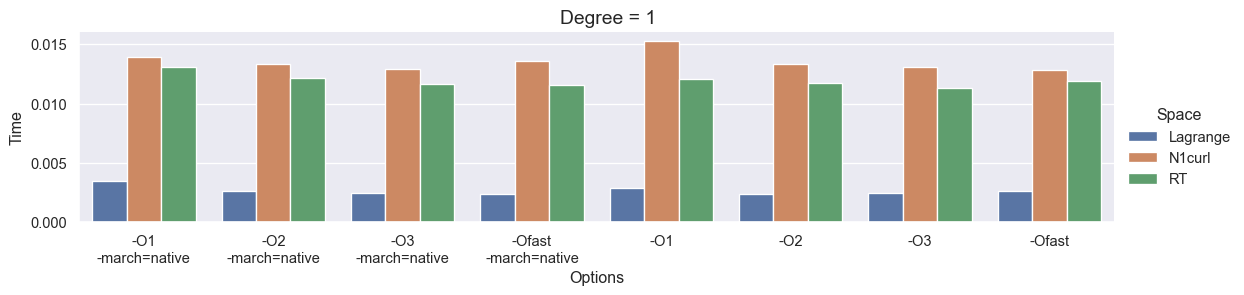

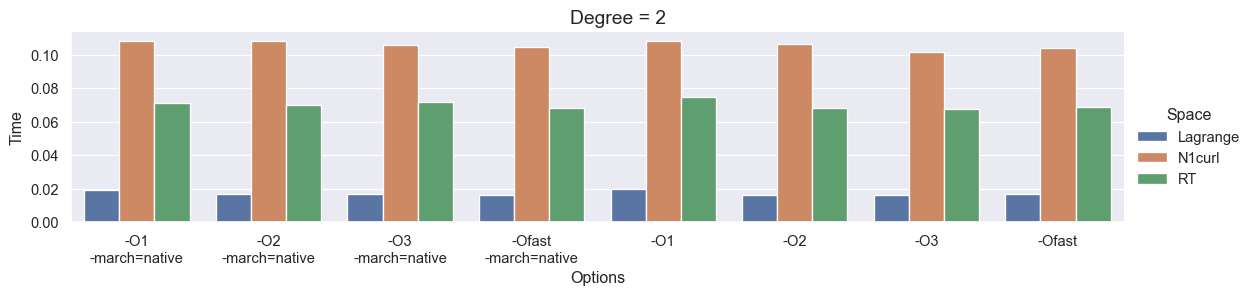

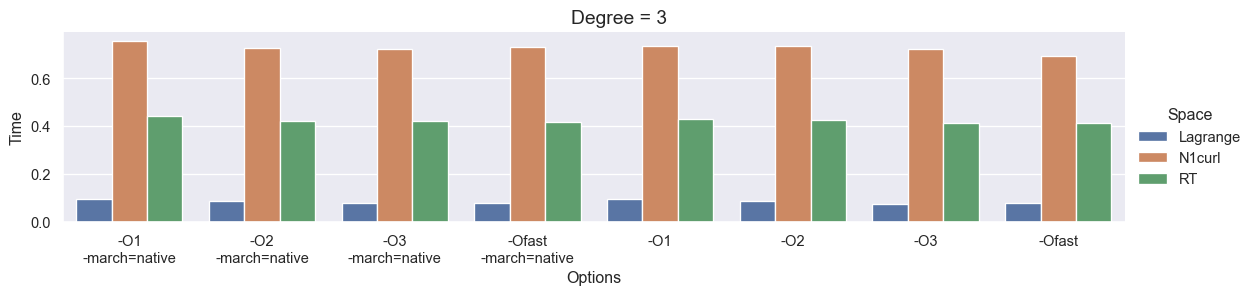

In [244]:
seaborn.set(style="ticks")
seaborn.set_style("darkgrid")

results_df["Element"] = results_df["Space"] +" " +results_df["Degree"]
hue_order = sorted(results_df["Space"].unique())
for degree in [1, 2, 3]:
  df_degree = results_df[results_df["Degree"] == str(degree)]

  g = seaborn.catplot(
    x="Options", 
    y="Time", 
    hue="Space",
    hue_order=hue_order, 
    kind="bar", 
    data=df_degree,
    height=3,
    aspect=4.0)
  g.fig.suptitle(f"Degree = {degree}", y=1.02)

We observe that the compile time increases as the degree of the function space grows, and that the greatest speedup is achieved when using `-O3` or `-Ofast` in combination with `-march=native`

### Error control: Computing convergence rates

Author: Jørgen S. Dokken, Hans Petter Langtangen, Anders Logg

For any numerical method, one of the most fundamental questions is its convergence rate: how fast the error decreases as the resolution is increased (i.e., as the mesh size is decreased)

In the finite element method, this typically involves proving—either theoretically or empirically—that the error $\| u - u_h \|$ is bounded by a constant times the mesh size $h$ raised to some power $p$, that is,

$$\| u - u_h \| \le C \, h^p$$

for some constant $C$ independent of the mesh. The number $p$ is called the convergence rate of the method. Note that different norms, such as the $L^2$-norm or the $H^1$-norm, generally yield different convergence rates

**Computing error norms**

We first construct a manufactured problem based on the same configuration used in the solver

In [245]:
import numpy as np
from mpi4py import MPI

from dolfinx import default_scalar_type
from dolfinx.mesh import create_unit_square, locate_entities_boundary
from dolfinx.fem import (Expression, Function, functionspace,
                         assemble_scalar, dirichletbc, form, locate_dofs_topological)
from dolfinx.fem.petsc import LinearProblem

import ufl
from ufl import (SpatialCoordinate, TestFunction, TrialFunction, 
                 div, dot, dx, grad, inner)

def u_ex(mod):
  return lambda x: mod.cos(2 *mod.pi *x[0]) *mod.cos(2 *mod.pi *x[1])

u_numpy = u_ex(np)
u_ufl = u_ex(ufl)

def solve_poisson(N=10, degree=1):

  mesh = create_unit_square(MPI.COMM_WORLD, N, N)
    
  x = SpatialCoordinate(mesh)
  f = -div(grad(u_ufl(x)))
    
  V = functionspace(mesh, ("Lagrange", degree))
  u = TrialFunction(V)
  v = TestFunction(V)
    
  a = inner(grad(u), grad(v)) *dx
  L = f *v *dx
    
  u_bc = Function(V)
  u_bc.interpolate(u_numpy)
    
  facets = locate_entities_boundary(
    mesh, 
    mesh.topology.dim -1, 
    lambda x: np.full(x.shape[1], True)
  )
  dofs = locate_dofs_topological(
    V, 
    mesh.topology.dim -1, 
    facets
  )
  bcs = [dirichletbc(u_bc, dofs)]
    
  default_problem = LinearProblem(
    a, 
    L, 
    bcs=bcs, 
    petsc_options={"ksp_type": "preonly", "pc_type": "lu"}
  )

  return default_problem.solve(), u_ufl(x)

Now, we compute the error between the analytical solution $u_{\text{ex}} = u_{\text{ufl}}(x)$ and the approximate solution $u_h$. The $L^2$-norm of the error

$$\| u_e - u_h \|_{L^2(\Omega)} = \left( \int_\Omega |u_e - u_h|^2 \, dx \right)^{1/2}$$

measures the pointwise accuracy of the approximate solution in an average sense. It quantifies how close $u_h$ is to $u_e$ in terms of their values

In [246]:
uh, u_ex = solve_poisson(10)
comm = uh.function_space.mesh.comm

error_L2 = form((uh -u_ex)**2 *ufl.dx)
E_L2 = np.sqrt(comm.allreduce(assemble_scalar(error_L2), MPI.SUM))

if comm.rank == 0:
  print(f"L2-error: {E_L2:.2e}")

L2-error: 5.28e-02


Sometimes it is of interest to compute the error of the gradient field,
$\| \nabla (u_e - u_h) \|$,
often referred to as the $H_0^1$-norm of the error. This can be expressed as

$$\left( \int_\Omega \lvert \nabla (u_e - u_h) \rvert^2 \, dx \right)^{1/2}$$

The $H_0^1$-norm measures the error in the so-called energy space, which is particularly relevant for elliptic partial differential equations, as it reflects how well the numerical solution captures the energy of the exact solution

In [247]:
eh = uh -u_ex
error_H10 = form(dot(grad(eh), grad(eh)) *dx)
E_H10 = np.sqrt(comm.allreduce(assemble_scalar(error_H10), op=MPI.SUM))

if comm.rank == 0:
  print(f"H01-error: {E_H10:.2e}")

H01-error: 1.36e+00


**Reliable error norm computation**

However, expanding the expression gives

$$(u_{\text{ex}} - u_h)^2 = u_{\text{ex}}^2 + u_h^2 - 2u_{\text{ex}}u_h$$

If the error is small (while the solutions themselves are of moderate size), this calculation involves subtracting two quantities of order one—namely $u_{\text{ex}}^2 + u_h^2 \sim 1$ and $2u_{\text{ex}}u_h \sim 1$—to obtain a much smaller number. This subtraction is prone to round-off errors

To avoid this issue, we interpolate both the approximate and the exact solutions into a higher-order function space. We then subtract their degrees of freedom to form an explicit error function. Finally, we assemble (integrate) the squared error and take the square root to obtain the $L^2$-norm

In [248]:
def error_L2(uh, u_ex, degree_raise=3):

  # Create higher order function space
  mesh = uh.function_space.mesh
  degree = uh.function_space.ufl_element().degree
  family = uh.function_space.ufl_element().family_name
    
  W = functionspace(mesh, (family, degree +degree_raise))
    
  # Interpolate approximate solution
  u_W = Function(W)
  u_W.interpolate(uh)

  # Interpolate exact solution, special handling if exact solution
  # is a ufl expression or a python lambda function
  u_ex_W = Function(W)
  if isinstance(u_ex, ufl.core.expr.Expr):
    u_expr = Expression(u_ex, W.element.interpolation_points())
    u_ex_W.interpolate(u_expr)
  else:
    u_ex_W.interpolate(u_ex)

  # Compute the error in the higher order function space
  e_W = Function(W)
  e_W.x.array[:] = u_W.x.array -u_ex_W.x.array

  # Integrate the error
  error = form(ufl.inner(e_W, e_W) *ufl.dx)
  error_local = assemble_scalar(error)
  error_global = mesh.comm.allreduce(error_local, op=MPI.SUM)
  
  return np.sqrt(error_global)

**Computing convergence rates**

Let us consider a sequence of mesh resolutions

$$h_0 > h_1 > h_2 > \cdots, \qquad h_i = \frac{1}{N_i}$$

where $N_i$ denotes the number of subdivisions (or degrees of freedom) in the discretization. We compute the numerical error for a range of values of $N_i$

In [249]:
Ns = [4, 8, 16, 32, 64]
Es = np.zeros(len(Ns), dtype=default_scalar_type)
hs = np.zeros(len(Ns), dtype=np.float64)

for i, N in enumerate(Ns):
  uh, u_ex = solve_poisson(N, degree=1)
  comm = uh.function_space.mesh.comm

  # Accepts either u_numpy or u_ex
  # Use u_numpy for L2 error (no JIT needed)
  hs[i] = 1. /Ns[i]
  Es[i] = error_L2(uh, u_numpy)
  if comm.rank == 0:
    print(f"h: {hs[i]:.2e} Error: {Es[i]:.2e}")

h: 2.50e-01 Error: 2.43e-01
h: 1.25e-01 Error: 7.96e-02
h: 6.25e-02 Error: 2.15e-02
h: 3.12e-02 Error: 5.47e-03
h: 1.56e-02 Error: 1.37e-03


If we assume that the error $E_i$ can be expressed as

$E_i = C h_i^r$

with unknown constants $C$ and $r$, then by comparing two consecutive experiments

$$E_{i-1} = C h_{i-1}^r, \qquad E_i = C h_i^r$$

we can solve for $r$:

$$r = \frac{\ln(E_i / E_{i-1})}{\ln(h_i / h_{i-1})}$$

As $i$ increases, the computed values of $r$ should approach the expected convergence rate, which in the case of the $L^2$-error is typically the polynomial degree plus one. This calculation can be implemented compactly using `NumPy`

In [250]:
rates = np.log(Es[1:] /Es[:-1]) /np.log(hs[1:] /hs[:-1])
if comm.rank == 0:
  print(f"Rates: {rates}")

Rates: [1.61228695 1.89147568 1.97191247 1.99290382]


We perform a similar study for different polynomial orders to verify the previous claim

In [251]:
degrees = [1, 2, 3, 4]
for degree in degrees:
  hs = np.zeros(len(Ns), dtype=np.float64)
  Es = np.zeros(len(Ns), dtype=default_scalar_type)
    
  for i, N in enumerate(Ns):
    uh, u_ex = solve_poisson(N, degree=degree)
    comm = uh.function_space.mesh.comm

    hs[i] = 1. /Ns[i]    
    Es[i] = error_L2(uh, u_numpy, degree_raise=3)

    if comm.rank == 0:
      print(f"h: {hs[i]:.2e} Error: {Es[i]:.2e}")
    
  rates = np.log(Es[1:] /Es[:-1]) /np.log(hs[1:] /hs[:-1])
  if comm.rank == 0:
    print(f"Polynomial degree {degree:d}, Rates {rates}\n")

h: 2.50e-01 Error: 2.43e-01
h: 1.25e-01 Error: 7.96e-02
h: 6.25e-02 Error: 2.15e-02
h: 3.12e-02 Error: 5.47e-03


h: 1.56e-02 Error: 1.37e-03
Polynomial degree 1, Rates [1.61228695 1.89147568 1.97191247 1.99290382]



h: 2.50e-01 Error: 3.52e-02
h: 1.25e-01 Error: 4.39e-03
h: 6.25e-02 Error: 5.50e-04
h: 3.12e-02 Error: 6.88e-05


h: 1.56e-02 Error: 8.60e-06
Polynomial degree 2, Rates [3.00109101 2.99828073 2.99822291 2.99930786]



h: 2.50e-01 Error: 5.54e-03


h: 1.25e-01 Error: 3.35e-04
h: 6.25e-02 Error: 1.99e-05
h: 3.12e-02 Error: 1.21e-06


h: 1.56e-02 Error: 7.49e-08
Polynomial degree 3, Rates [4.04795047 4.07357659 4.03728992 4.01645269]

h: 2.50e-01 Error: 7.20e-04
h: 1.25e-01 Error: 2.42e-05
h: 6.25e-02 Error: 7.75e-07
h: 3.12e-02 Error: 2.44e-08


h: 1.56e-02 Error: 7.64e-10
Polynomial degree 4, Rates [4.896908   4.96084158 4.98926012 4.99766448]



**Infinity norm estimates**

We first define a function to evaluate the infinity norm, i.e., the maximum pointwise error between the numerical and exact solutions

In [252]:
def error_infinity(u_h, u_ex):
  # Interpolate exact solution (UFL or lambda handled separately)
  u_ex_V = Function(u_h.function_space)
  comm = u_h.function_space.mesh.comm
    
  if isinstance(u_ex, ufl.core.expr.Expr):
    u_expr = Expression(u_ex, u_h.function_space.element.interpolation_points())
    u_ex_V.interpolate(u_expr)
  else:
    u_ex_V.interpolate(u_ex)

  # Compute global infinity norm from local maxima  
  error_max_local = np.max(np.abs(u_h.x.array -u_ex_V.x.array))
  error_max = comm.allreduce(error_max_local, op=MPI.MAX)

  return error_max

Performing this procedure for various polynomial degrees produces the following results:

In [253]:
for degree in degrees:
  hs = np.zeros(len(Ns), dtype=np.float64)    
  Es = np.zeros(len(Ns), dtype=default_scalar_type)

  for i, N in enumerate(Ns):
    uh, u_ex = solve_poisson(N, degree=degree)
    comm = uh.function_space.mesh.comm

    hs[i] = 1. /Ns[i]    
    Es[i] = error_infinity(uh, u_numpy)

    if comm.rank == 0:
       print(f"h: {hs[i]:.2e} Error: {Es[i]:.2e}")
    
  rates = np.log(Es[1:] /Es[:-1]) /np.log(hs[1:] /hs[:-1])
  if comm.rank == 0:
    print(f"Polynomial degree {degree:d}, Rates {rates}\n")

h: 2.50e-01 Error: 2.73e-01
h: 1.25e-01 Error: 6.96e-02
h: 6.25e-02 Error: 1.75e-02
h: 3.12e-02 Error: 4.38e-03
h: 1.56e-02 Error: 1.10e-03
Polynomial degree 1, Rates [1.96828918 1.9917697  1.99791282 1.99947611]

h: 2.50e-01 Error: 4.85e-02
h: 1.25e-01 Error: 3.65e-03
h: 6.25e-02 Error: 2.37e-04
h: 3.12e-02 Error: 1.50e-05
h: 1.56e-02 Error: 9.38e-07
Polynomial degree 2, Rates [3.73213705 3.94227924 3.98612529 3.99656575]

h: 2.50e-01 Error: 1.08e-02
h: 1.25e-01 Error: 8.13e-04
h: 6.25e-02 Error: 5.86e-05


h: 3.12e-02 Error: 3.80e-06


h: 1.56e-02 Error: 2.41e-07
Polynomial degree 3, Rates [3.72903577 3.79406598 3.94800701 3.97888408]

h: 2.50e-01 Error: 1.63e-03
h: 1.25e-01 Error: 5.23e-05
h: 6.25e-02 Error: 1.67e-06


h: 3.12e-02 Error: 5.25e-08


h: 1.56e-02 Error: 1.64e-09
Polynomial degree 4, Rates [4.96133103 4.96807694 4.99161588 4.99787562]



We observe superconvergence for second-order polynomials, resulting in an observed fourth-order convergence


### Custom Newton solvers

Author: Jørgen S. Dokken

Newton’s Method, as used in the non-linear Poisson problem, is a technique for solving a non-linear equation by iteratively solving a sequence of linear equations.
Given a function $F:\mathbb{R}^M \to \mathbb{R}^M$, the iterates $u_k, u_{k+1} \in \mathbb{R}^M$ satisfy

$$u_{k+1} = u_k - J_F(u_k)^{-1} F(u_k)$$

where $J_F(u_k)$ is the Jacobian matrix of $F$ at $u_k$

Introducing the increment $\delta u_k = u_{k+1} - u_k$, this can be rewritten as the linear system

$$J_F(u_k) \, \delta u_k = - F(u_k)$$

with the update

$$u_{k+1} = u_k + \delta u_k$$

**Problem specification**

We start by importing the required libraries

In [254]:
import numpy as np
from mpi4py import MPI
from petsc4py import PETSc

import matplotlib.pyplot as plt
import pyvista

import dolfinx
import dolfinx.fem.petsc

import ufl

plt.style.use('default')

We consider the following non-linear problem:

$$u^2 - 2u = x^2 + 4x + 3 \quad \text{for } x \in [0,1]$$

This problem has two solutions: $u = -x - 1$ and $u = x + 3$. We define these roots as Python functions and create an appropriate array of points for plotting the solutions

In [255]:
def root_0(x):
  return 3 +x[0]

def root_1(x):
  return -1 -x[0]

N = 10
x_spacing = np.linspace(0, 1, N)
roots = [root_0, root_1]

Starting with the initial guess $u_0 = 0$, we then define the mesh, the function space, and the function `uh` for the numerical solution

In [256]:
mesh = dolfinx.mesh.create_unit_interval(MPI.COMM_WORLD, N)

V = dolfinx.fem.functionspace(mesh, ("Lagrange", 1))
uh = dolfinx.fem.Function(V)

**Definition of residual and Jacobian**

We then formulate the variational problem by multiplying with a test function and integrating over the domain $[0,1]$

In [257]:
v = ufl.TestFunction(V)

x = ufl.SpatialCoordinate(mesh)
F = uh**2 *v *ufl.dx -2 *uh *v *ufl.dx -(x[0]**2 +4 *x[0] +3) *v *ufl.dx
residual = dolfinx.fem.form(F)

The Jacobian $J_F$ is then obtained by applying `ufl.derivative` to the variational form

In [258]:
J = ufl.derivative(F, uh)
jacobian = dolfinx.fem.form(J)

As the problem will be solved iteratively, the sparse matrix and residual vector are assembled only once

**Setup of iteration-independent structures**

In [259]:
A = dolfinx.fem.petsc.create_matrix(jacobian)
L = dolfinx.fem.petsc.create_vector(residual)

We then set up the linear solver together with a vector to hold the update `du`

In [260]:
solver = PETSc.KSP().create(mesh.comm)
solver.setOperators(A)

du = dolfinx.fem.Function(V)

To monitor the evolution of `uh` during the iterations, we obtain the DoF coordinates and sort them in ascending order

In [261]:
coords = V.tabulate_dof_coordinates()[:, 0]
sort_order = np.argsort(coords)

max_iterations = 25
solutions = np.zeros((max_iterations +1, len(coords)))
solutions[0] = uh.x.array[sort_order]

At this stage, we are ready to solve the linearized problem. For each iteration, the Jacobian and residual are reassembled, and the norm of the update (`dx`) is used as the stopping criterion

In [262]:
i = 0
while i < max_iterations:
  # Assemble Jacobian and residual
  with L.localForm() as loc_L:
    loc_L.set(0)
  A.zeroEntries()
  dolfinx.fem.petsc.assemble_matrix(A, jacobian)
  A.assemble()
  dolfinx.fem.petsc.assemble_vector(L, residual)
  L.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES, mode=PETSc.ScatterMode.REVERSE)

  # Scale residual by -1
  L.scale(-1)
  L.ghostUpdate(addv=PETSc.InsertMode.INSERT_VALUES, mode=PETSc.ScatterMode.FORWARD)

  # Solve linear problem
  solver.solve(L, du.x.petsc_vec)
  du.x.scatter_forward()
  
  # Update u_{i+1} = u_i + delta u_i
  uh.x.array[:] += du.x.array
  i += 1

  # Compute norm of update
  correction_norm = du.x.petsc_vec.norm(0)  # L^2 norm
  print(f"Iteration {i}: {correction_norm = :.6e}")
  if correction_norm < 1e-10:
    break
  solutions[i, :] = uh.x.array[sort_order]

Iteration 1: correction_norm = 2.941583e+01
Iteration 2: correction_norm = 1.077679e+01
Iteration 3: correction_norm = 2.048893e+00
Iteration 4: correction_norm = 8.991947e-02
Iteration 5: correction_norm = 2.277570e-04
Iteration 6: correction_norm = 2.211497e-09
Iteration 7: correction_norm = 1.123544e-15


At this point, we compute the residual magnitude to monitor convergence

In [263]:
dolfinx.fem.petsc.assemble_vector(L, residual)
print(f"Final residual = {L.norm(0):.6e}")

Final residual = 4.859835e-16


**Visualization of Newton iterations**

We now study how the solution evolves and quantify its error with respect to the two exact roots of the problem

L2-error (root 0) 5.033223e+00
L2-error (root 1) 1.110223e-16


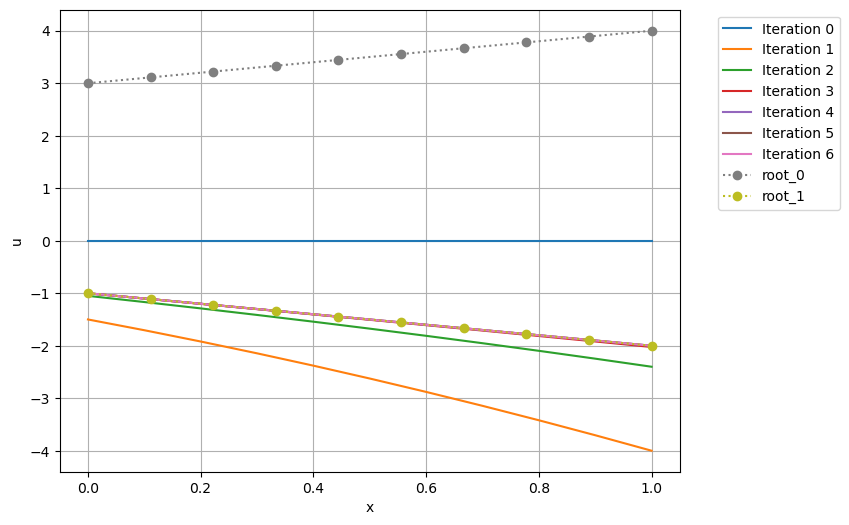

In [264]:
# Plot solution for each of the iterations
fig = plt.figure(figsize=(8, 6))

for j, solution in enumerate(solutions[:i]):
  plt.plot(coords[sort_order], solution, label=f"Iteration {j}")

# Plot each of the roots of the problem, 
# and compare the approximate solution with each of them
for j, root in enumerate(roots):
  u_ex = root(x)
  
  L2_error = dolfinx.fem.form(ufl.inner(uh -u_ex, uh -u_ex) *ufl.dx)
  global_L2 = mesh.comm.allreduce(
    dolfinx.fem.assemble_scalar(L2_error), 
    op=MPI.SUM
  )
  print(f"L2-error (root {j}) {np.sqrt(global_L2):.6e}")

  plt.plot(x_spacing, root(x_spacing.reshape(1, -1)), ':o', label=f'root_{j}')

plt.xlabel('x')
plt.ylabel('u')
plt.grid()
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

**Newton's method with DirichletBC**

In the previous example, we did not incorporate Dirichlet boundary conditions. We now extend the formulation to the non-linear Poisson problem, where such boundary conditions play a central role. As a first step, we define the computational mesh, the analytical solution, and the corresponding forcing term `f`

In [265]:
def q(u):
  return 1 +u**2

domain = dolfinx.mesh.create_unit_square(MPI.COMM_WORLD, 10, 10)

x = ufl.SpatialCoordinate(domain)
u_ufl = 1 +x[0] +2 *x[1]
f = - ufl.div(q(u_ufl) *ufl.grad(u_ufl))

def u_exact(x):
  return eval(str(u_ufl))

Next, we specify the Dirichlet boundary condition `bc`, and define the variational residual `F` together with its Jacobian `J`

In [266]:
V = dolfinx.fem.functionspace(domain, ("Lagrange", 1))

u_D = dolfinx.fem.Function(V)
u_D.interpolate(u_exact)

fdim = domain.topology.dim -1
domain.topology.create_connectivity(fdim, fdim +1)
boundary_facets = dolfinx.mesh.exterior_facet_indices(domain.topology)
bc = dolfinx.fem.dirichletbc(
  u_D, 
  dolfinx.fem.locate_dofs_topological(V, fdim, boundary_facets)
)

uh = dolfinx.fem.Function(V)
v = ufl.TestFunction(V)

F = q(uh) *ufl.dot(ufl.grad(uh), ufl.grad(v)) *ufl.dx -f *v *ufl.dx
J = ufl.derivative(F, uh)

residual = dolfinx.fem.form(F)
jacobian = dolfinx.fem.form(J)

We then set up the system matrix `A`, the right-hand side vector `L`, and the update function `du`

In [267]:
du = dolfinx.fem.Function(V)

A = dolfinx.fem.petsc.create_matrix(jacobian)
L = dolfinx.fem.petsc.create_vector(residual)

solver = PETSc.KSP().create(mesh.comm)
solver.setOperators(A)

Since this problem has strong Dirichlet boundary conditions, we need to apply a lifting to the right-hand side of our Newton problem. Recall that our goal is to solve the system

$$\begin{aligned}
J_F(u_k)\,\delta u_k &= - F(u_k),\\
u_{k+1} &= u_k + \delta u_k
\end{aligned}$$

We require that

$$u_{k+1}\vert_{\text{bc}} = u_D$$

However, we do not know if the current iterate satisfies the boundary condition, i.e., whether

$$u_k\vert_{\text{bc}} = u_D$$

To enforce the boundary condition, we therefore apply the following condition on the Newton correction $\delta u_k$:

$$\delta u_k \vert_{\text{bc}} = u_D - u_k \vert_{\text{bc}}$$

This leads to the following Newton scheme with strong Dirichlet conditions:

$$
\begin{aligned}
J_F(u_k)\,\delta u_k &= -F(u_k), & \delta u_k \vert_{\text{bc}} &= u_D - u_k\vert_{\text{bc}},\\
u_{k+1} &= u_k + \delta u_k
\end{aligned}$$

In [268]:
i = 0
error = dolfinx.fem.form(
  ufl.inner(uh -u_ufl, uh -u_ufl) *ufl.dx(metadata={"quadrature_degree": 4})
)
L2_error = []
du_norm = []
while i < max_iterations:
  # Assemble Jacobian and residual
  with L.localForm() as loc_L:
    loc_L.set(0)
  A.zeroEntries()
  dolfinx.fem.petsc.assemble_matrix(A, jacobian, bcs=[bc])
  A.assemble()
  dolfinx.fem.petsc.assemble_vector(L, residual)
  L.ghostUpdate(addv=PETSc.InsertMode.ADD, mode=PETSc.ScatterMode.REVERSE)
  L.scale(-1)

  # Compute b - J(u_D-u_(i-1))
  dolfinx.fem.petsc.apply_lifting(
    L, 
    [jacobian], 
    [[bc]], 
    x0=[uh.x.petsc_vec], 
    alpha=1
  )
  
  # Set du|_bc = u_{i-1}-u_D
  dolfinx.fem.petsc.set_bc(L, [bc], uh.x.petsc_vec, 1.0)
  L.ghostUpdate(addv=PETSc.InsertMode.INSERT_VALUES, mode=PETSc.ScatterMode.FORWARD)

  # Solve linear problem
  solver.solve(L, du.x.petsc_vec)
  du.x.scatter_forward()

  # Update u_{i+1} = u_i + delta u_i
  uh.x.array[:] += du.x.array
  i += 1

  # Compute norm of update
  correction_norm = du.x.petsc_vec.norm(0)

  # Compute L2 error comparing to the analytical solution
  L2_error.append(np.sqrt(mesh.comm.allreduce(dolfinx.fem.assemble_scalar(error), op=MPI.SUM)))
  du_norm.append(correction_norm)

  print(f"Iteration {i}: {correction_norm = :.6e}, L2_error = {L2_error[-1]:.6e}")
  if correction_norm < 1e-10:
    break

Iteration 1: correction_norm = 2.174258e+02, L2_error = 1.009449e+00
Iteration 2: correction_norm = 1.546085e+02, L2_error = 1.025886e+00
Iteration 3: correction_norm = 4.927247e+01, L2_error = 3.541886e-01
Iteration 4: correction_norm = 1.695612e+01, L2_error = 7.129374e-02
Iteration 5: correction_norm = 3.166798e+00, L2_error = 4.565047e-03
Iteration 6: correction_norm = 1.713648e-01, L2_error = 2.626998e-05
Iteration 7: correction_norm = 8.143265e-04, L2_error = 1.230202e-09
Iteration 8: correction_norm = 3.734667e-08, L2_error = 7.046012e-15
Iteration 9: correction_norm = 5.469294e-13, L2_error = 2.797439e-16


We visualize the convergence by plotting the $L^2$-error and the residual norm ($\delta u$) across iterations

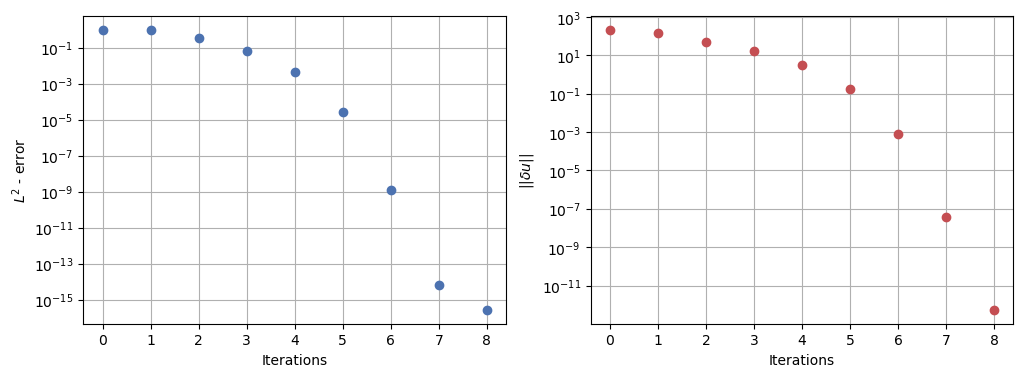

In [269]:
fig = plt.figure(figsize=(12, 4))

plt.subplot(121)
plt.semilogy(np.arange(i), L2_error, 'bo')
plt.grid()

plt.xlabel("Iterations")
plt.ylabel(r"$L^2$ - error")

plt.subplot(122)
plt.semilogy(np.arange(i), du_norm, 'ro')
plt.grid()

plt.xlabel("Iterations")
plt.ylabel(r"$\vert\vert \delta u\vert\vert$");

We compute the maximum error and plot the solution

In [270]:
error_max = domain.comm.allreduce(
  np.max(np.abs(uh.x.array -u_D.x.array)), 
  op=MPI.MAX
)

if domain.comm.rank == 0:
  print(f"Error_max = {error_max:.6e}")

Error_max = 8.881784e-16


In [271]:
from pathlib import Path

results_folder = Path("fenicsx/best_practices")
results_folder.mkdir(exist_ok=True, parents=True)

u_topology, u_cell_types, u_geometry = dolfinx.plot.vtk_mesh(V)
u_grid = pyvista.UnstructuredGrid(u_topology, u_cell_types, u_geometry)

u_grid.point_data["u"] = uh.x.array.real
u_grid.set_active_scalars("u")

u_plotter = pyvista.Plotter(off_screen=False)
u_plotter.add_mesh(u_grid, show_edges=True)
u_plotter.view_xy()

if not pyvista.OFF_SCREEN:
  #u_plotter.show()
  u_plotter.export_html(results_folder/"newton_solution.html")

```{=html}
<iframe src="fenicsx/best_practices/newton_solution.html"
        width="100%" height="400px"
        style="border:none;"
        allowfullscreen
        loading="lazy">        
</iframe>
```